# Preamble

In [53]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
from scipy.optimize import minimize
import sys
#here, configure the path to the directory for pre-defined functions.
sys.path.append('C:/Users/QEDLiu/PycharmProjects/Fluxonium_berkeley/PlotSaving/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_rotope as op
# import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
#Device parameters
nlev_lc = 30
nlev_single = 5  # The number of single-qubit levels to show.
take_data_from_input_file = False

if not take_data_from_input_file:
    # Parameters of the first fluxonium.
    E_L = 1.0  # inductive energy
    E_C = 3.0  # charging energy
    E_J = 15.0  # Josephson energy
    phi_ext = np.pi  # external phase shift

qubit = fluxonium.Fluxonium(E_J=E_J, E_C=E_C, E_L=E_L, phi_ext=phi_ext, nlev = nlev_single, nlev_lc = nlev_lc)

#Gate parameter
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 0.5
delta_omega_d = 0
shape = 'cos'
sigma = 0.25
drag = True
drag_coeff = 0.0

comp_space = [0,1]
omega_d = qubit.freq(0,1) + delta_omega_d

In [55]:
print (qubit.eigvec(0))

Quantum object: dims = [[30], [1]], shape = (30, 1), type = ket
Qobj data =
[[ 6.91039912e-01]
 [ 2.31272279e-01]
 [ 1.52903698e-02]
 [ 2.73014075e-01]
 [ 4.70872721e-01]
 [ 3.59960303e-01]
 [ 1.66590988e-01]
 [ 6.58037589e-02]
 [ 4.22455311e-03]
 [-5.95462288e-02]
 [-6.98216062e-02]
 [-1.48971757e-02]
 [ 3.31826201e-02]
 [ 2.87182932e-02]
 [ 7.90435678e-04]
 [-1.16136383e-02]
 [-7.42083912e-03]
 [-1.38082475e-03]
 [ 2.24868474e-03]
 [ 4.17440776e-03]
 [ 2.30982034e-03]
 [-2.02941413e-03]
 [-3.26248975e-03]
 [-2.94065892e-04]
 [ 2.12792641e-03]
 [ 1.09874357e-03]
 [-8.89910136e-04]
 [-9.71723259e-04]
 [ 3.63133240e-04]
 [ 1.45093834e-03]]


# Charge driving

In [56]:
matr_el = np.abs(qubit.n_ij(0,1))
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

state_0 = basis(nlev_single, 0)
state_1 = basis(nlev_single, 1)
state_2 = basis(nlev_single, 2)
state_3 = basis(nlev_single, 3)

In [57]:
print(U_t[-1])

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[-1.33558216e-01+1.80339176e-01j -8.07727375e-01-5.45175635e-01j
  -1.75225951e-06+2.59621789e-06j  5.11323824e-07+2.22086085e-07j
   8.29003696e-08-1.22936175e-07j]
 [-4.25051530e-01+8.76910019e-01j  2.06024981e-01+8.89591053e-02j
  -1.95378580e-07-7.68185751e-07j  1.36110851e-06+6.59775121e-07j
  -3.44046684e-08+2.35848722e-08j]
 [-3.18399972e-07-3.59378795e-07j  2.55118345e-06+1.92214980e-06j
  -5.74245811e-01+8.18682918e-01j -1.60585190e-04-6.14494548e-05j
  -2.21378629e-09+1.61695751e-09j]
 [-1.46620537e-06-6.27039228e-07j  1.79630356e-07-1.37966450e-07j
   1.38552860e-04+1.01632372e-04j  3.76943549e-01-9.26236218e-01j
  -1.26030499e-05-6.24992977e-06j]
 [ 1.70366727e-08+1.34557234e-08j  1.28710276e-07+7.71339129e-08j
   9.56340371e-10+8.72583690e-10j -1.21418038e-05-6.58660398e-06j
   5.41555478e-01-8.40665013e-01j]]


96.64266488925448


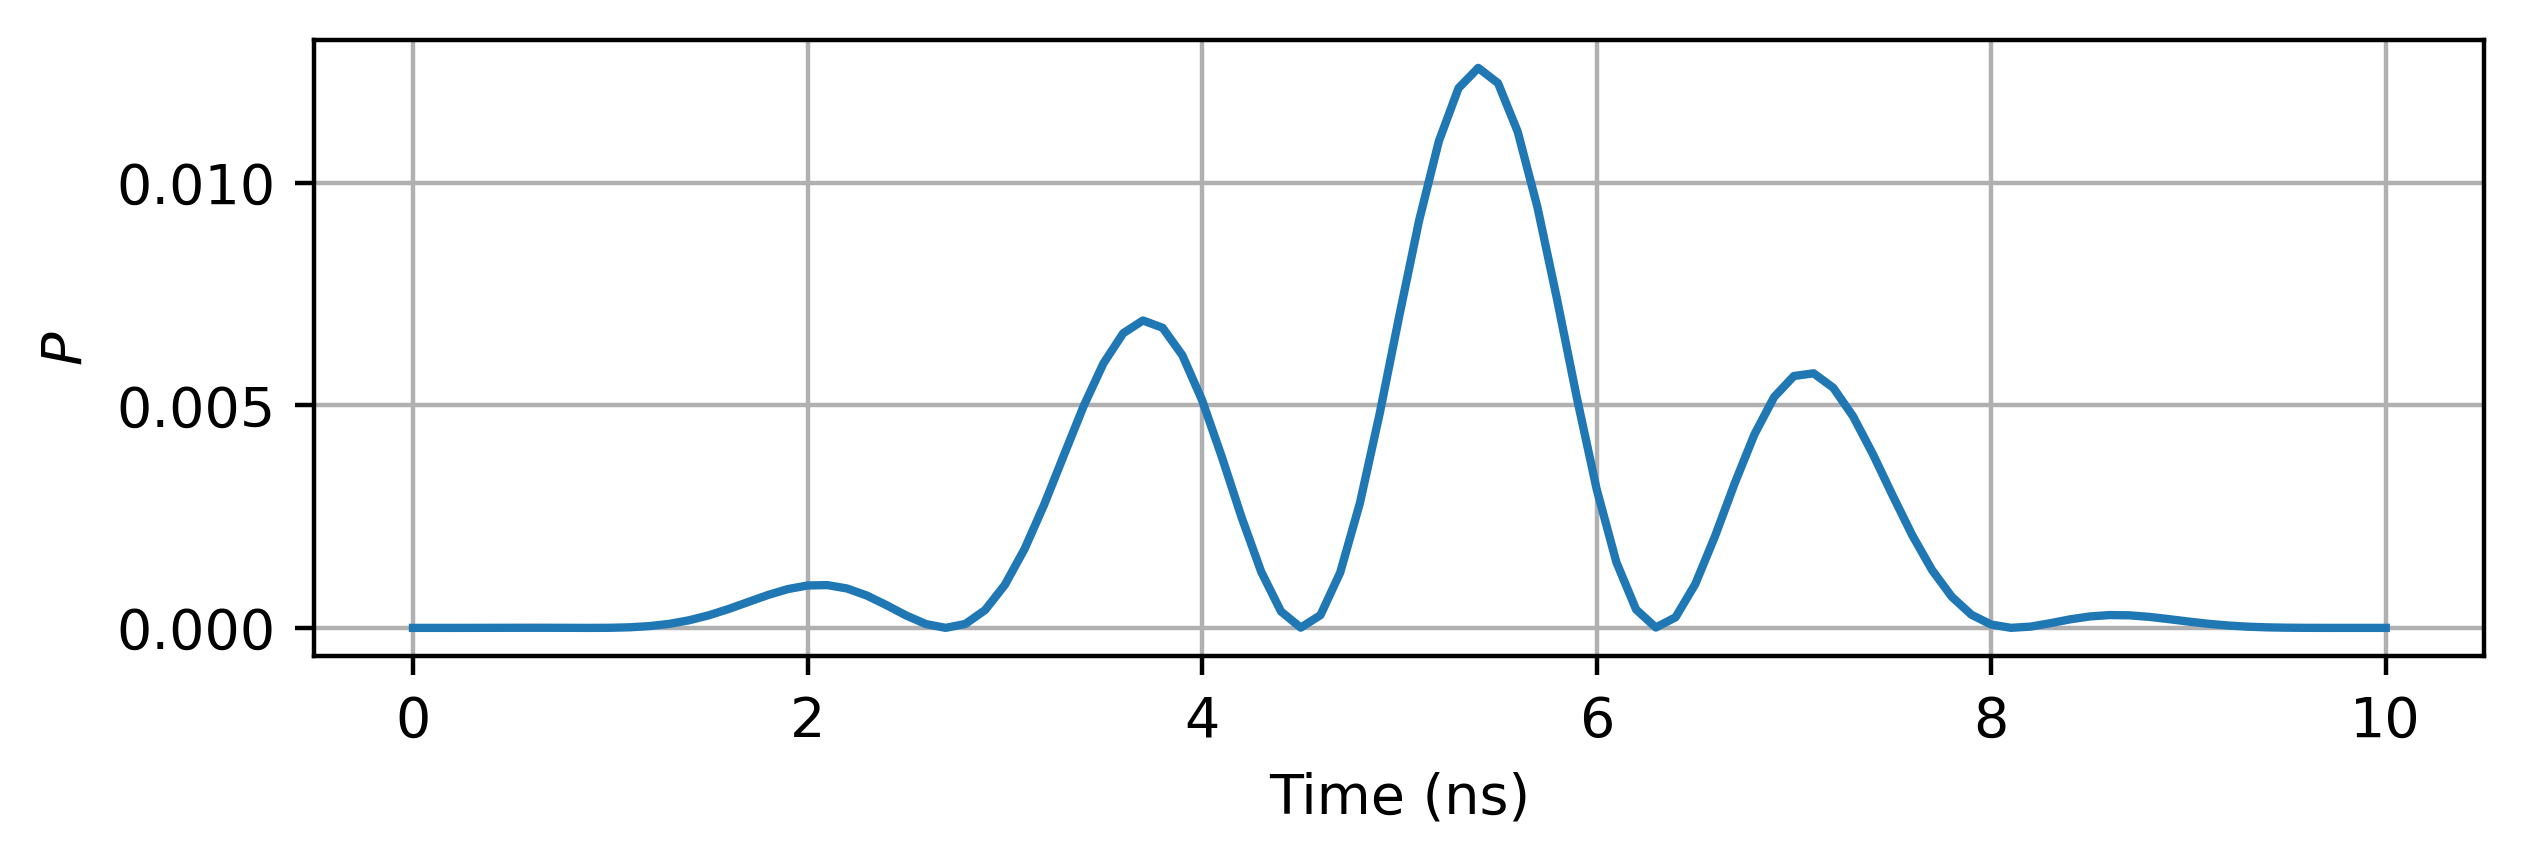

In [58]:
#Fidelity
U_ideal = qeye(2)
U_ideal = sigmay()
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidel*100)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
leakage_charge = 1 - trans_prob_0 - trans_prob_1

plt.figure(figsize = [7,2])
# plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
# plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
# plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
# plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.plot(t_points, leakage_charge)
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
# plt.legend()
plt.grid()
# plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

In [59]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(op.sigz(N=nlev_single),state_evol))
sx = np.real(expect(op.sigx(N=nlev_single),state_evol))
sy = np.real(expect(op.sigy(N=nlev_single),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.add_vectors([sx[-1], sy[-1], sz[-1]])
b.make_sphere()

In [60]:
print (qubit.level(1)-qubit.level(0))

0.27726240082075404


## Optimization
### Sweep drive amplitude

In [61]:
amplitude_array = np.linspace(4.5,5.5,101)*1e-1
error_array_amplitude_charge = np.zeros_like(amplitude_array)
U_ideal = sigmay()
for idx, drive_factor in enumerate(amplitude_array):
    epsilon = drive_factor/matr_el
    H_drive = epsilon*(qubit.n())
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = True, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    error_array_amplitude_charge[idx] = 1 - fidel

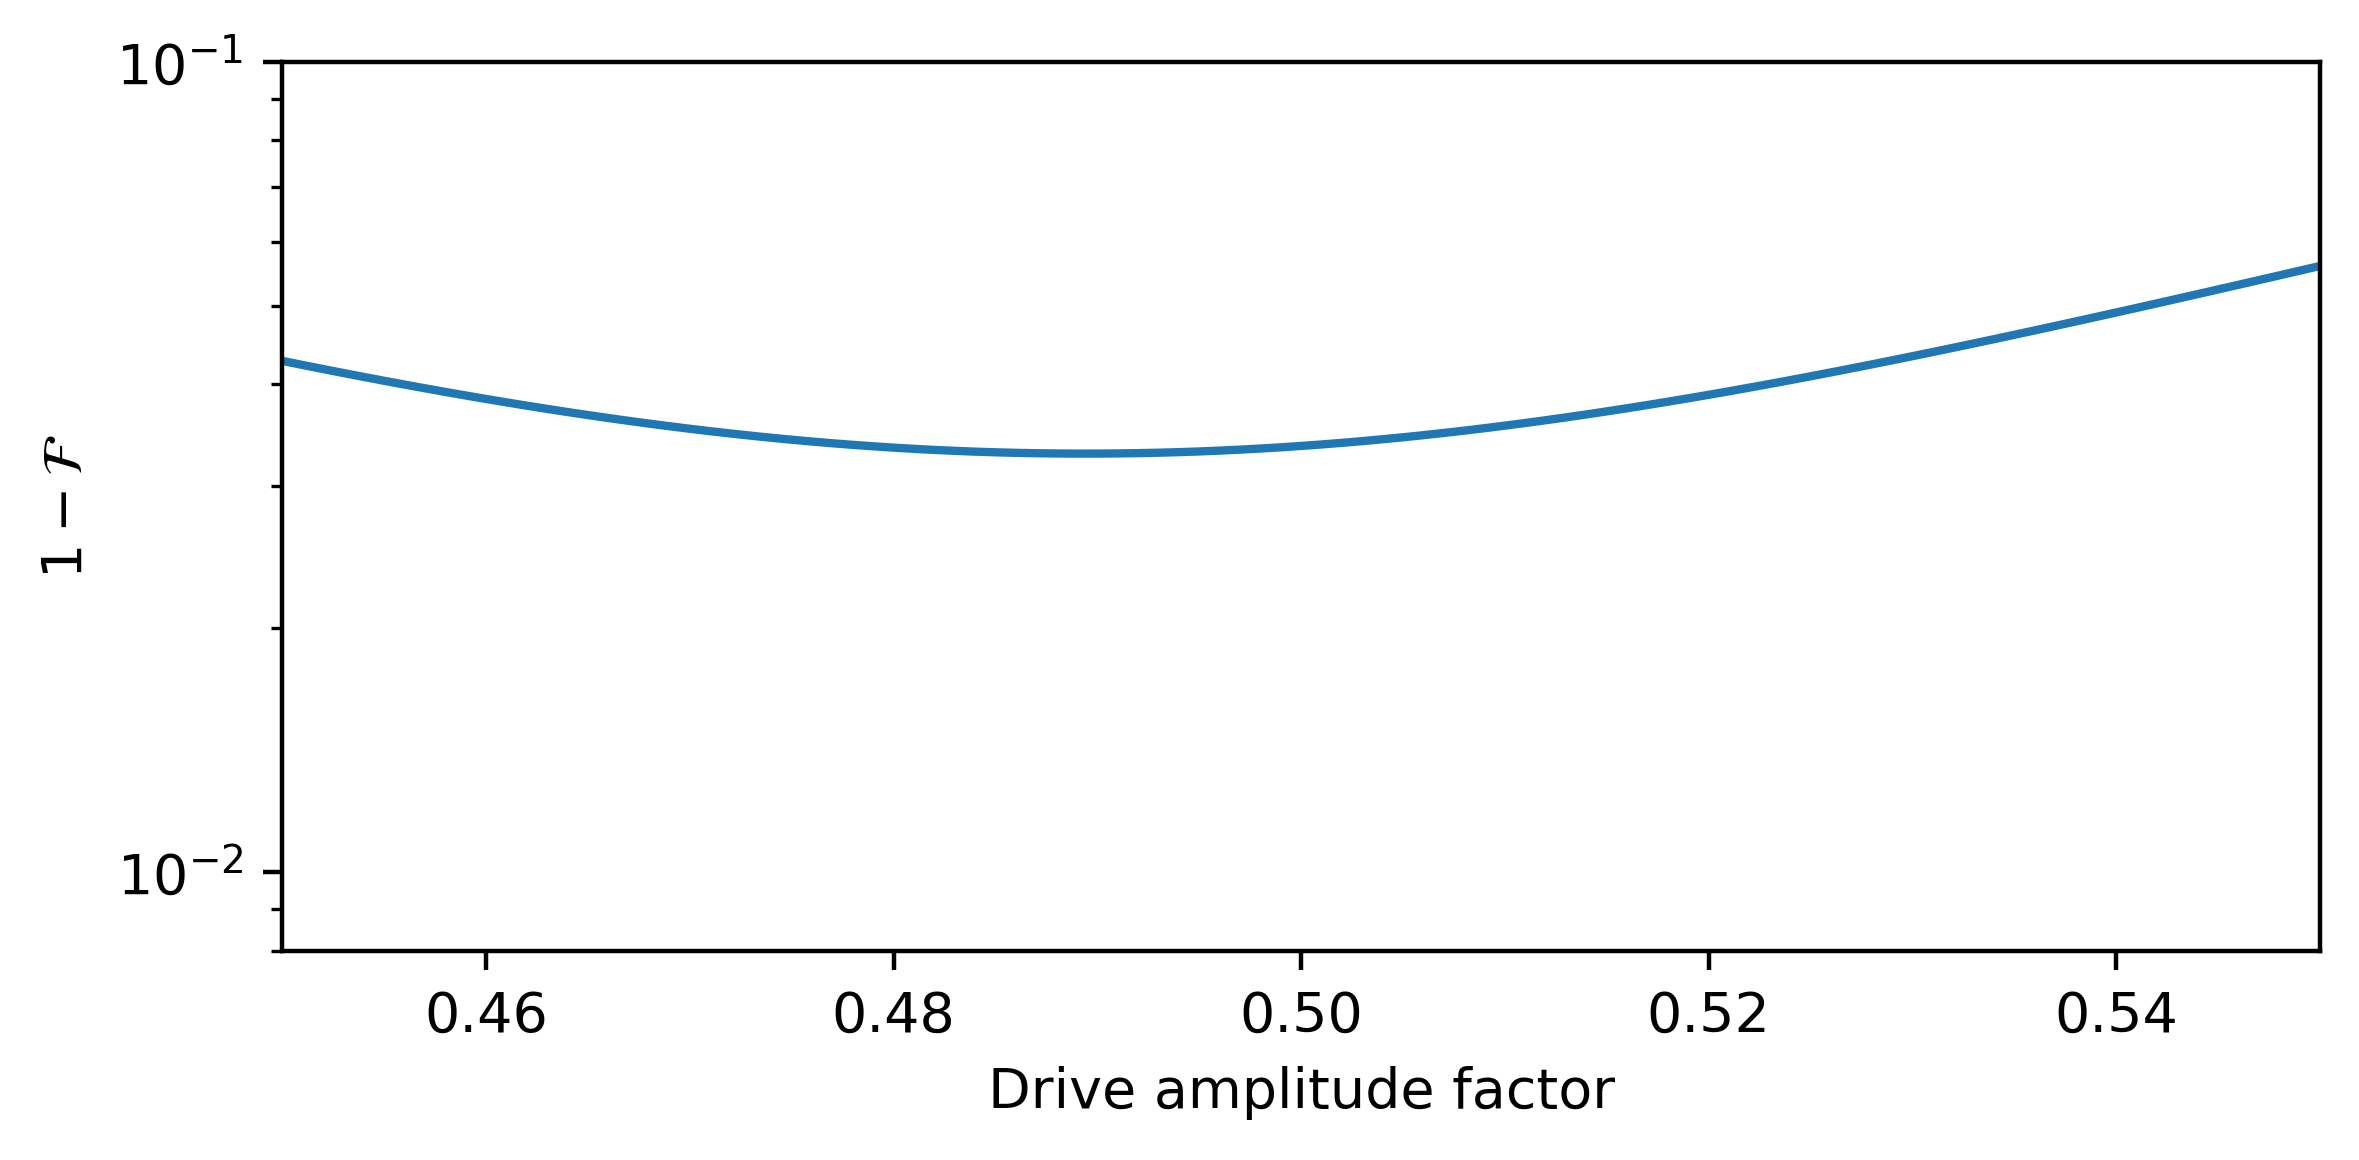

In [62]:
plt.figure(figsize=[6,3])
plt.semilogy(amplitude_array, error_array_amplitude_charge)
plt.ylim([0.8e-2,1e-1])
# plt.yticks([1e-2, 1e-1])
plt.xlim([amplitude_array[0], amplitude_array[-1]])
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel('Drive amplitude factor')
plt.tight_layout()
figname = '1Q_gate_opt1.pdf'
# plt.savefig(figpath+figname)

### Sweep DRAG

In [64]:
drag_coeff_array = np.linspace(-1,1,201)
error_array_DRAG_charge = np.zeros_like(drag_coeff_array)
drive_amplitude_factor = 0.5
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
U_ideal = sigmay()
for idx, drag_coeff in enumerate(drag_coeff_array):
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = True, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    error_array_DRAG_charge[idx] = 1 - fidel

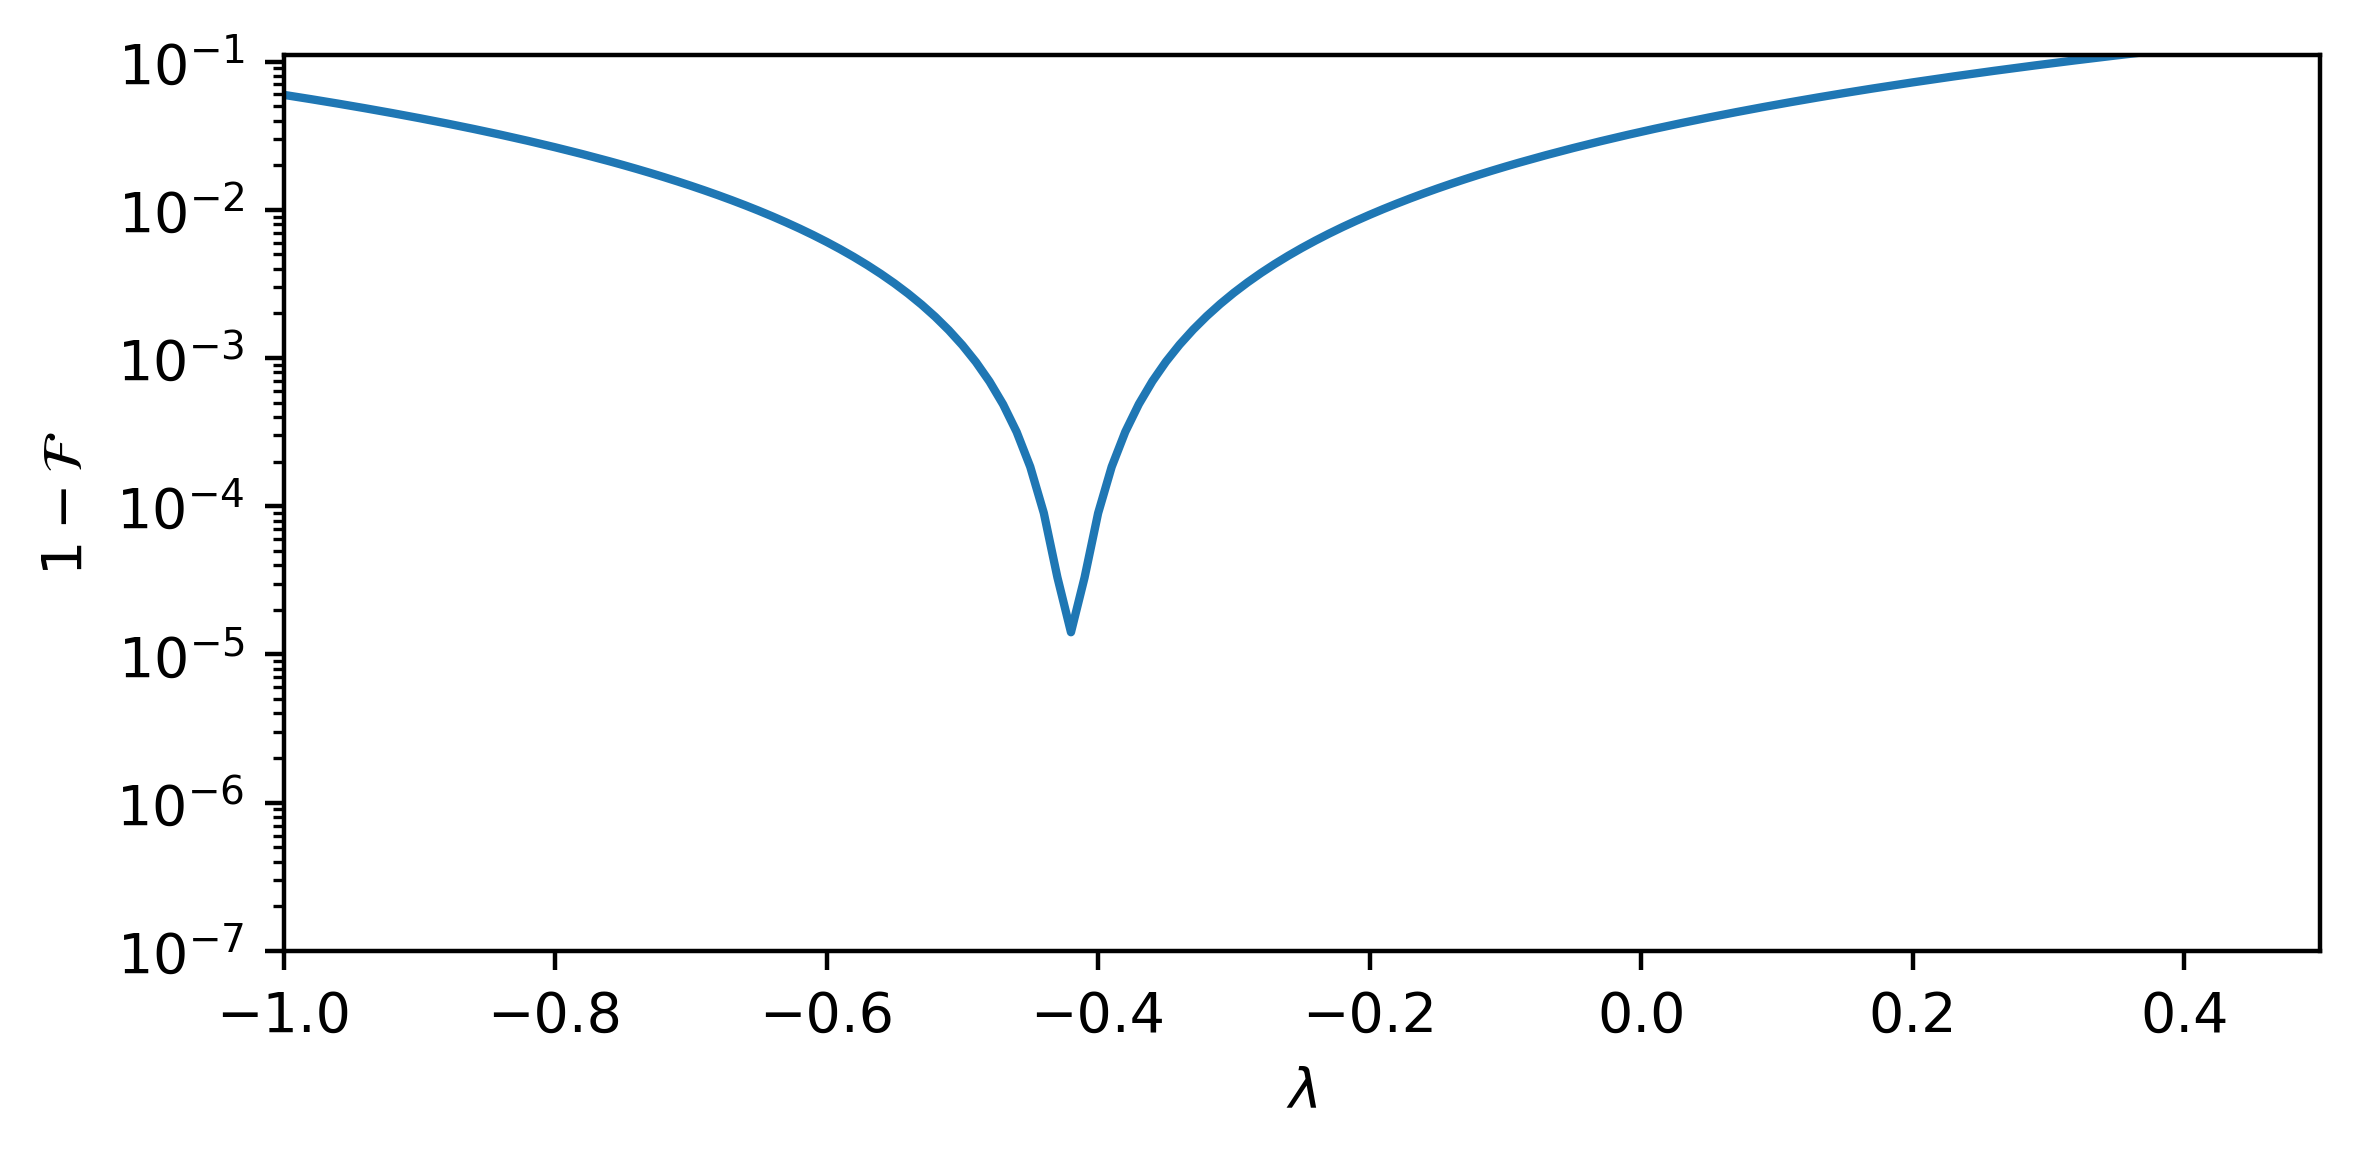

In [65]:
plt.figure(figsize=[6,3])
plt.semilogy(drag_coeff_array, error_array_DRAG_charge)
plt.ylim([1e-7,1.1e-1])
plt.yticks([1e-7,1e-6,1e-5,1e-4,1e-3,1e-2, 1e-1])
plt.xlim([-1, 0.5])
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel(r'$\lambda$')
plt.tight_layout()
figname = '1Q_gate_opt2.pdf'
# plt.savefig(figpath+figname)

### Sweep detuning

In [66]:
drag_coeff = 0
drive_amplitude_factor = 0.5
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

delta_omega_d_array = np.linspace(-0.02,0.01,51)
error_array_detune_charge = np.zeros_like(delta_omega_d_array)
for idx, delta_omega_d in enumerate(delta_omega_d_array):
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    error_array_detune_charge[idx] = 1 - fidel

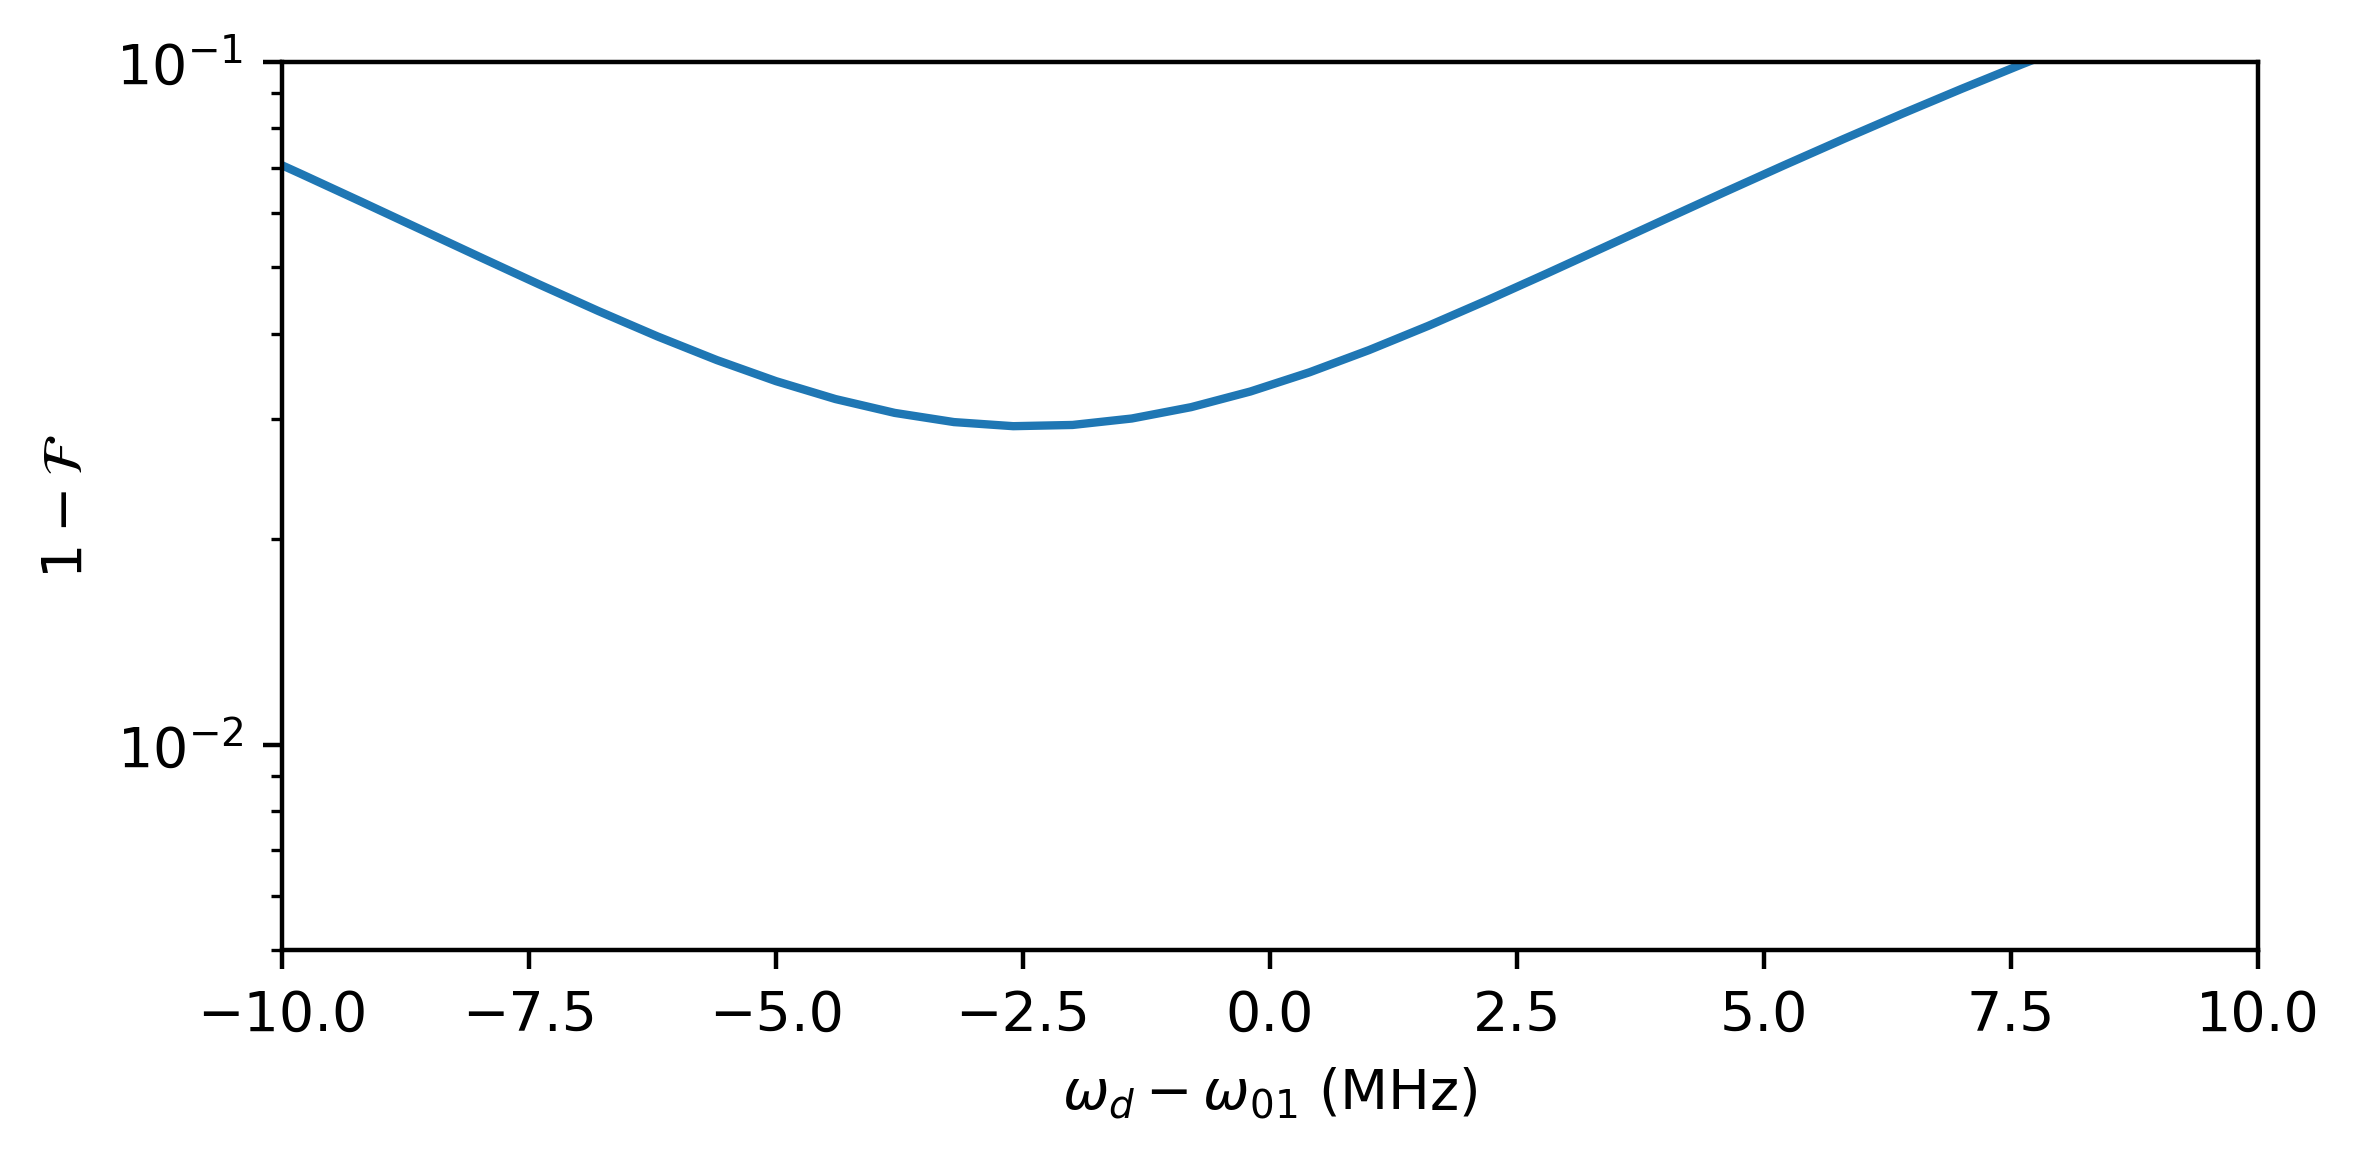

In [67]:
plt.figure(figsize=[6,3])
plt.semilogy (delta_omega_d_array*1e3, error_array_detune_charge)
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel(r'$\omega_d - \omega_{01}$ (MHz)')
plt.xlim([-10,10])
plt.ylim([0.5e-2,1e-1])
plt.tight_layout()
figname = '1Q_gate_opt3.pdf'
# plt.savefig(figpath+figname)

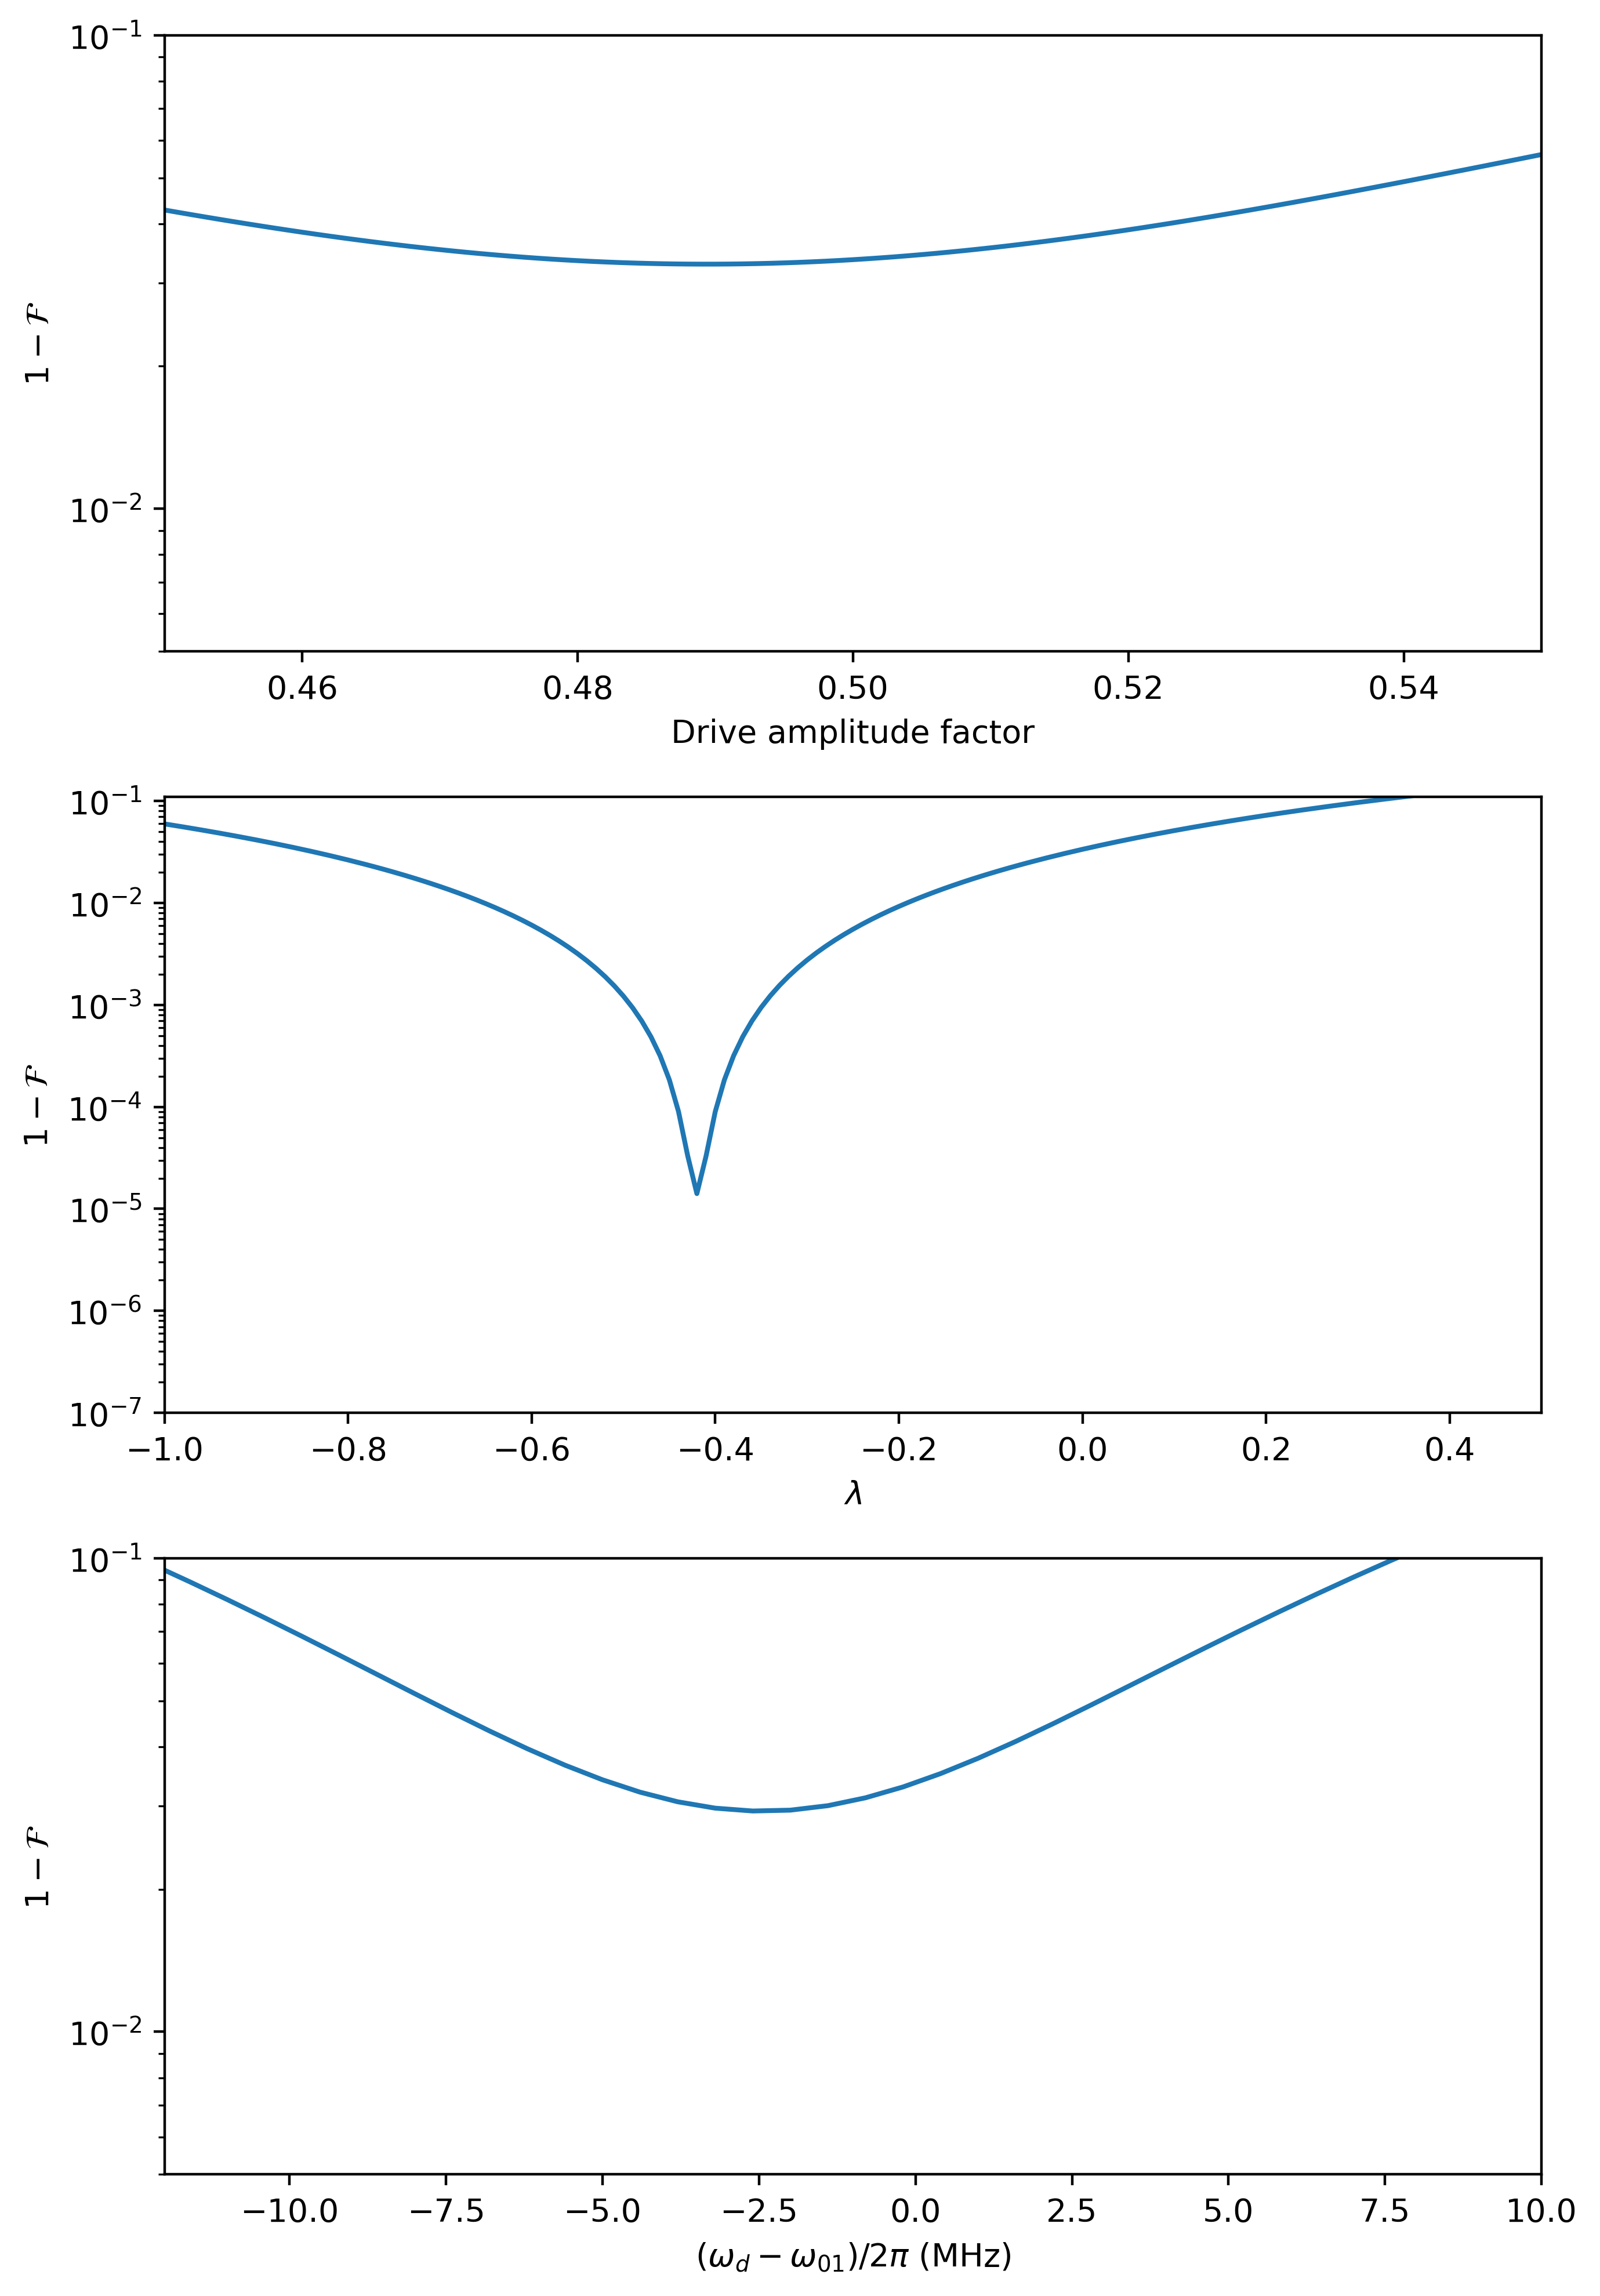

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = [7,10])

ax1.semilogy(amplitude_array, error_array_amplitude_charge)
ax1.set_ylim([0.5e-2,1e-1])
ax1.set_xlim([amplitude_array[0], amplitude_array[-1]])
ax1.set_ylabel(r'$1-\mathcal{F}$')
ax1.set_xlabel('Drive amplitude factor')

ax2.semilogy(drag_coeff_array, error_array_DRAG_charge)
ax2.set_ylim([1e-7,1.1e-1])
ax2.set_yticks([1e-7,1e-6,1e-5,1e-4,1e-3,1e-2, 1e-1])
ax2.set_xlim([-1, 0.5])
ax2.set_ylabel(r'$1-\mathcal{F}$')
ax2.set_xlabel(r'$\lambda$')

ax3.semilogy (delta_omega_d_array*1e3, error_array_detune_charge)
ax3.set_ylabel(r'$1-\mathcal{F}$')
ax3.set_xlabel(r'$(\omega_d - \omega_{01})/2\pi$ (MHz)')
ax3.set_xlim([-12,10])
ax3.set_ylim([0.5e-2,1e-1])

plt.tight_layout()
# figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/1Q_calibration.pdf'
# plt.savefig(figpath)

### Numberical optimization using both detuning and DRAG

In [69]:
def infidelity(x):
    delta_omega_d = x[0]
    drag_coeff = x[1]
    drive_factor = x[2]
    epsilon = drive_factor/matr_el
    H_drive = epsilon*(qubit.n())
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return 1-fidel

x0 = [0,0,0.5]
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-7)
print (xopt.x)
print (infidelity(xopt.x))

[ 3.15825414e-07 -4.19920999e-01  5.01482031e-01]
9.407914780545923e-09


9.407914780545923e-09


Text(0.5, 1.0, '$\\mathcal{F}=$1.0')

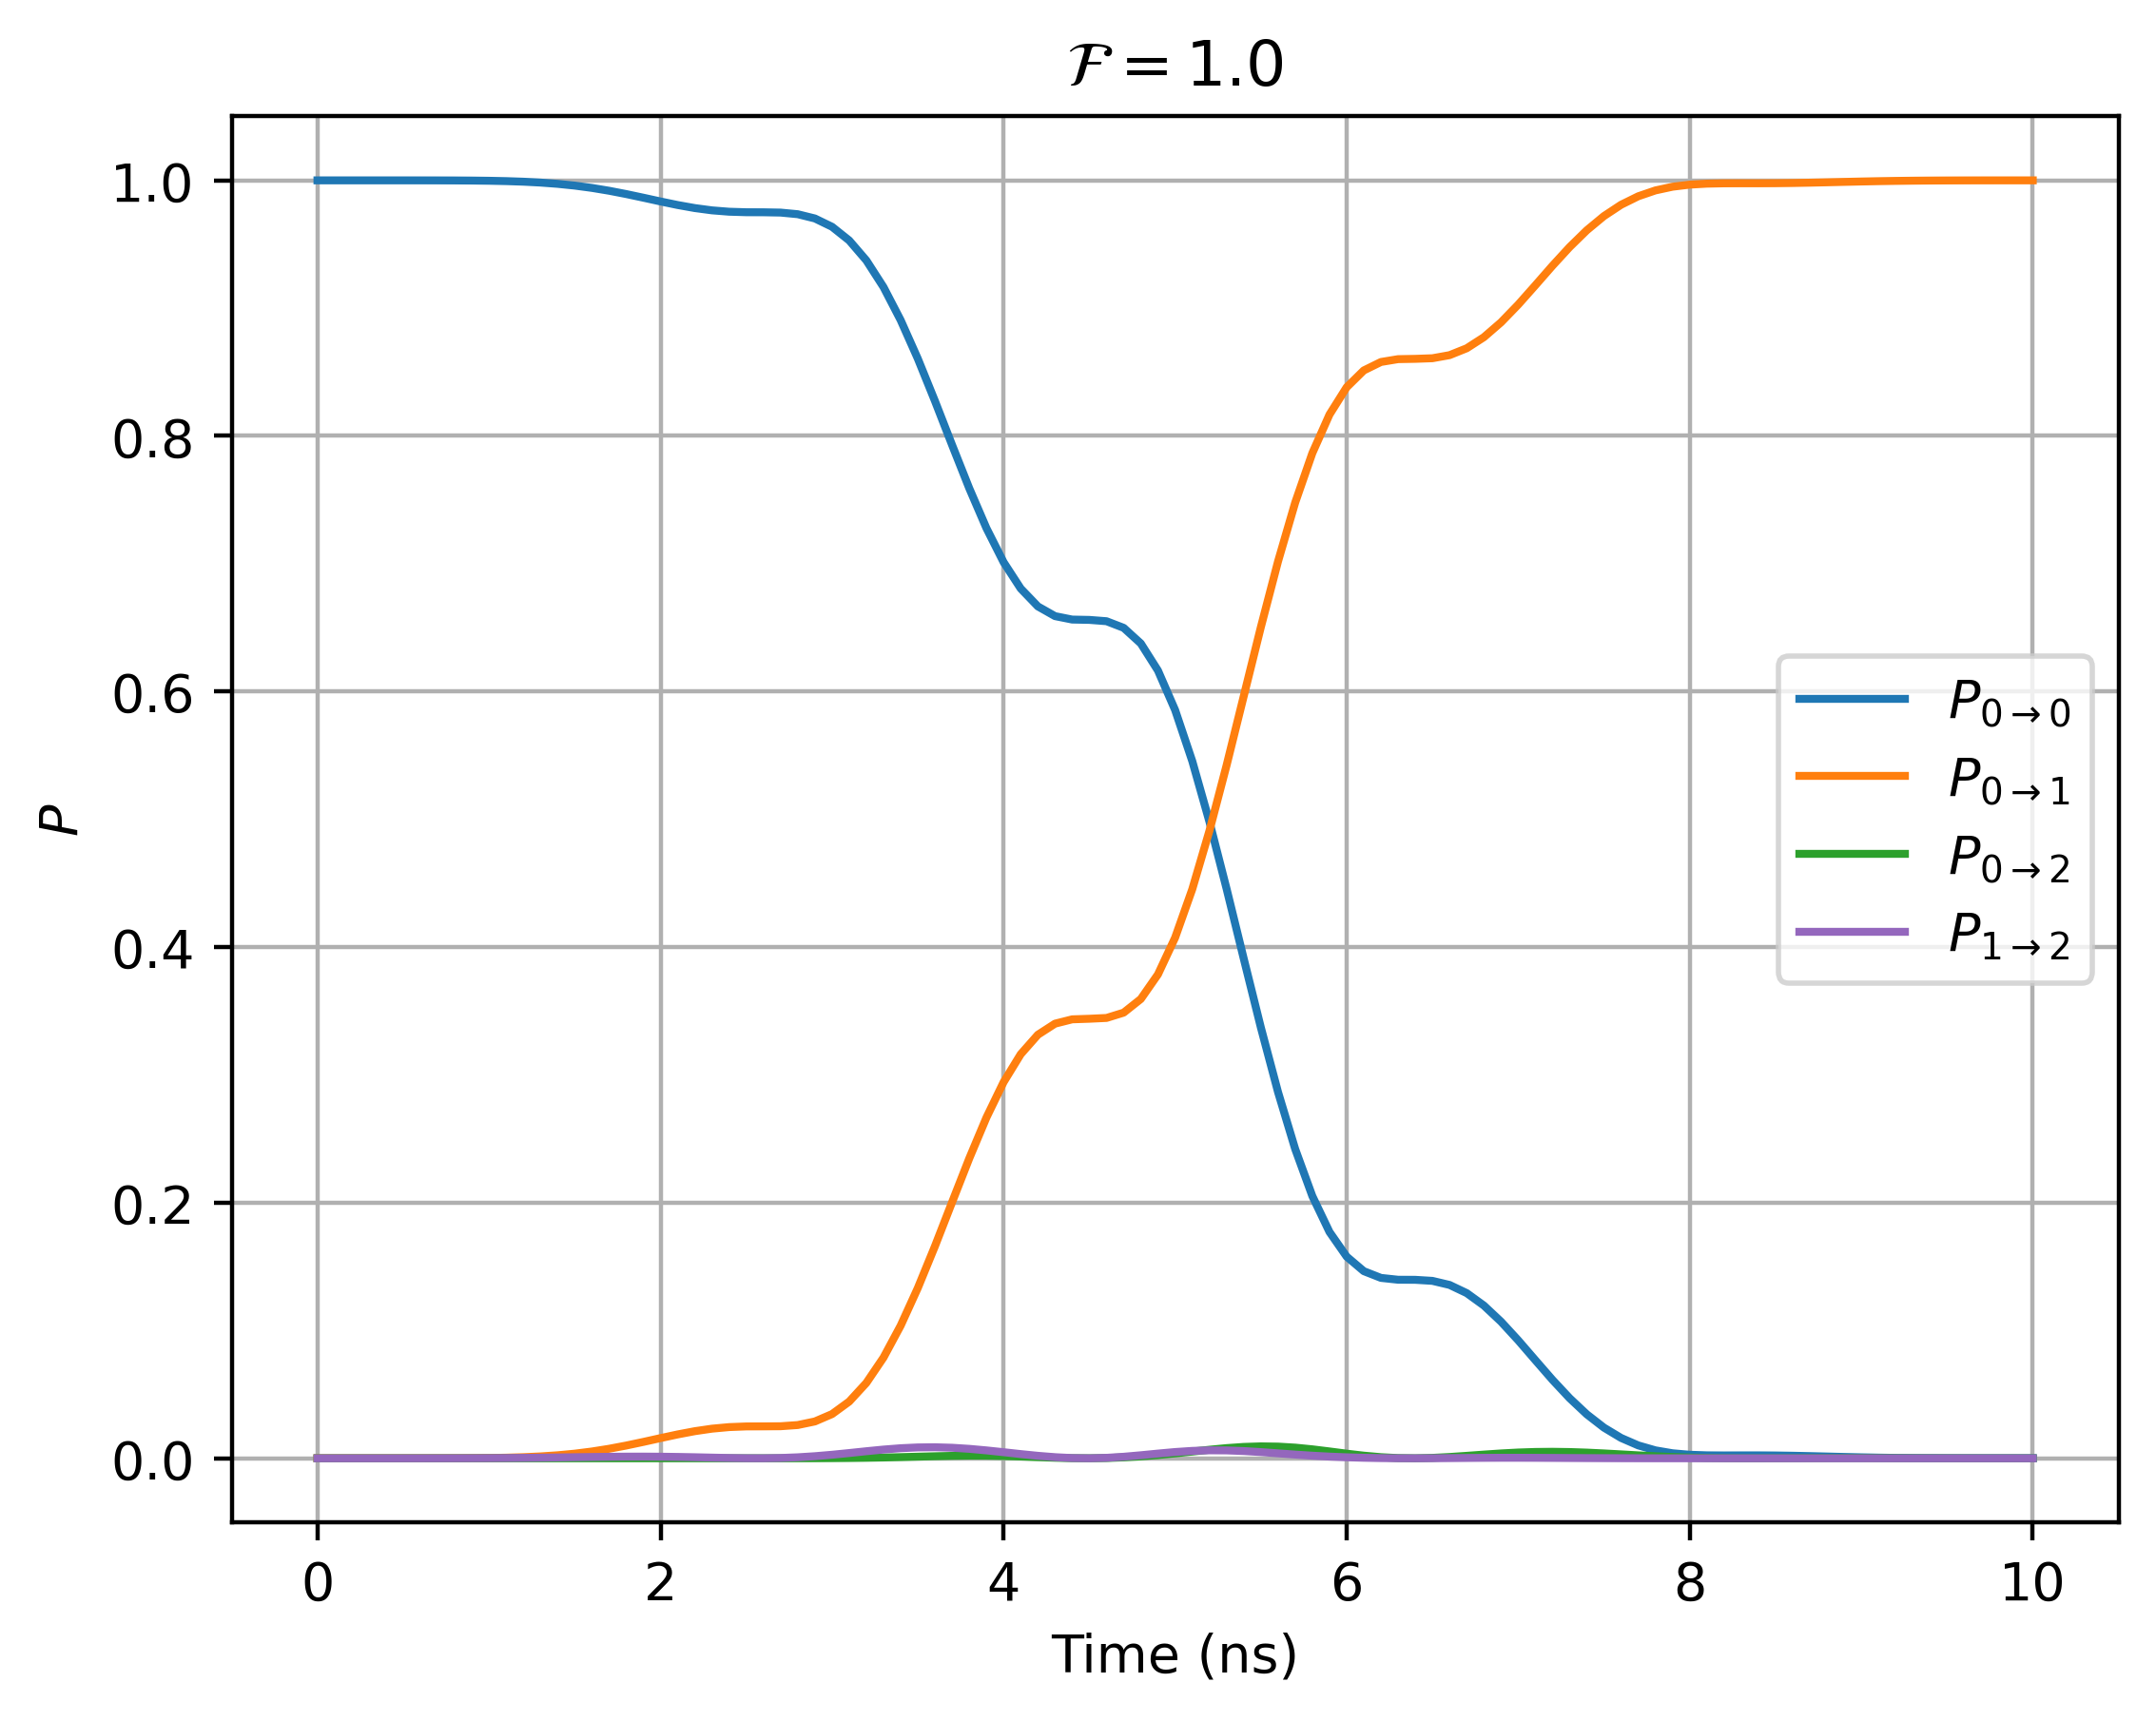

In [70]:
delta_omega_d=xopt.x[0]
drag_coeff = xopt.x[1]
drive_factor = xopt.x[2]
epsilon = drive_factor/matr_el
H_drive = epsilon*(qubit.n())
    
omega_d = qubit.freq(0,1) + delta_omega_d
U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(1-fidel)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
leakage_charge_corr = 1 - trans_prob_0 - trans_prob_1
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

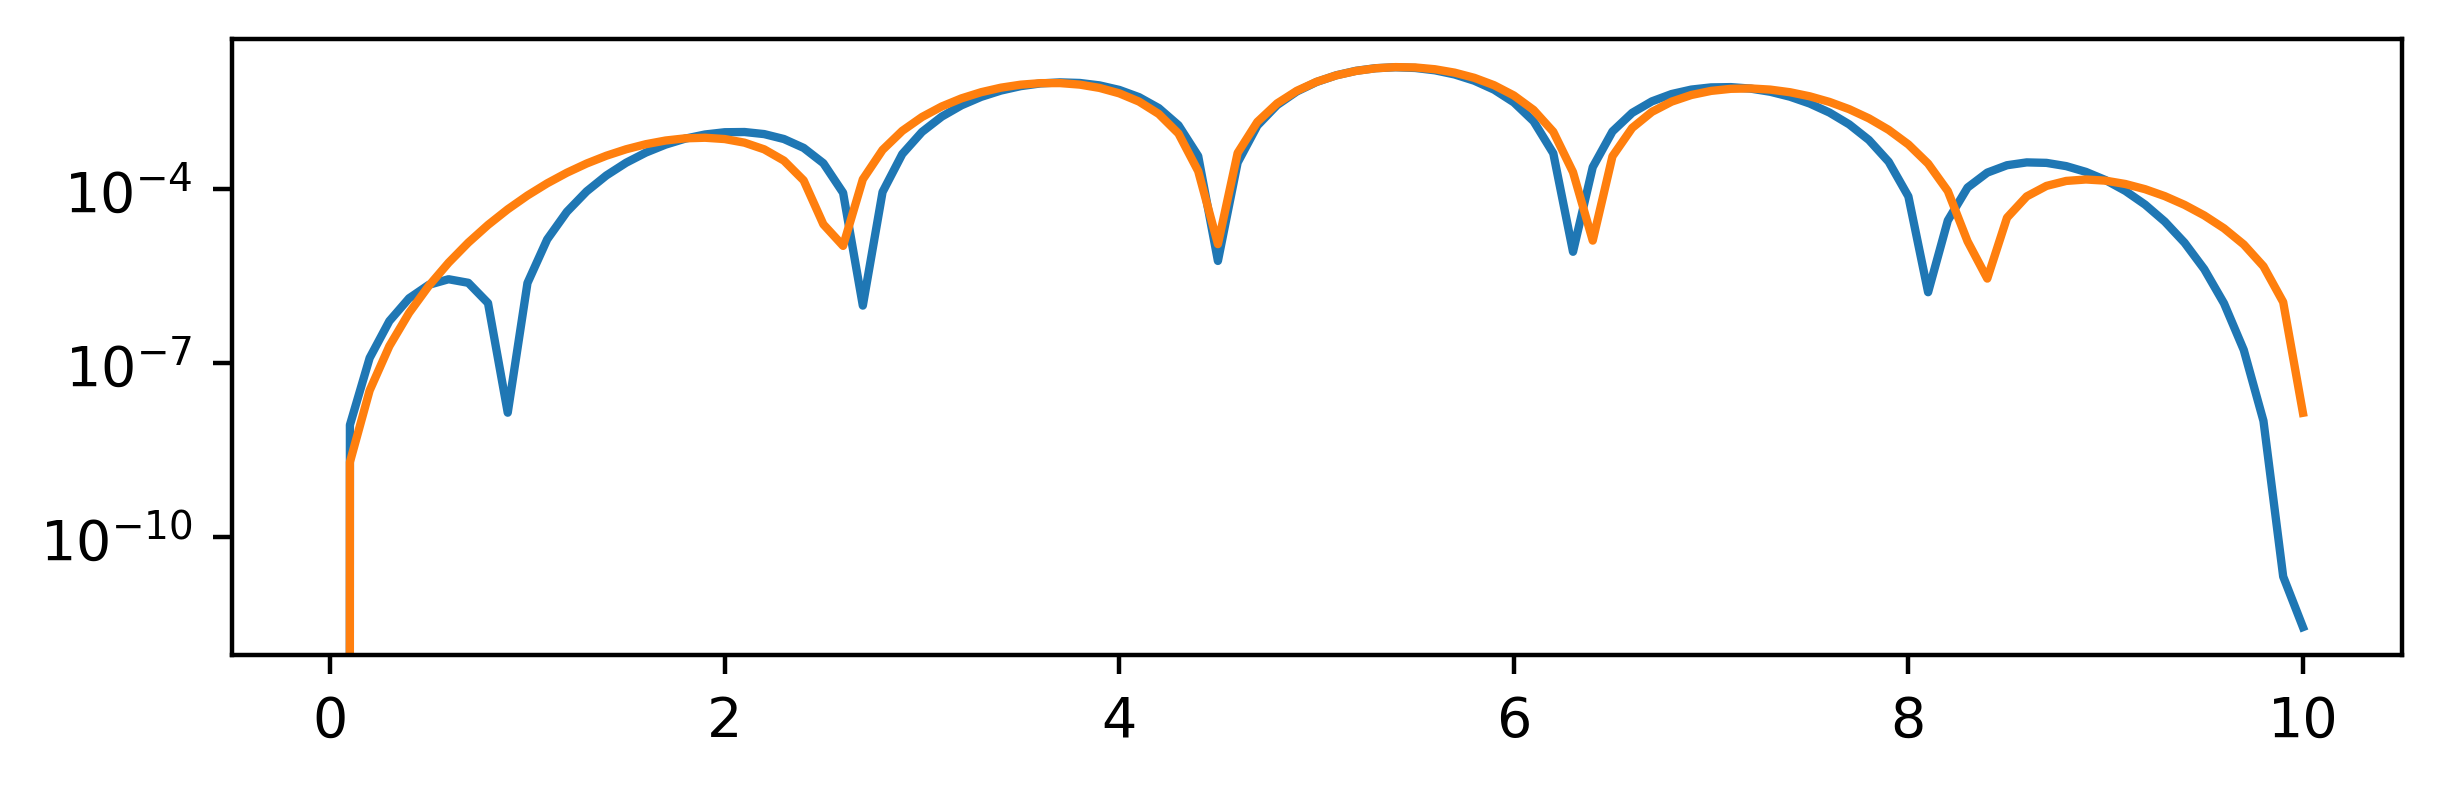

In [71]:
plt.figure(figsize = [7,2])
plt.plot(t_points, leakage_charge)
plt.plot(t_points, leakage_charge_corr)
plt.yscale('log')

In [72]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0
sz = np.real(expect(op.sigz(N=nlev_single),state_evol))
sx = np.real(expect(op.sigx(N=nlev_single),state_evol))
sy = np.real(expect(op.sigy(N=nlev_single),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.add_vectors([sx[-1], sy[-1], sz[-1]])
b.make_sphere()

### Check that $\pi/2$ pulses also work

In [73]:
## Check pi/2 pulses
delta_omega_d, drag_coeff = xopt.x
drive_amplitude_factor = 0.25
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
omega_d = qubit.freq(0,1) + delta_omega_d
t_points = np.linspace(0, T_gate, 20 * int(T_gate) + 1)

U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
        -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_ideal = ry(np.pi/2.0)
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0

trans_prob_0 = gates.prob_transition(U_nothing*U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_nothing*U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_nothing*U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_nothing*U_t, state_1, state_2)
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

ValueError: too many values to unpack (expected 2)

In [24]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(op.sigz(N=nlev_single),state_evol))
sx = np.real(expect(op.sigx(N=nlev_single),state_evol))
sy = np.real(expect(op.sigy(N=nlev_single),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.add_vectors([sx[-1], sy[-1], sz[-1]])
b.make_sphere()

### PTM

C:\Users\QEDLiu\AppData\Local\Temp\ipykernel_8868\2390456143.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real = np.linalg.lstsq(p_out, p_in)[0]


(<Figure size 3200x2400 with 2 Axes>, <Axes: >)

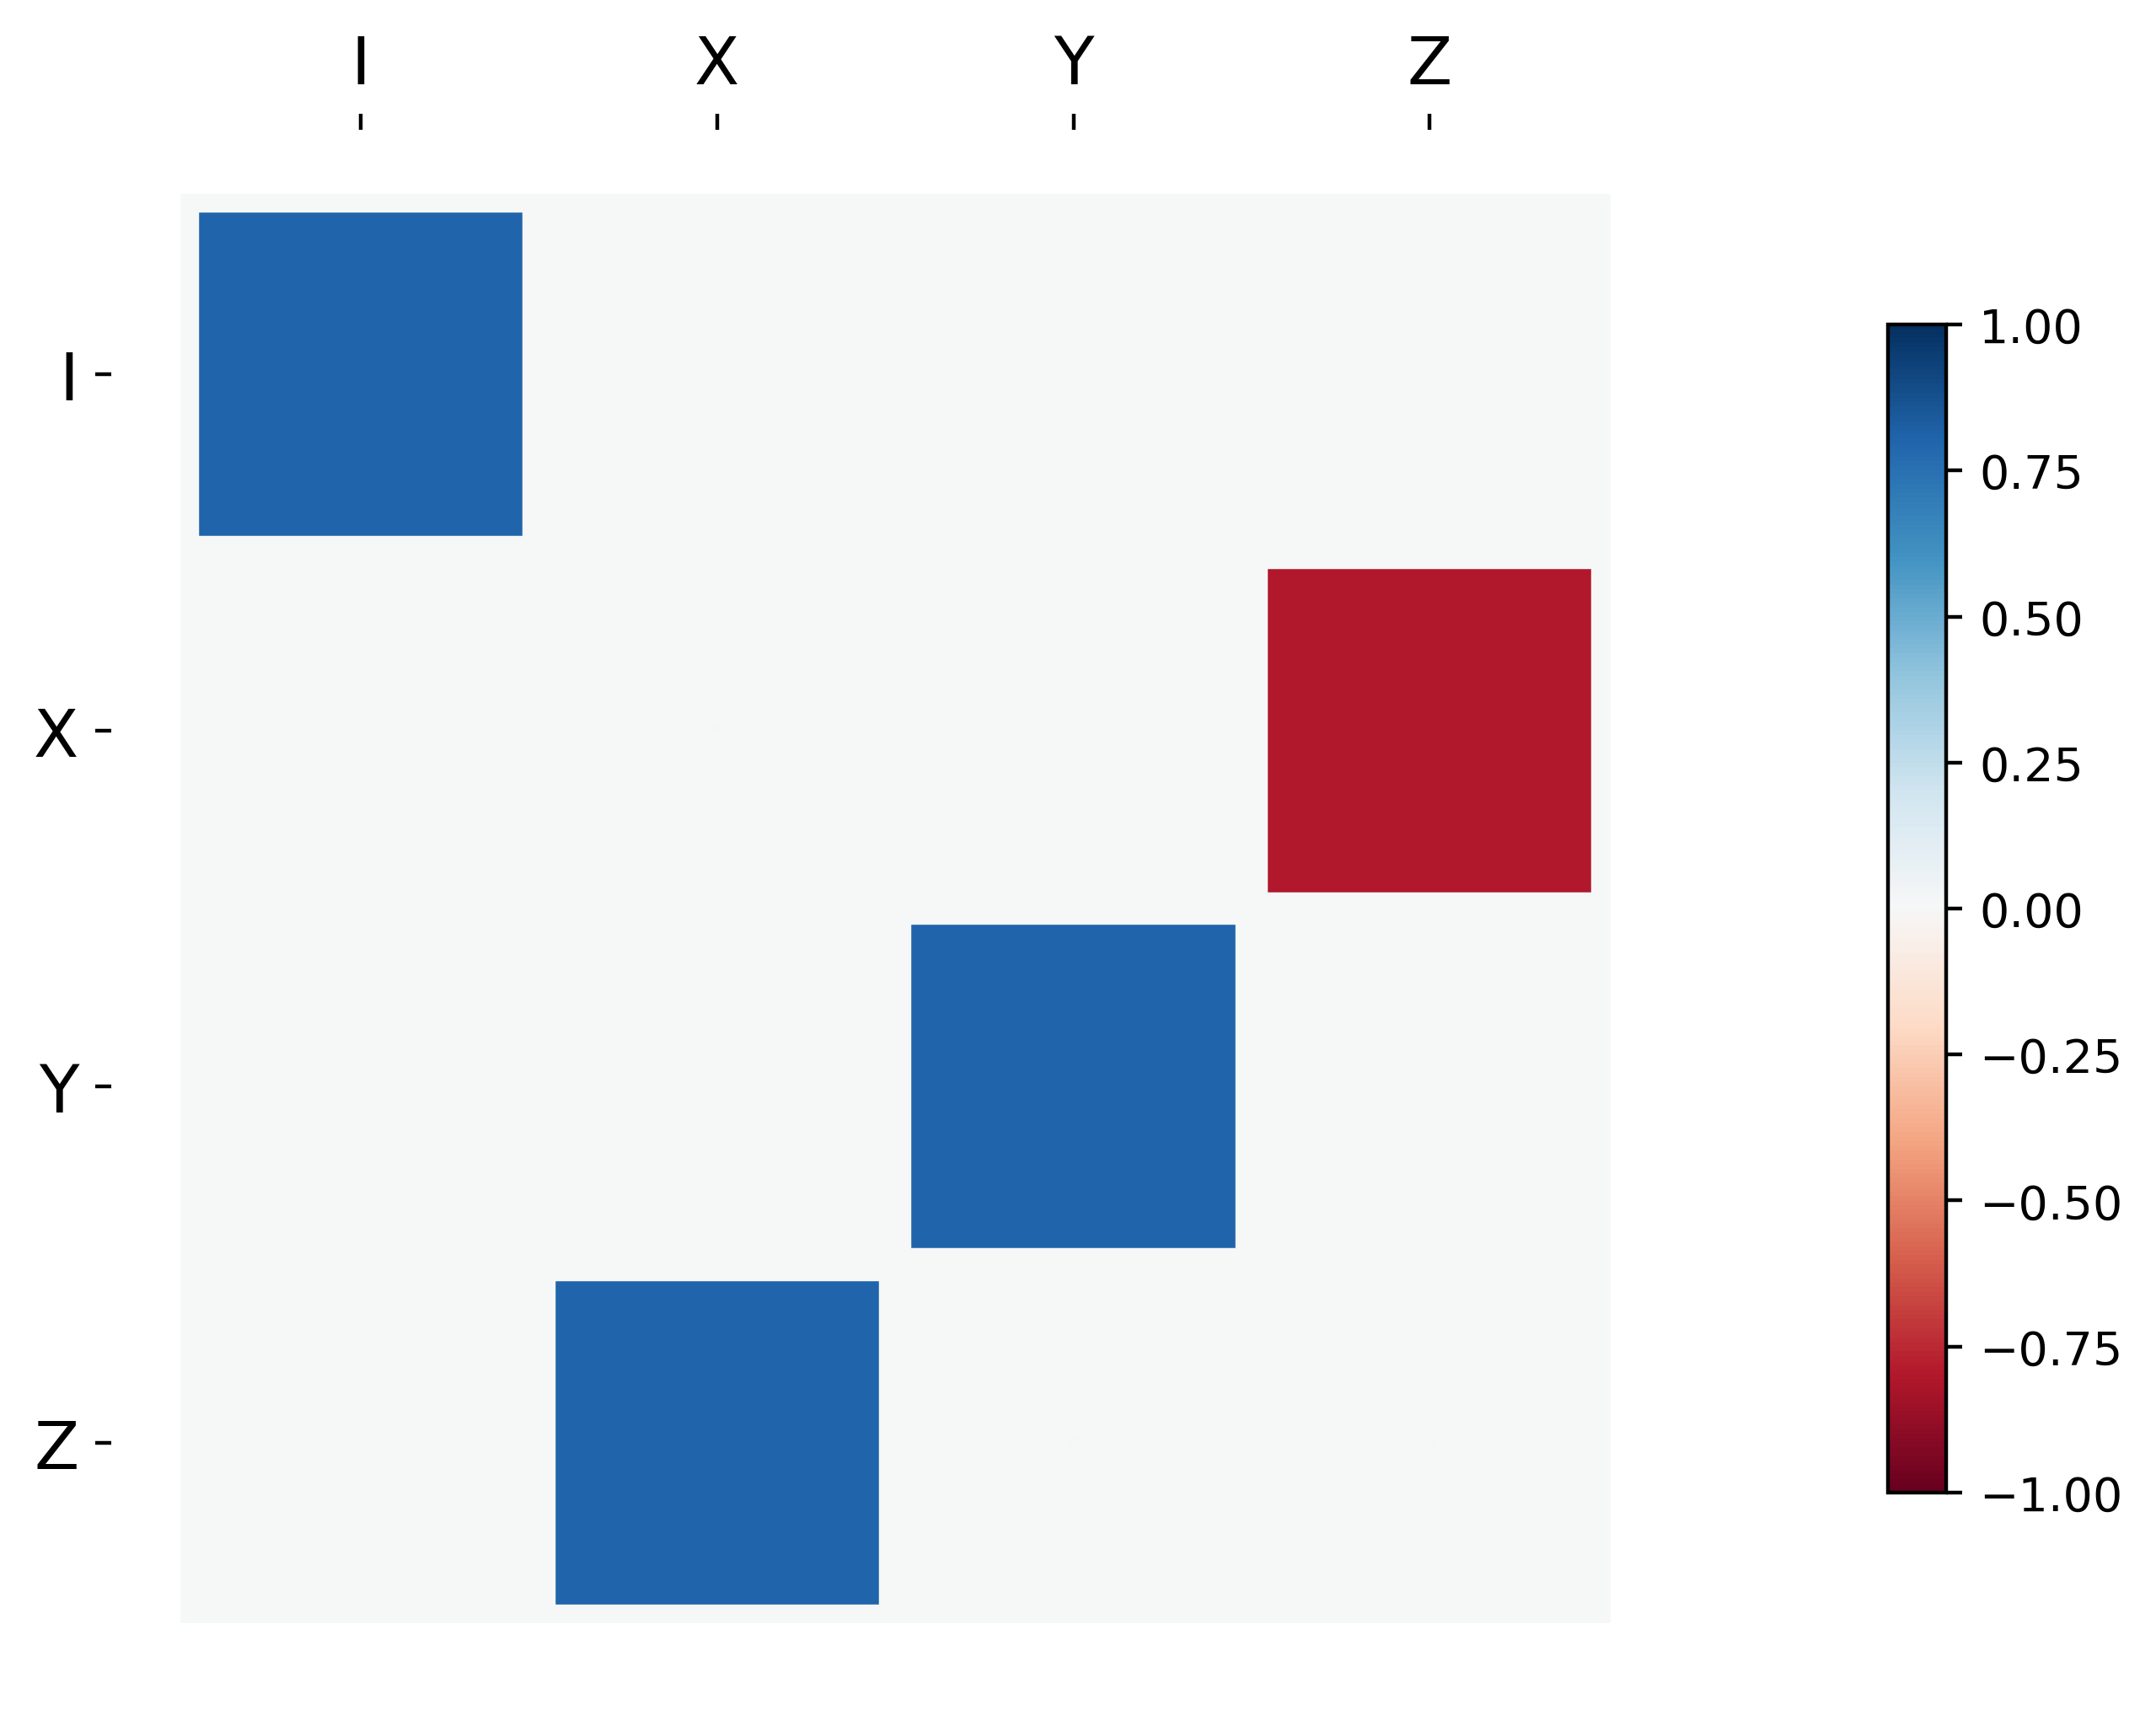

In [25]:
#Using propagator
drive_amplitude_factor = 0.25
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

prep_ops = [qeye(nlev_single), op.sx(phi=np.pi/2, N=nlev_single), op.sy(phi=-np.pi/2, N=nlev_single), op.sigx(N=nlev_single)]
meas_ops = [qeye(nlev_single), op.sigx(N=nlev_single), op.sigy(N=nlev_single), op.sigz(N=nlev_single)]
p_in = np.zeros((4,4), dtype = complex)
p_out = np.zeros((4,4), dtype = complex)

U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
    -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    
for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    state_evol =  U_nothing*U_t * psi_ini
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = (expect(meas, psi_ini))
        p_out[i,j] = (expect(meas, state_evol[-1]))
ptm_real = np.linalg.lstsq(p_out, p_in)[0]
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)

C:\Users\QEDLiu\AppData\Local\Temp\ipykernel_8868\545510972.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real = Qobj(np.linalg.lstsq(p_out, p_in)[0])


(<Figure size 3200x2400 with 2 Axes>, <Axes: >)

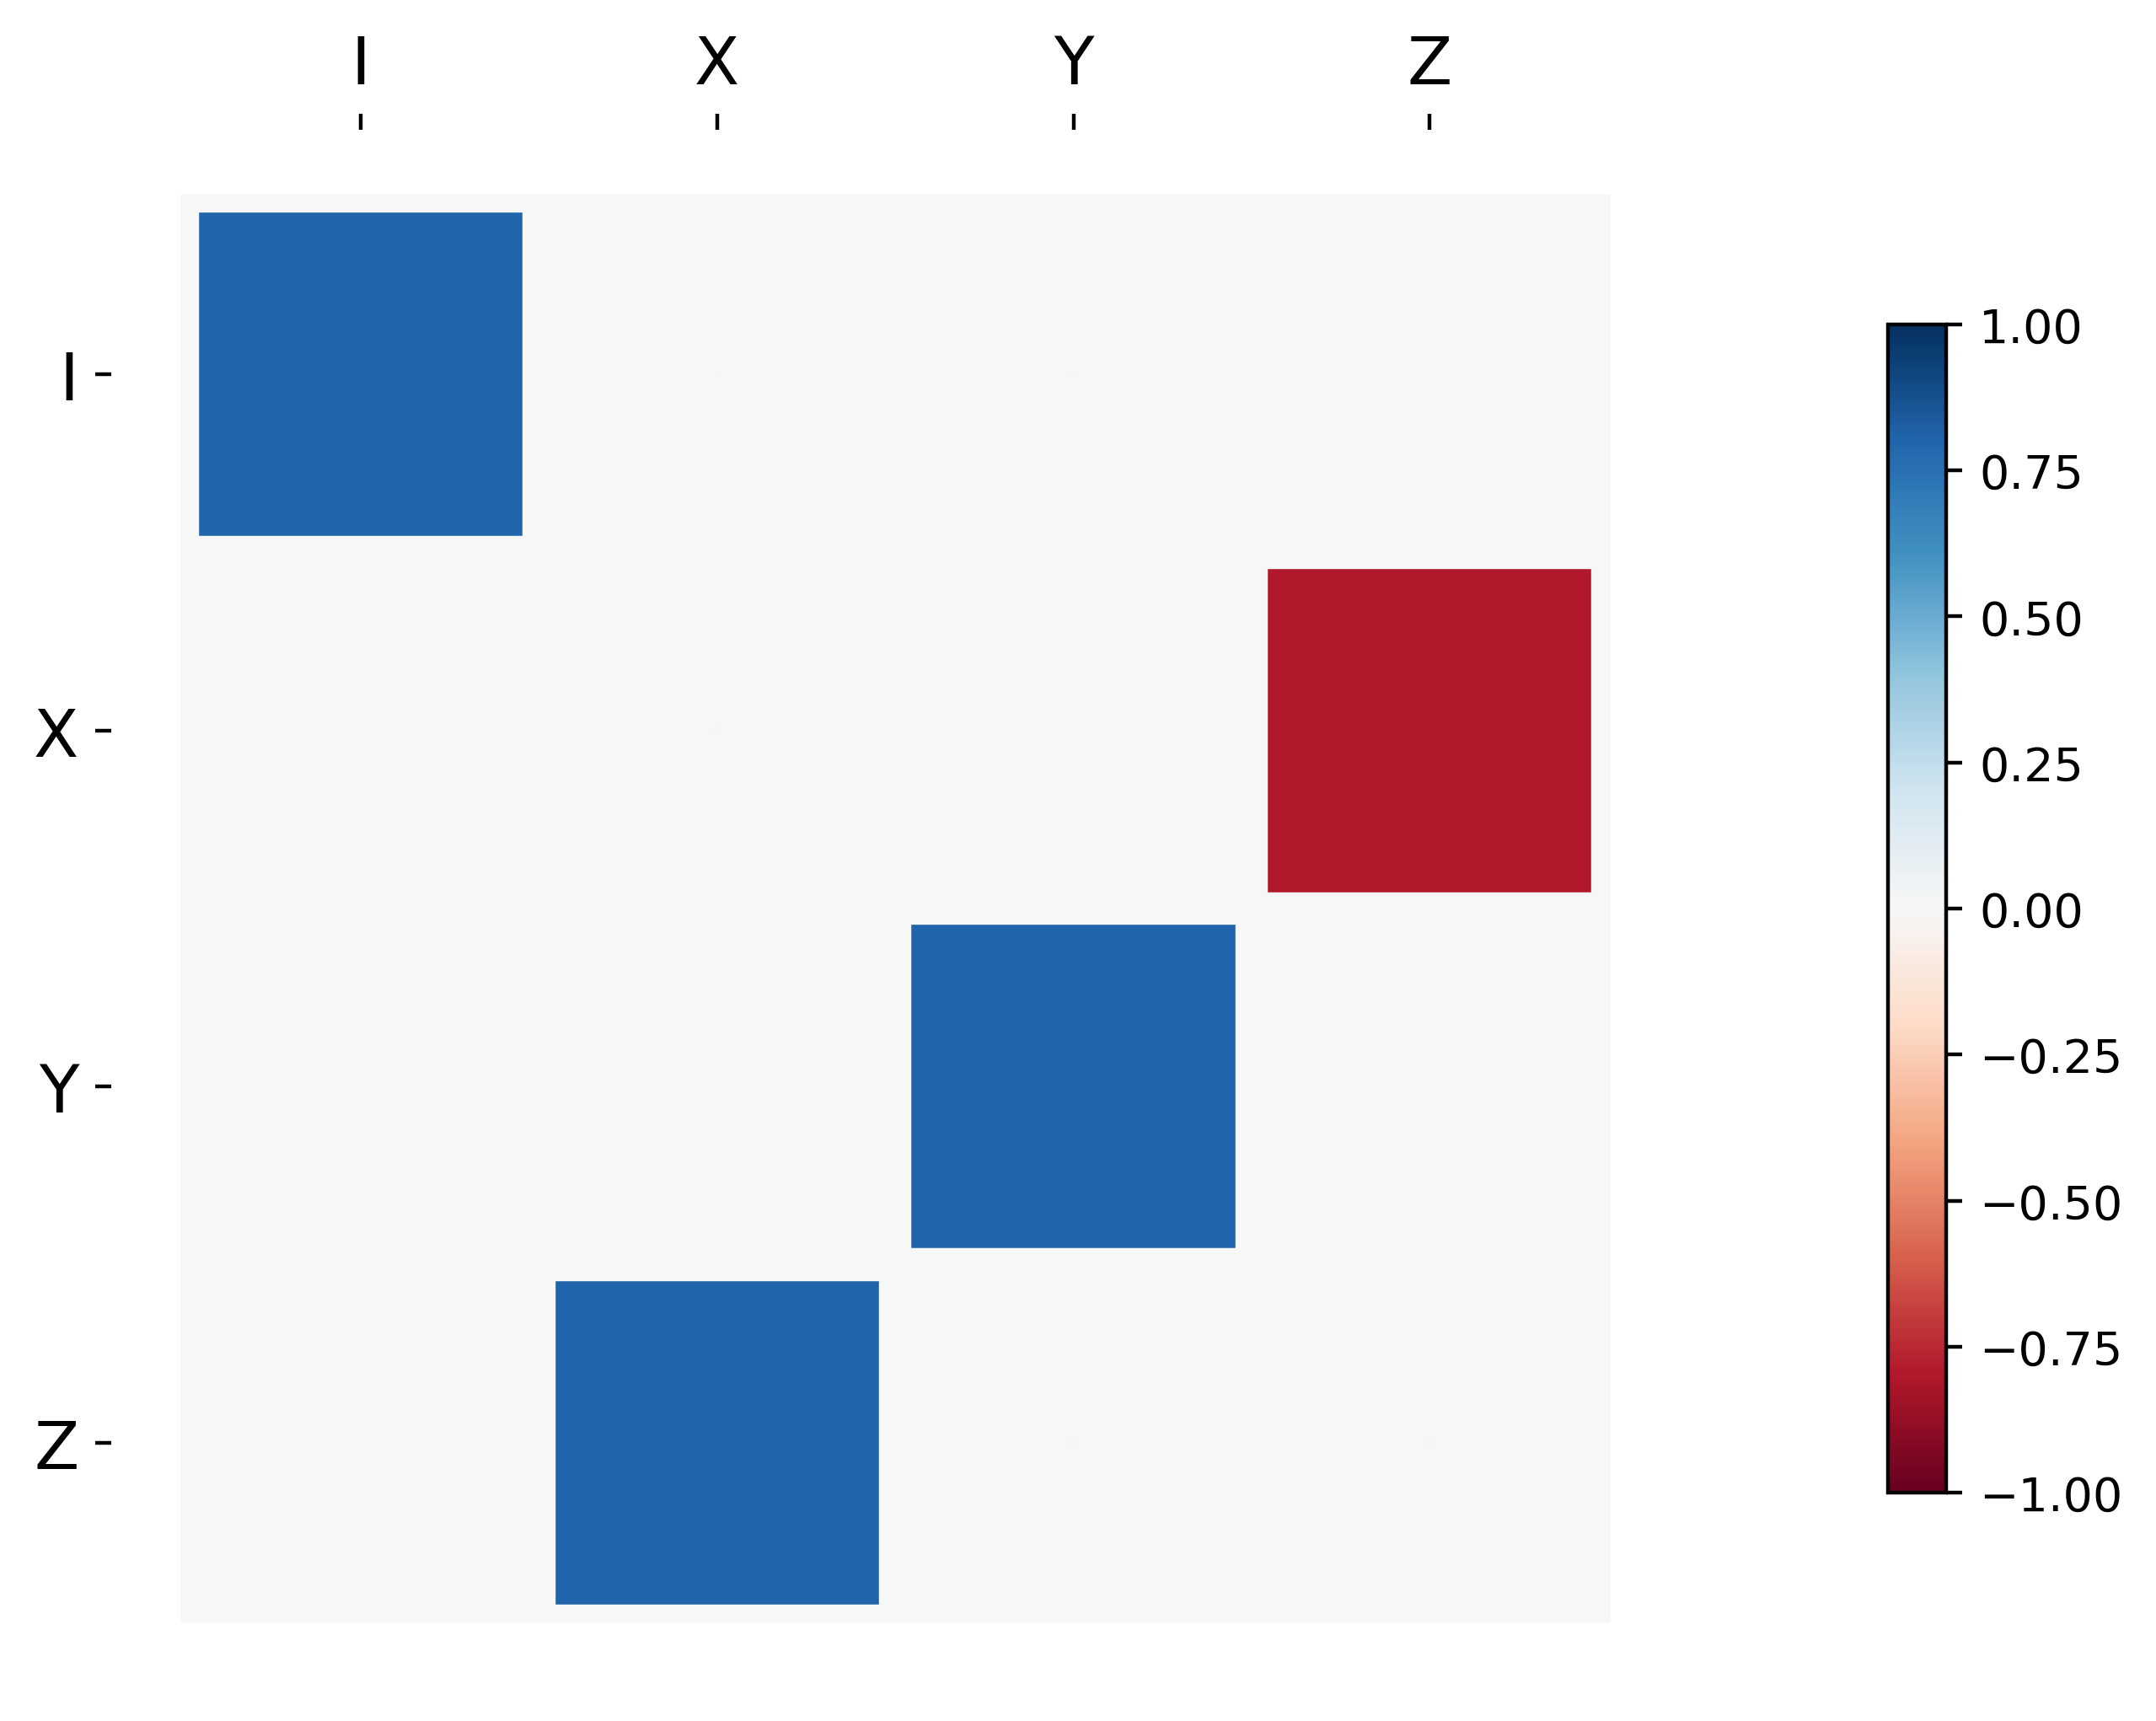

In [26]:
# Using master equation for states
drive_amplitude_factor = 0.25
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

prep_ops = [qeye(nlev_single), op.sx(phi=np.pi/2, N=nlev_single), op.sy(phi=-np.pi/2, N=nlev_single), op.sigx(N=nlev_single)]
meas_ops = [qeye(nlev_single), op.sigx(N=nlev_single), op.sigy(N=nlev_single), op.sigz(N=nlev_single)]
p_in = np.zeros((4,4), dtype = complex)
p_out = np.zeros((4,4), dtype = complex)
for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    evol_states0 = gates.evolution_psi_microwave(qubit.H(), H_drive, psi0 = psi_ini, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    evol_states1 = gates.evolution_psi_microwave(qubit.H(), H_drive, psi0 = U_nothing[-1]*evol_states0[-1], t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    evol_states2 = gates.evolution_psi_microwave(qubit.H(), H_drive, psi0 = U_nothing[-1]*evol_states1[-1], t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = (expect(meas, psi_ini))
        p_out[i,j] = (expect(meas, U_nothing[-1]*evol_states0[-1]))

ptm_real = Qobj(np.linalg.lstsq(p_out, p_in)[0])        
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)

C:\Users\QEDLiu\AppData\Local\Temp\ipykernel_8868\152460781.py:3: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  sx2 = rx(np.pi/2)
C:\Users\QEDLiu\AppData\Local\Temp\ipykernel_8868\152460781.py:4: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  sy2 = ry(np.pi/2)
C:\Users\QEDLiu\AppData\Local\Temp\ipykernel_8868\152460781.py:8: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  gate

0.33333415946035255


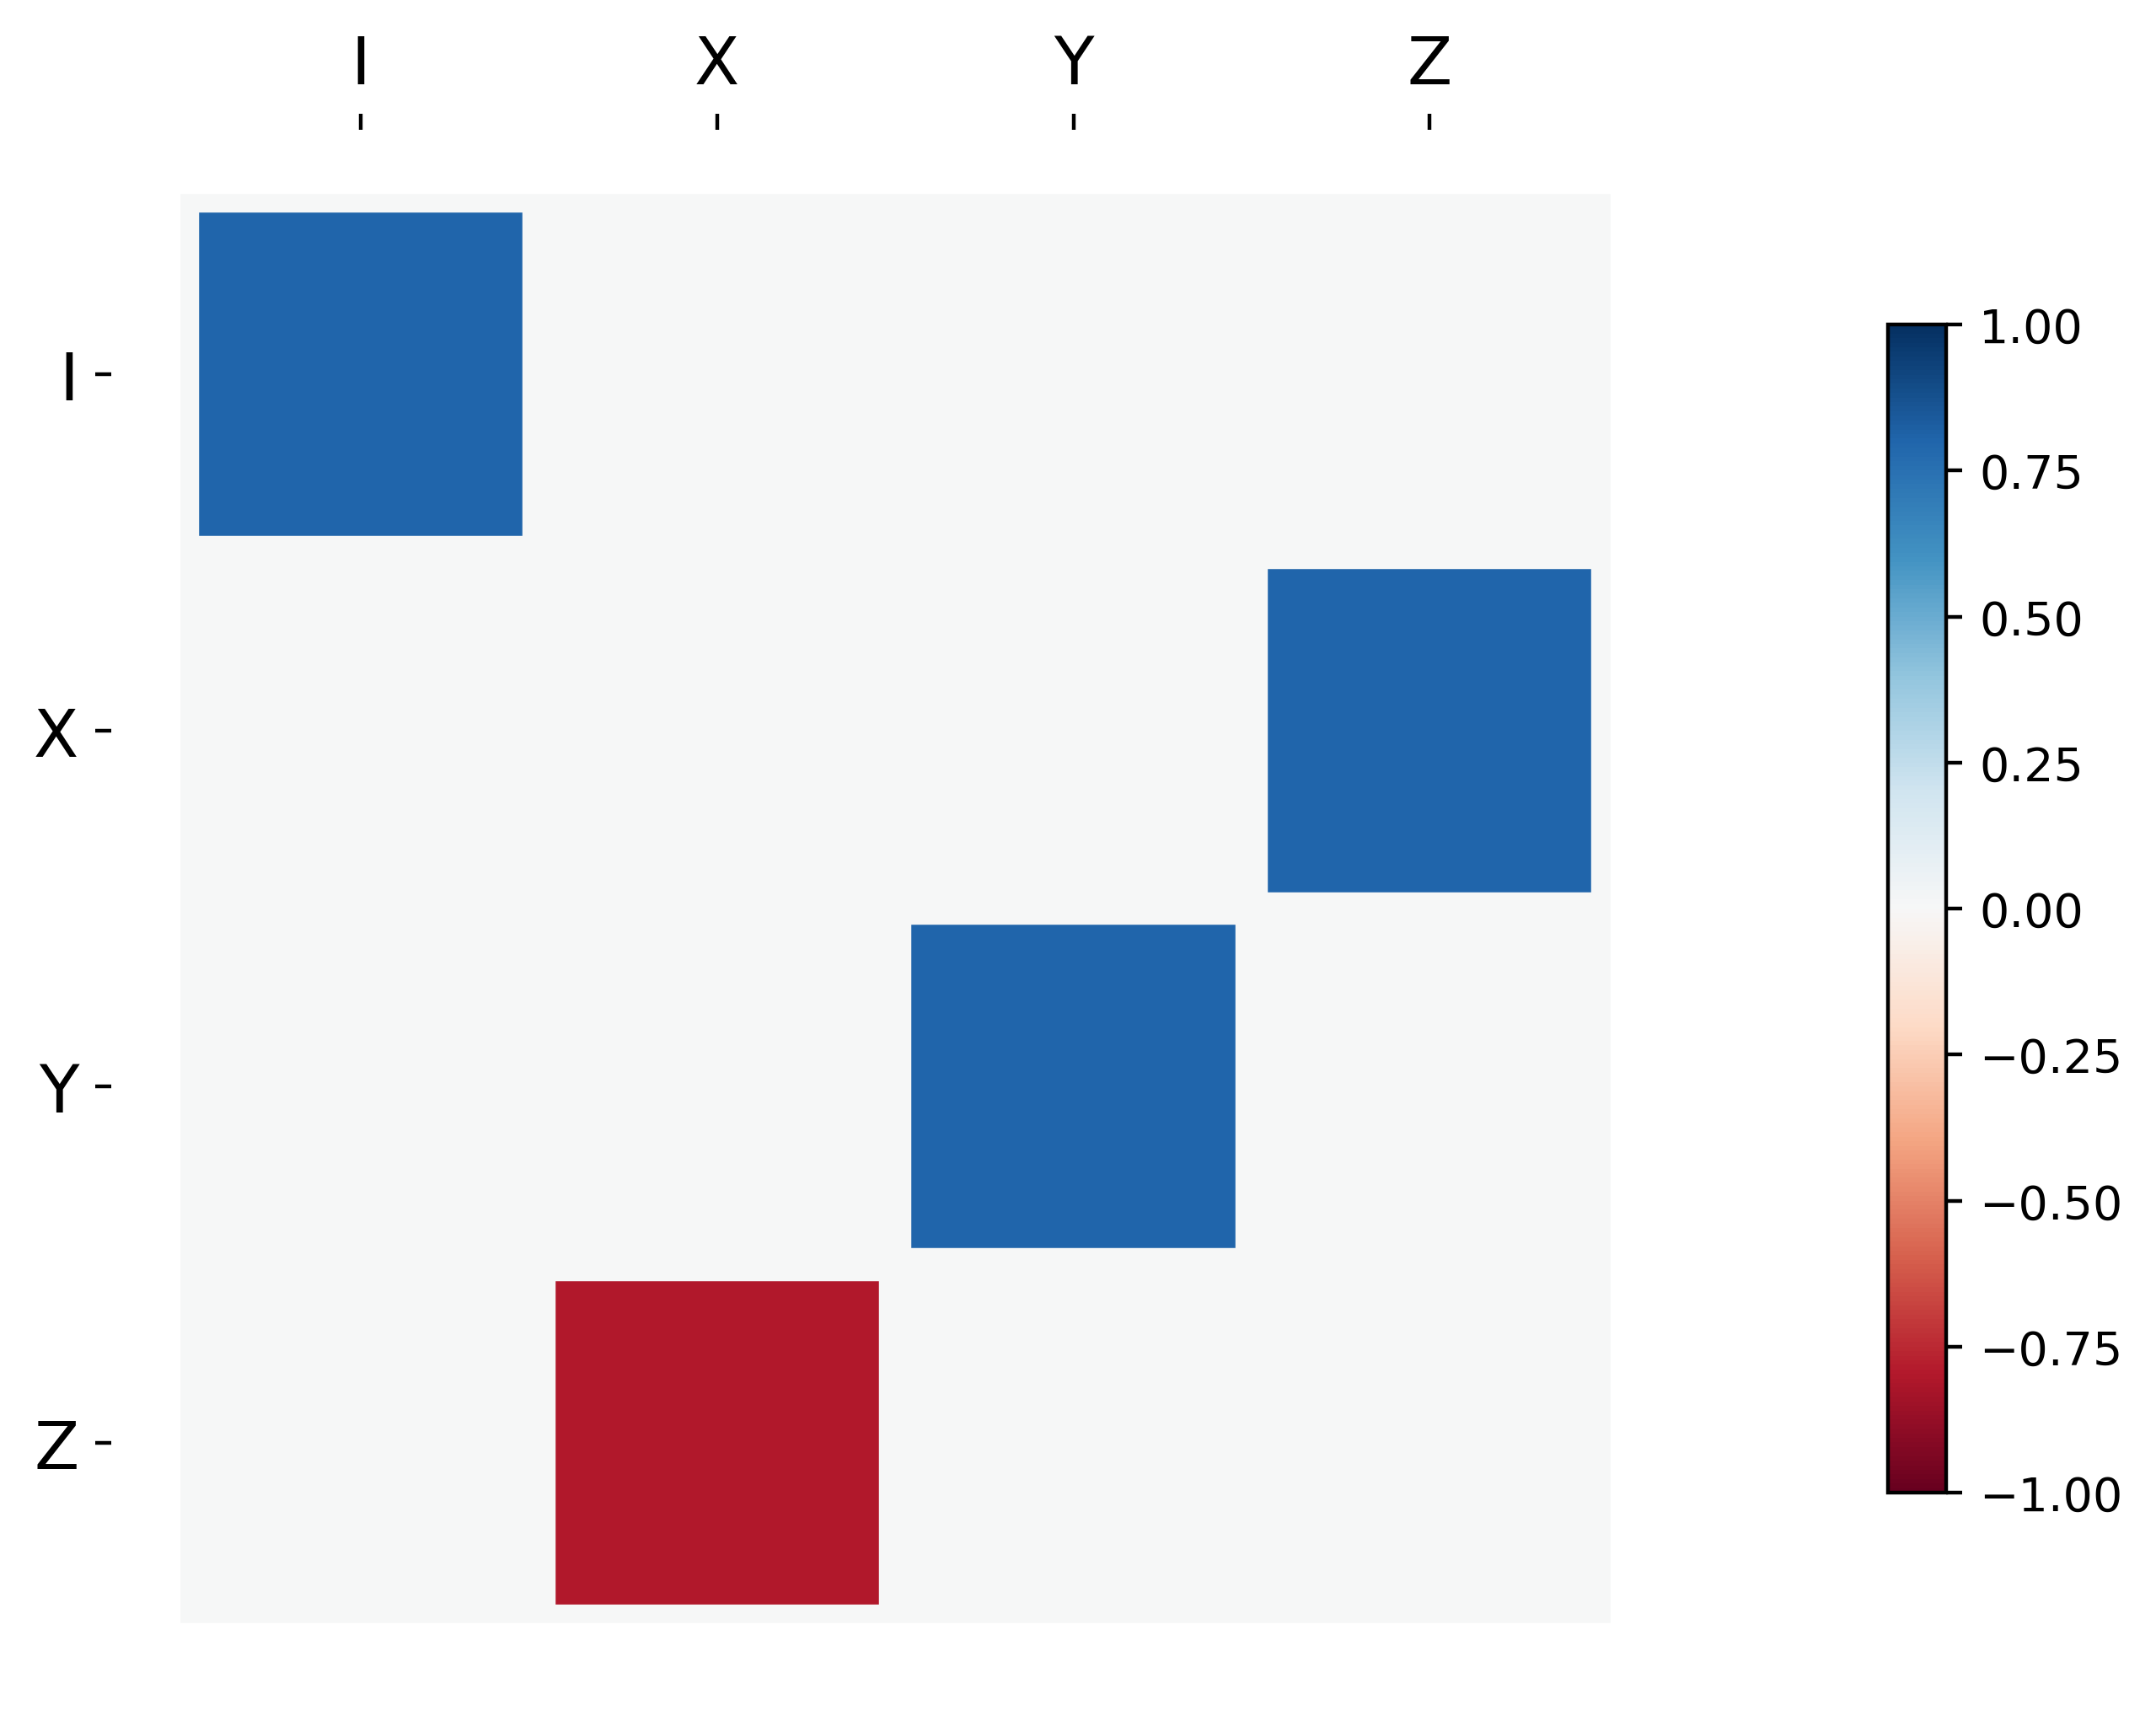

In [27]:
# Two-level system ideal PTM
I = qeye(2)
sx2 = rx(np.pi/2)
sy2 = ry(np.pi/2)
p_in = np.zeros((4,4))
p_out = np.zeros((4,4))

gate = ry(np.pi/2)

prep_rotations = [I, sigmax(), sx2, sy2]
meas_rotations = [I, sigmax(), sigmay(), sigmaz()]
for i, prep in enumerate(prep_rotations):
    psi_ini = prep*basis(2,0)
    for j, meas in enumerate(meas_rotations):
        p_in[i,j] = expect(meas, psi_ini)
        p_out[i,j] = expect(meas, gate*psi_ini)
        
ptm_ideal = Qobj(np.linalg.lstsq(p_out, p_in)[0])
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_ideal, xlabels = op_label, ylabels = op_label)
ptm_real = Qobj(ptm_real)

d = 2
process_fidelity = ((ptm_real.dag()*ptm_ideal).tr() + d)/(d**2+d)
print (process_fidelity)

In [28]:
#introducing decoherence
#List of collapse operators
gamma1_01 = (50e6)**-1.0
gamma2_01 = (5e3)**-1.0
L1_01 = np.sqrt(gamma1_01)*state_0*state_1.dag()
L2_01 = np.sqrt(2*gamma2_01)*state_1*state_1.dag()

gamma1_02 = (53e3)**-1
gamma2_02 = (52e3)**-1
L1_02 = np.sqrt(gamma1_02)*state_0*state_2.dag()
L2_02 = np.sqrt(2*gamma2_02)*state_2*state_2.dag()

gamma1_13 = (58e3)**-1
gamma2_13 = (33e3)**-1
L1_13 = np.sqrt(gamma1_13)*state_1*state_3.dag()
L2_13 = np.sqrt(2*gamma2_13)*state_3*state_3.dag()

gamma1_23 = (306e3)**-1
gamma2_23 = (7e3)**-1
L1_23 = np.sqrt(gamma1_23)*state_2*state_3.dag()
L2_23 = np.sqrt(2*gamma2_23)*state_3*state_3.dag()

gamma1_12 = (786e3)**-1
gamma2_12 = (6e3)**-1
L1_12 = np.sqrt(gamma1_12)*state_1*state_2.dag()
L2_12 = np.sqrt(2*gamma2_12)*state_2*state_2.dag()

gamma1_03 = (697e3)**-1
gamma2_03 = (6e3)**-1
L1_03 = np.sqrt(gamma1_03)*state_0*state_3.dag()
L2_03 = np.sqrt(2*gamma2_03)*state_3*state_3.dag()

c_ops = [L1_01,L2_01, L1_02,L2_02, L1_13,L2_13, L1_23,L2_23, L1_12,L2_12, L1_03,L2_03]

C:\Users\QEDLiu\AppData\Local\Temp\ipykernel_8868\2859516028.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real = Qobj(np.linalg.lstsq(p_out, p_in)[0])


(<Figure size 3200x2400 with 2 Axes>, <Axes: >)

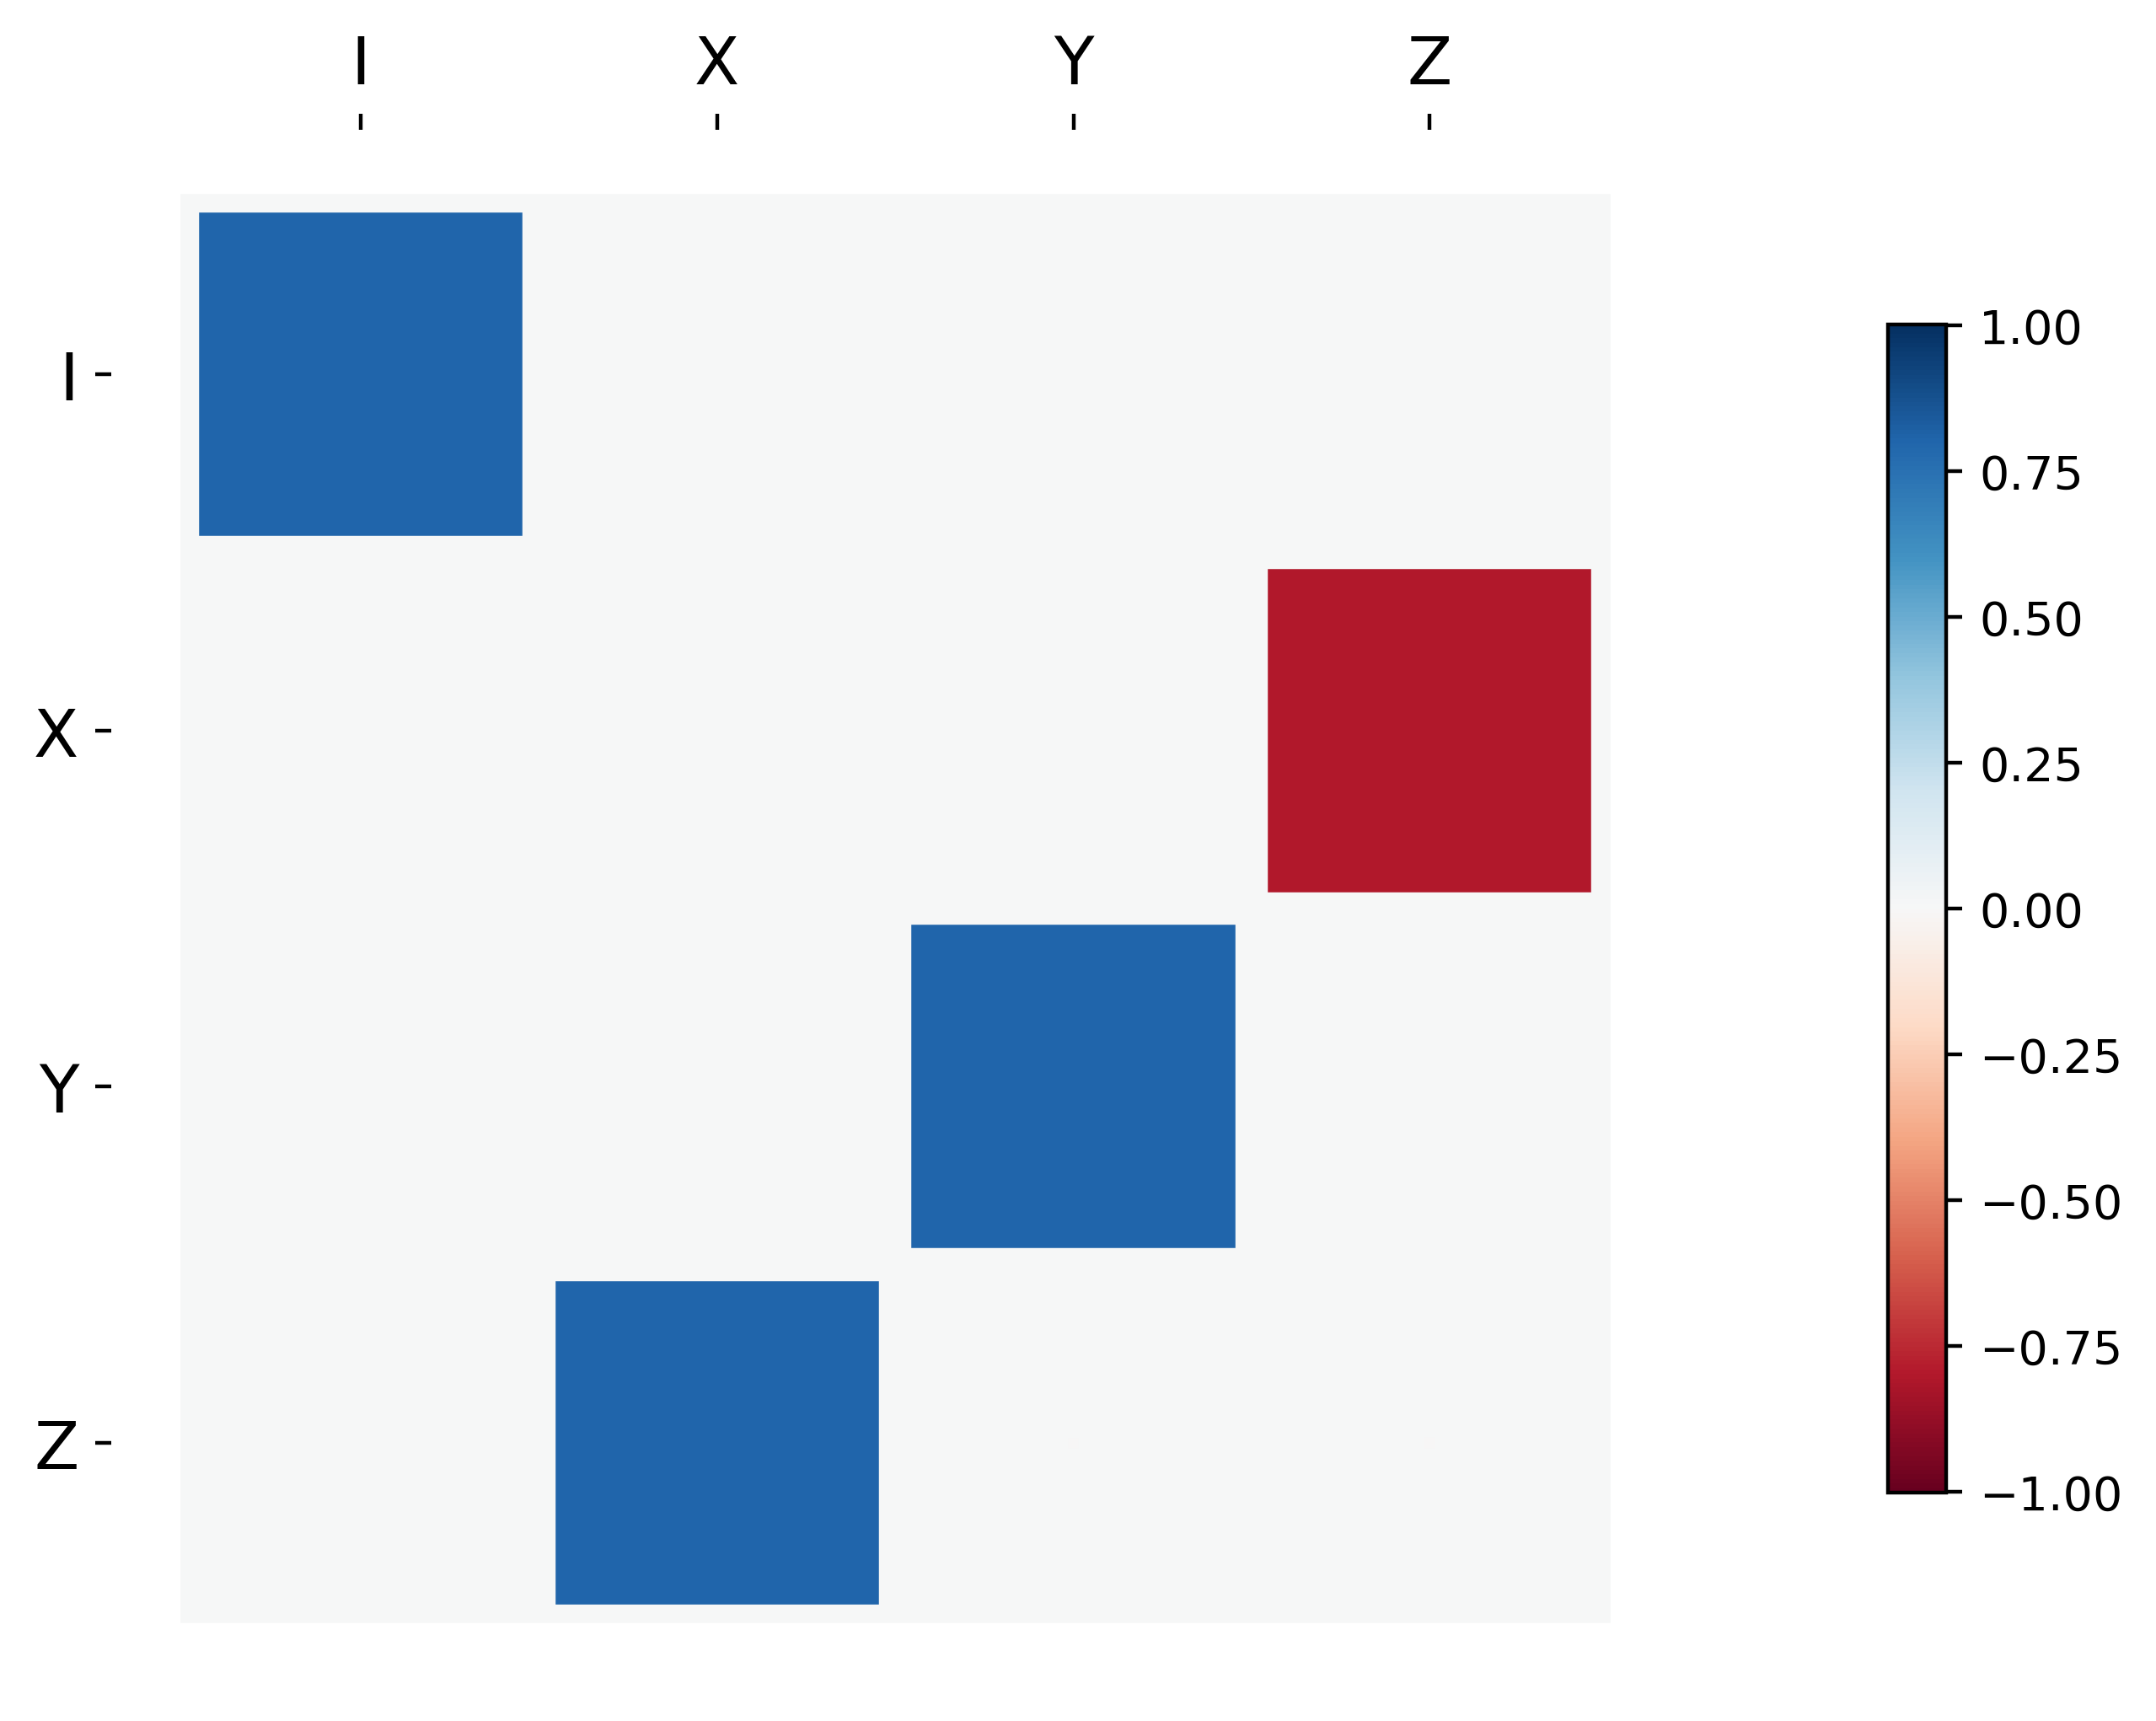

In [29]:
# Using master equation for states
drive_amplitude_factor = 0.25
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

prep_ops = [qeye(nlev_single), op.sx(phi=np.pi/2, N=nlev_single), op.sy(phi=-np.pi/2, N=nlev_single), op.sigx(N=nlev_single)]
meas_ops = [qeye(nlev_single), op.sigx(N=nlev_single), op.sigy(N=nlev_single), op.sigz(N=nlev_single)]
p_in = np.zeros((4,4), dtype = complex)
p_out = np.zeros((4,4), dtype = complex)
for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    evol_states = gates.evolution_psi_microwave_diss(qubit.H(), H_drive, psi0 = psi_ini, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d, c_ops = c_ops)
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = (expect(meas, psi_ini))
        p_out[i,j] = (expect(meas, U_nothing[-1]*evol_states[-1]*U_nothing[-1].dag()))

ptm_real = Qobj(np.linalg.lstsq(p_out, p_in)[0])        
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)

### Sweeping gate time

In [75]:
#Gate parameter
T_gate_array = np.linspace(5,25,6) #ns
error_array_charge = np.zeros_like(T_gate_array)
drag_coeff_array = np.zeros_like(T_gate_array)
delta_omega_d_array = np.zeros_like(T_gate_array)
leakage_array_charge = np.zeros_like(T_gate_array)

drive_amplitude_factor = 0.5
U_ideal = sigmay()

shape = 'cos'
sigma = 0.25
drag = True
drag_coeff = 0.0
delta_omega_d = 0

for T_idx, T_gate in enumerate(T_gate_array):
  
    t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
    delta_omega_d = 0
    drag_coeff = 0
    drive_factor = 0.5
    U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    def infidelity(x):
        delta_omega_d = x[0]
        drag_coeff = x[1]
        drive_factor = x[2]
        epsilon = drive_factor/matr_el
        H_drive = epsilon*(qubit.n())
        omega_d = qubit.freq(0,1) + delta_omega_d
        U_t = gates.evolution_operator_microwave(
                    qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
        U_real = U_nothing[-1]*U_t[-1]
        U_real = Qobj(U_real[0:2, 0:2])

        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
        return 1-fidel   
    
    x0 = [0,0, 0.5]
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-8)
    
    error_array_charge[T_idx] = infidelity(xopt.x)
    drag_coeff_array[T_idx] = xopt.x[1]
    delta_omega_d_array[T_idx] = xopt.x[0]
    
    delta_omega_d = xopt.x[0]
    drag_coeff = xopt.x[1]
    drive_factor = xopt.x[2]
    epsilon = drive_factor/matr_el
    H_drive = epsilon*(qubit.n())
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                    qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)    
    trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
    trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
    leakage_array_charge[T_idx] = 1 - trans_prob_0[-1] - trans_prob_1[-1]

Text(0.5, 0, '$\\tau_g$ (ns)')

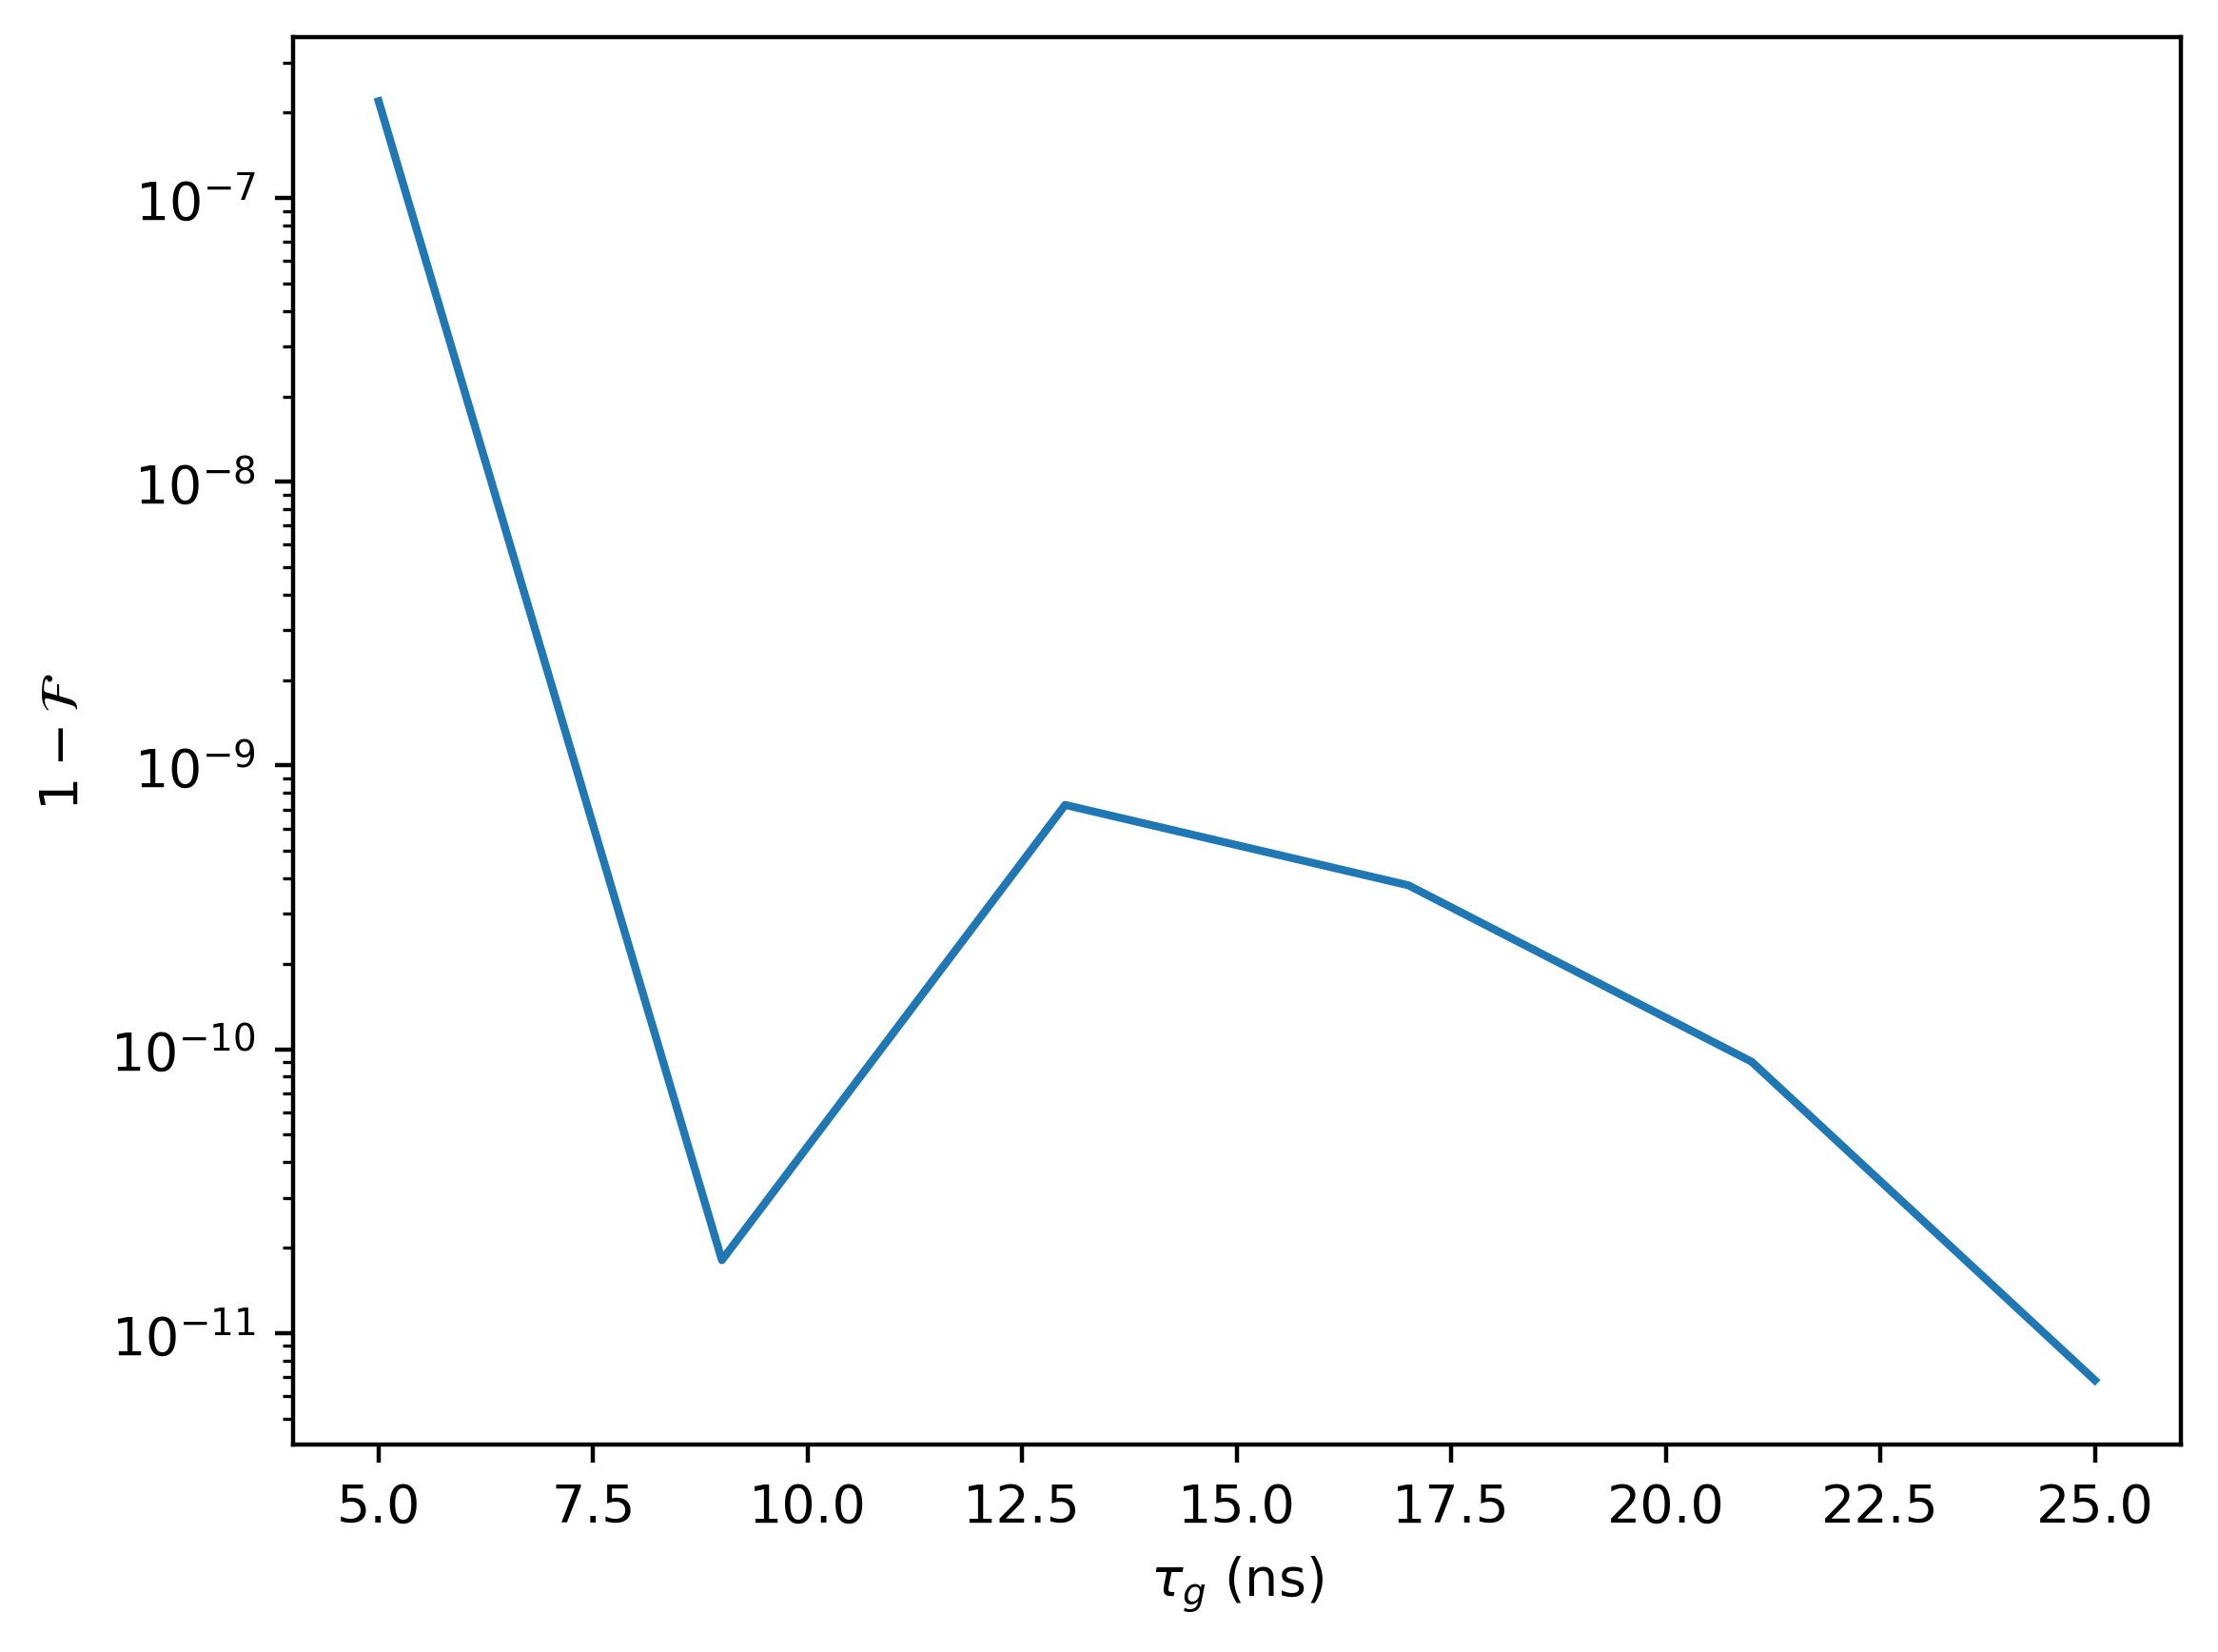

In [76]:
plt.semilogy(T_gate_array, error_array_charge)
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel(r'$\tau_g$ (ns)')

Text(0.5, 0, '$\\tau_g$ (ns)')

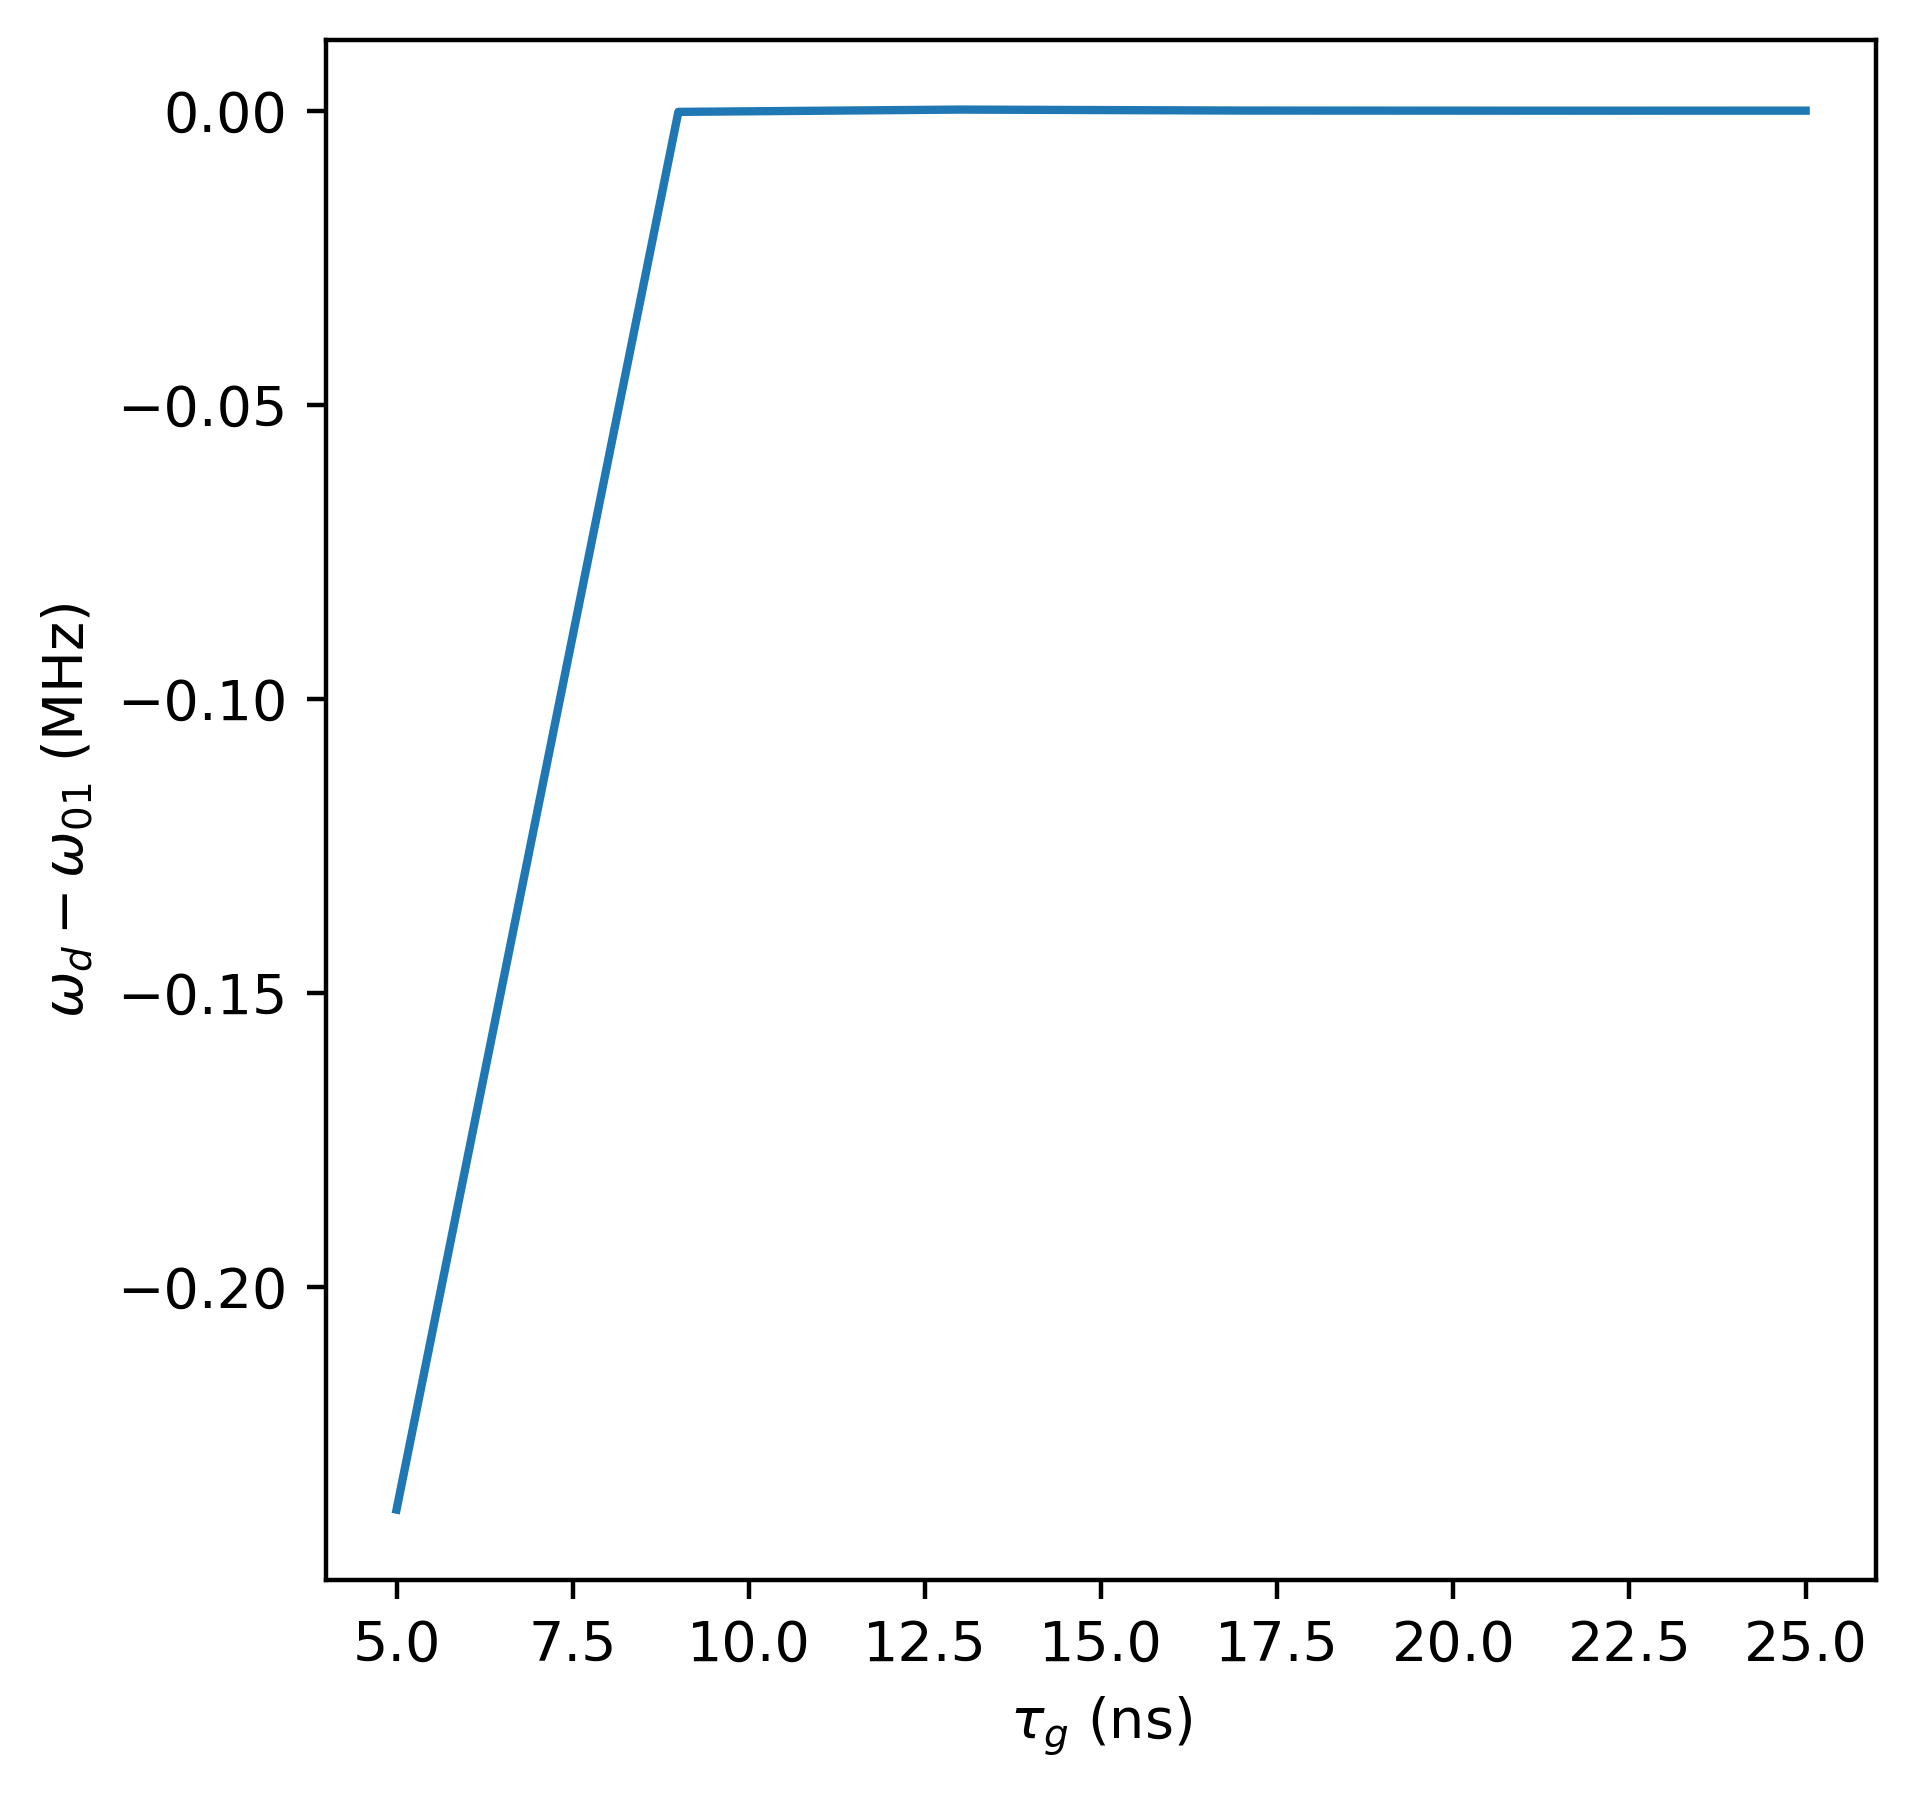

In [77]:
plt.figure(figsize = [5,5])
plt.plot(T_gate_array, delta_omega_d_array*1e3)
plt.ylabel(r'$\omega_d - \omega_{01}$ (MHz)')
plt.xlabel(r'$\tau_g$ (ns)')

Text(0.5, 0, '$\\tau_g$ (ns)')

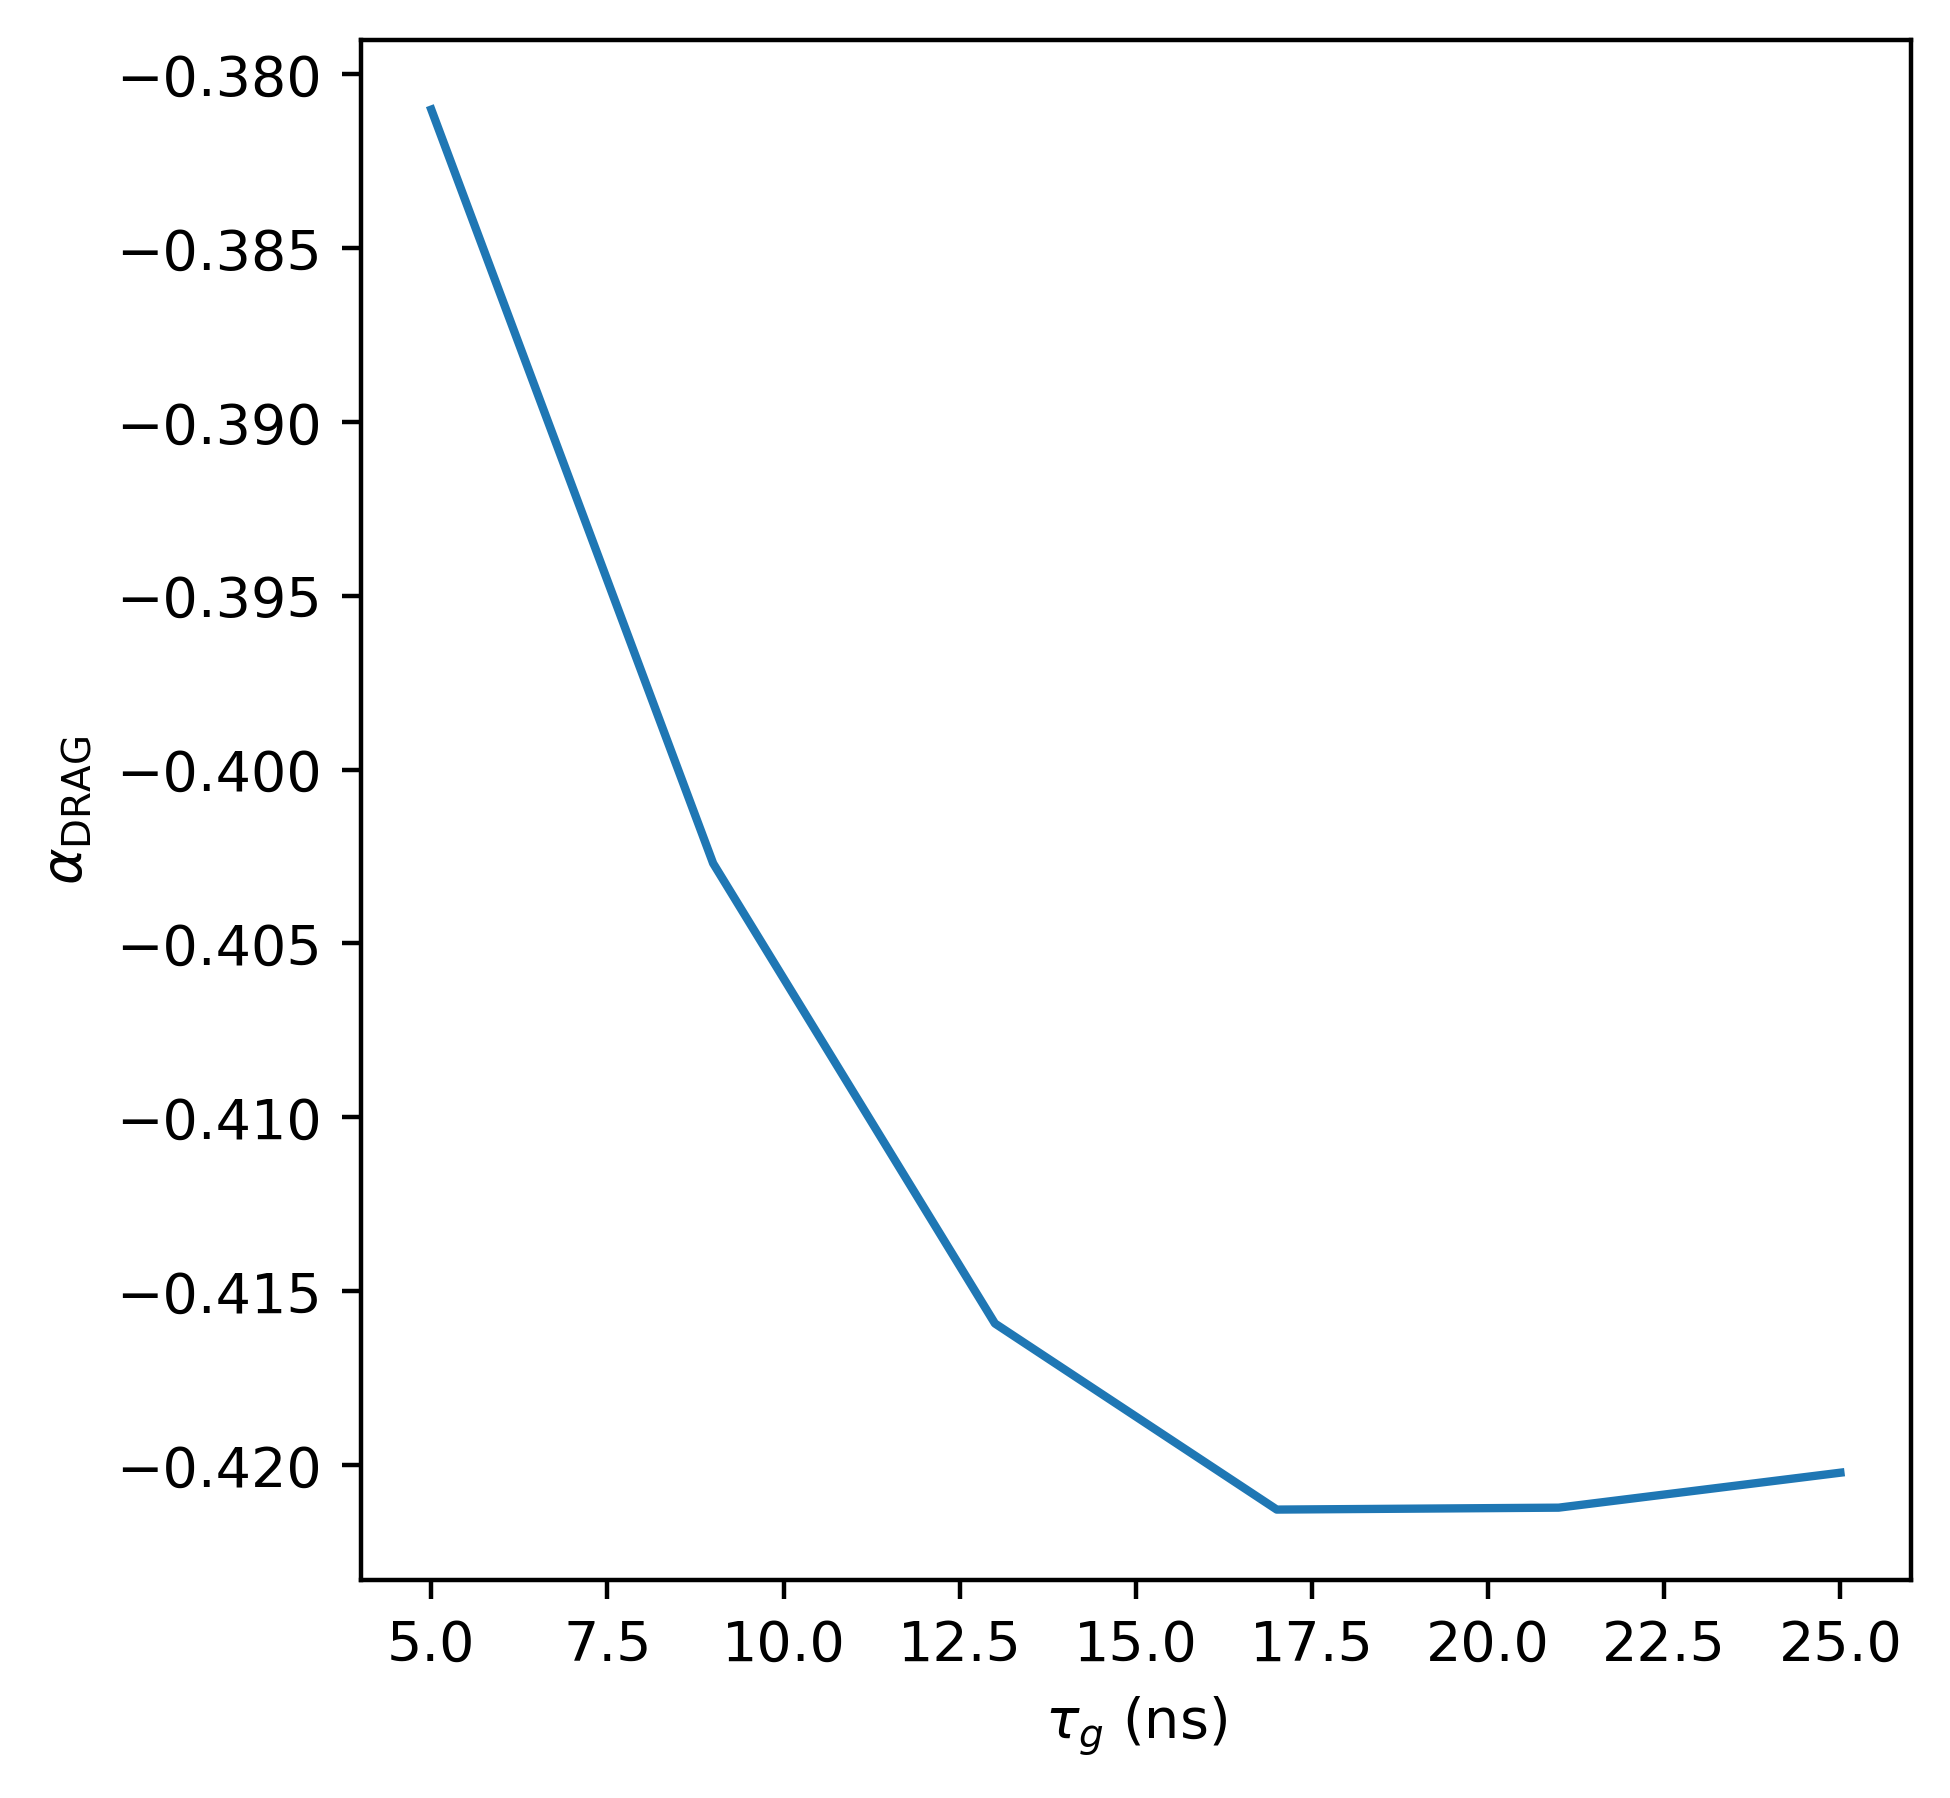

In [78]:
plt.figure(figsize = [5,5])
plt.plot(T_gate_array, drag_coeff_array)
plt.ylabel(r'$\alpha_\mathrm{DRAG}$')
plt.xlabel(r'$\tau_g$ (ns)')

# Flux driving

In [79]:
#Gate parameter
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 0.5
delta_omega_d = 0
shape = 'cos'
sigma = 0.25
drag = True
drag_coeff = 0.0

comp_space = [0,1]
omega_d = qubit.freq(0,1) + delta_omega_d
matr_el = np.abs(qubit.phi_ij(0,1))
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.phi())
H_dummy = 0*(qubit.phi())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

99.58395248443956


Text(0.5, 1.0, '$\\mathcal{F}=$0.99584')

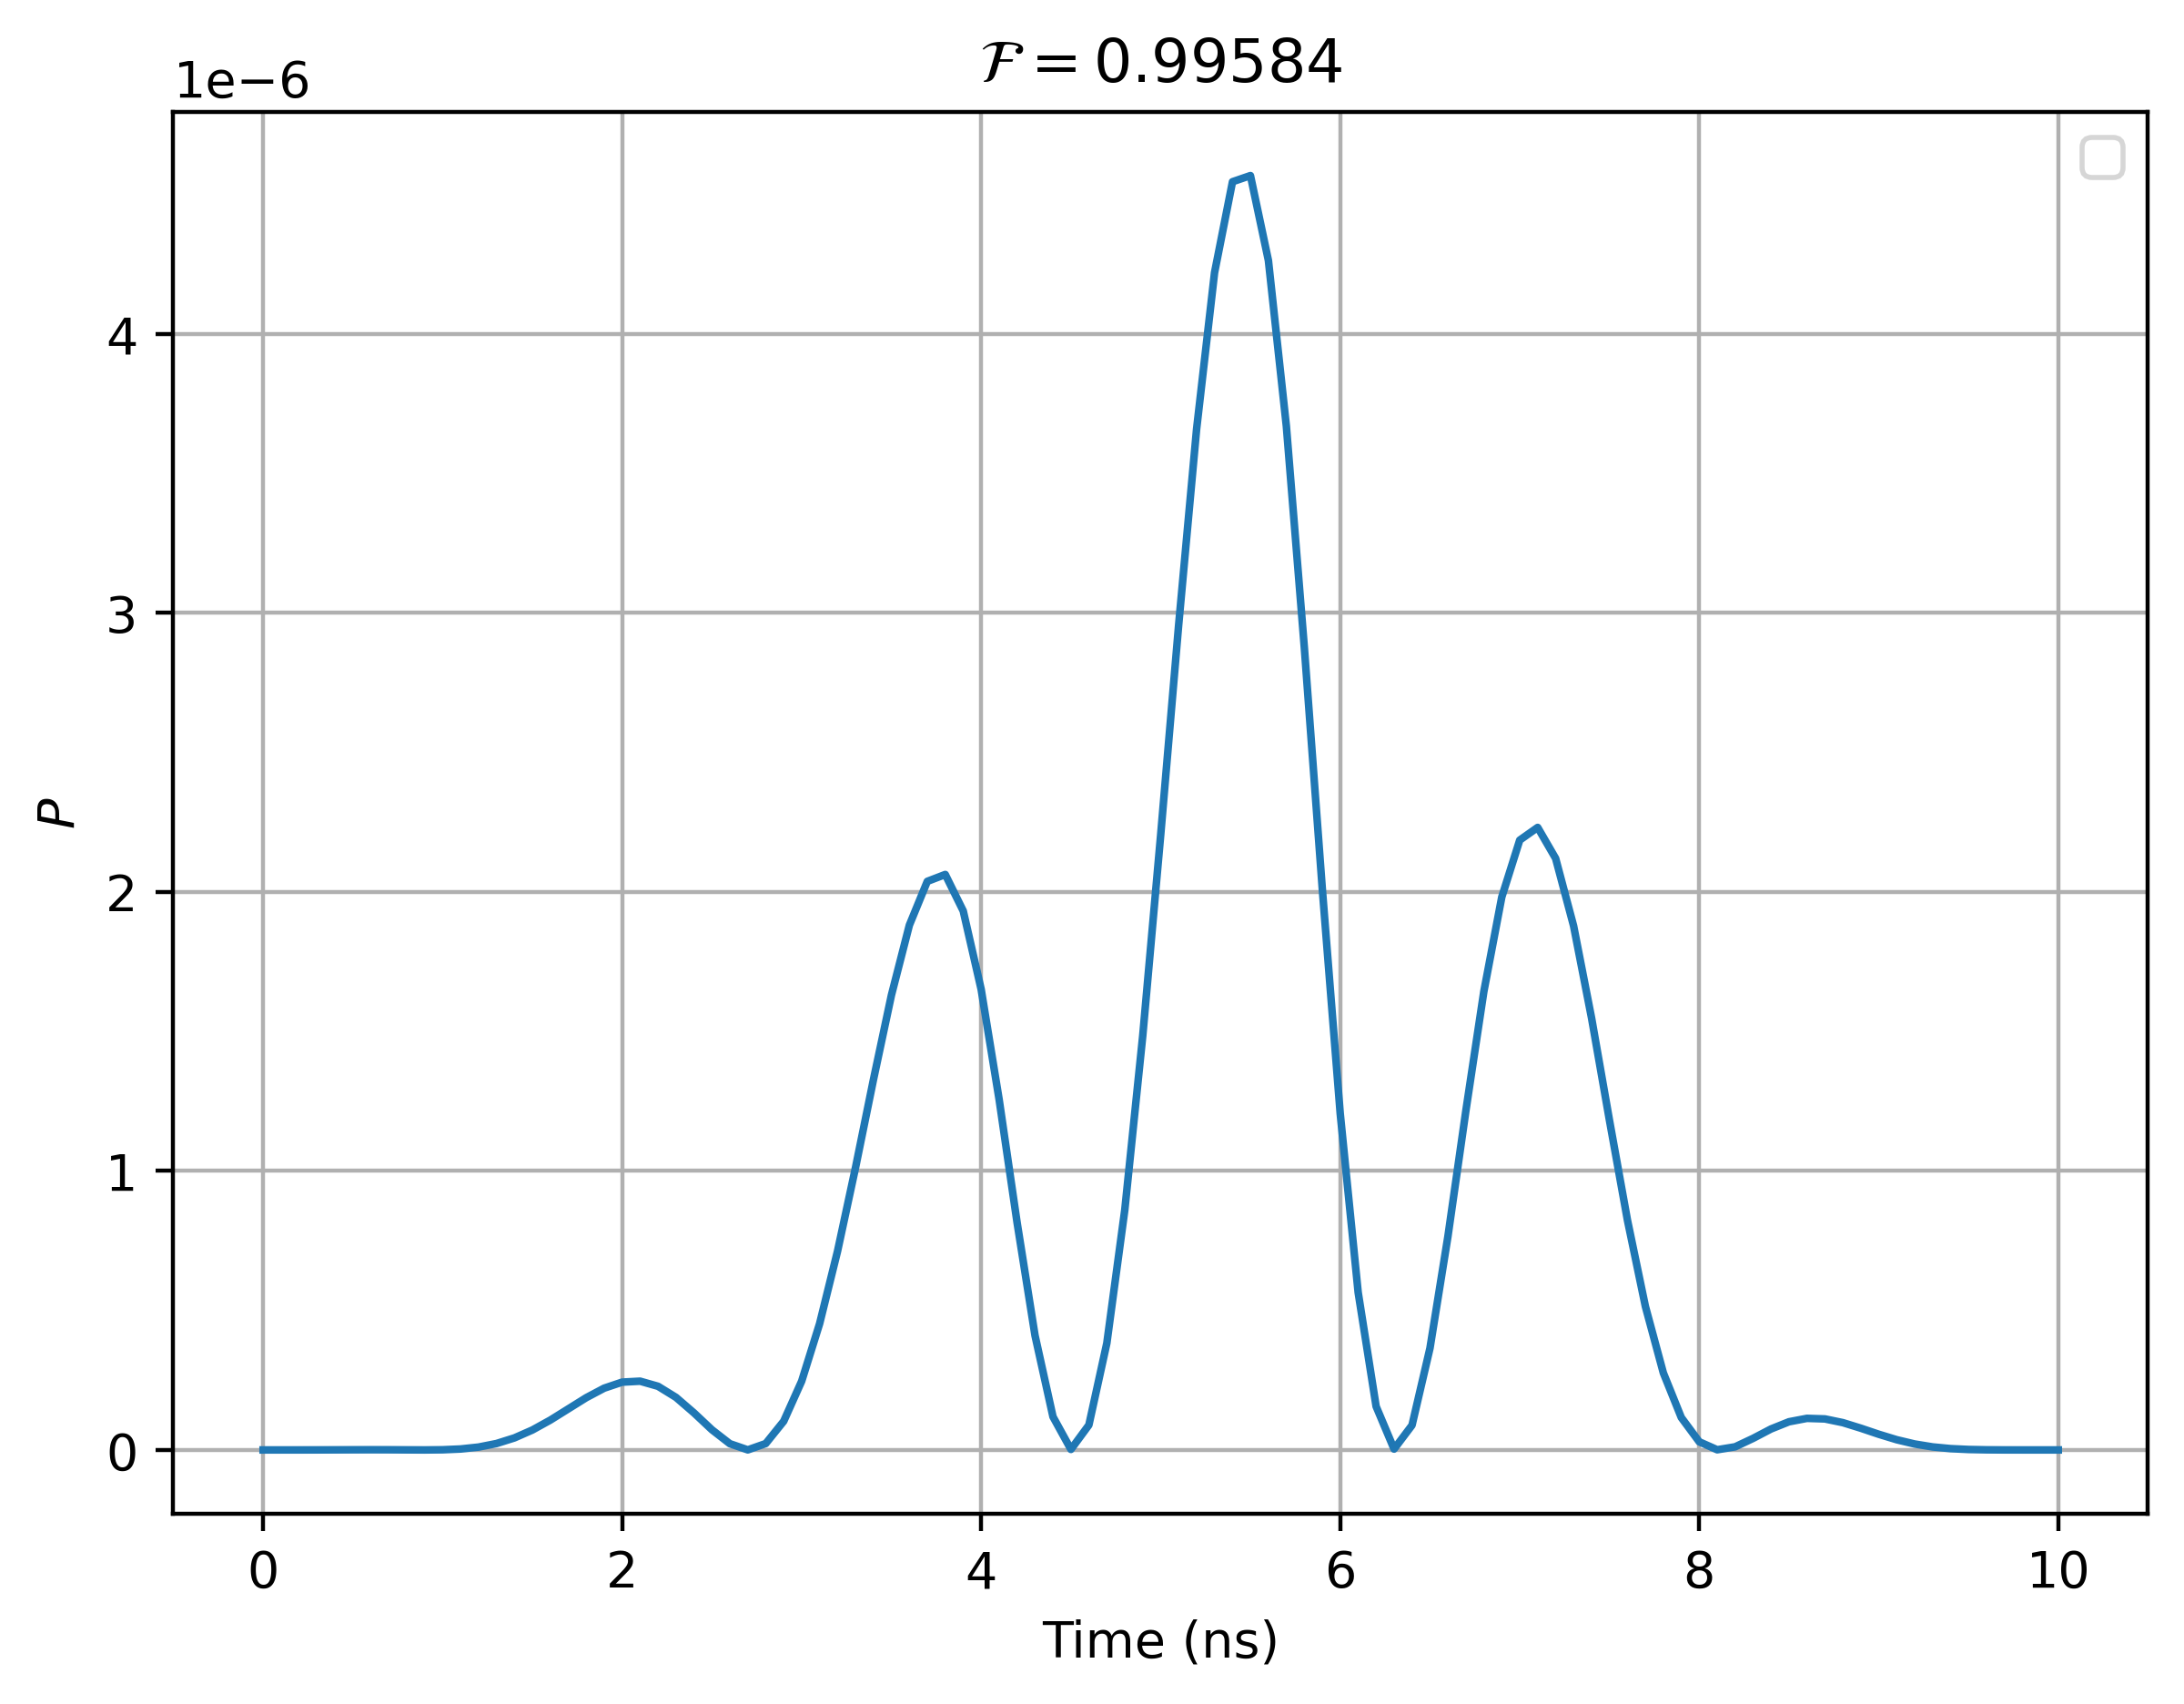

In [80]:
#Plotting results
state_0 = basis(nlev_single,0)
state_1 = basis(nlev_single,1)
state_2 = basis(nlev_single,2)
state_3 = basis(nlev_single,3)

#Fidelity
U_ideal = sigmax()
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidel*100)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
leakage_flux = 1 - trans_prob_0 - trans_prob_1

plt.figure(figsize = [7,5])
# plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
# plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
# plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
# plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.plot(t_points, leakage_flux)
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

In [81]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(op.sigz(N=nlev_single),state_evol))
sx = np.real(expect(op.sigx(N=nlev_single),state_evol))
sy = np.real(expect(op.sigy(N=nlev_single),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.add_vectors([sx[-1], sy[-1], sz[-1]])
b.make_sphere()

## Optimization

In [82]:
def infidelity(x):
    delta_omega_d = x[0]
    drag_coeff = x[1]
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return 1-fidel

x0 = [0,0]
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-8)
print (xopt.x)
print (infidelity(xopt.x))

[-5.16057114e-06  1.44025639e-01]
1.0412970566586743e-05


1.0412970566586743e-05


Text(0.5, 1.0, '$\\mathcal{F}=$0.99999')

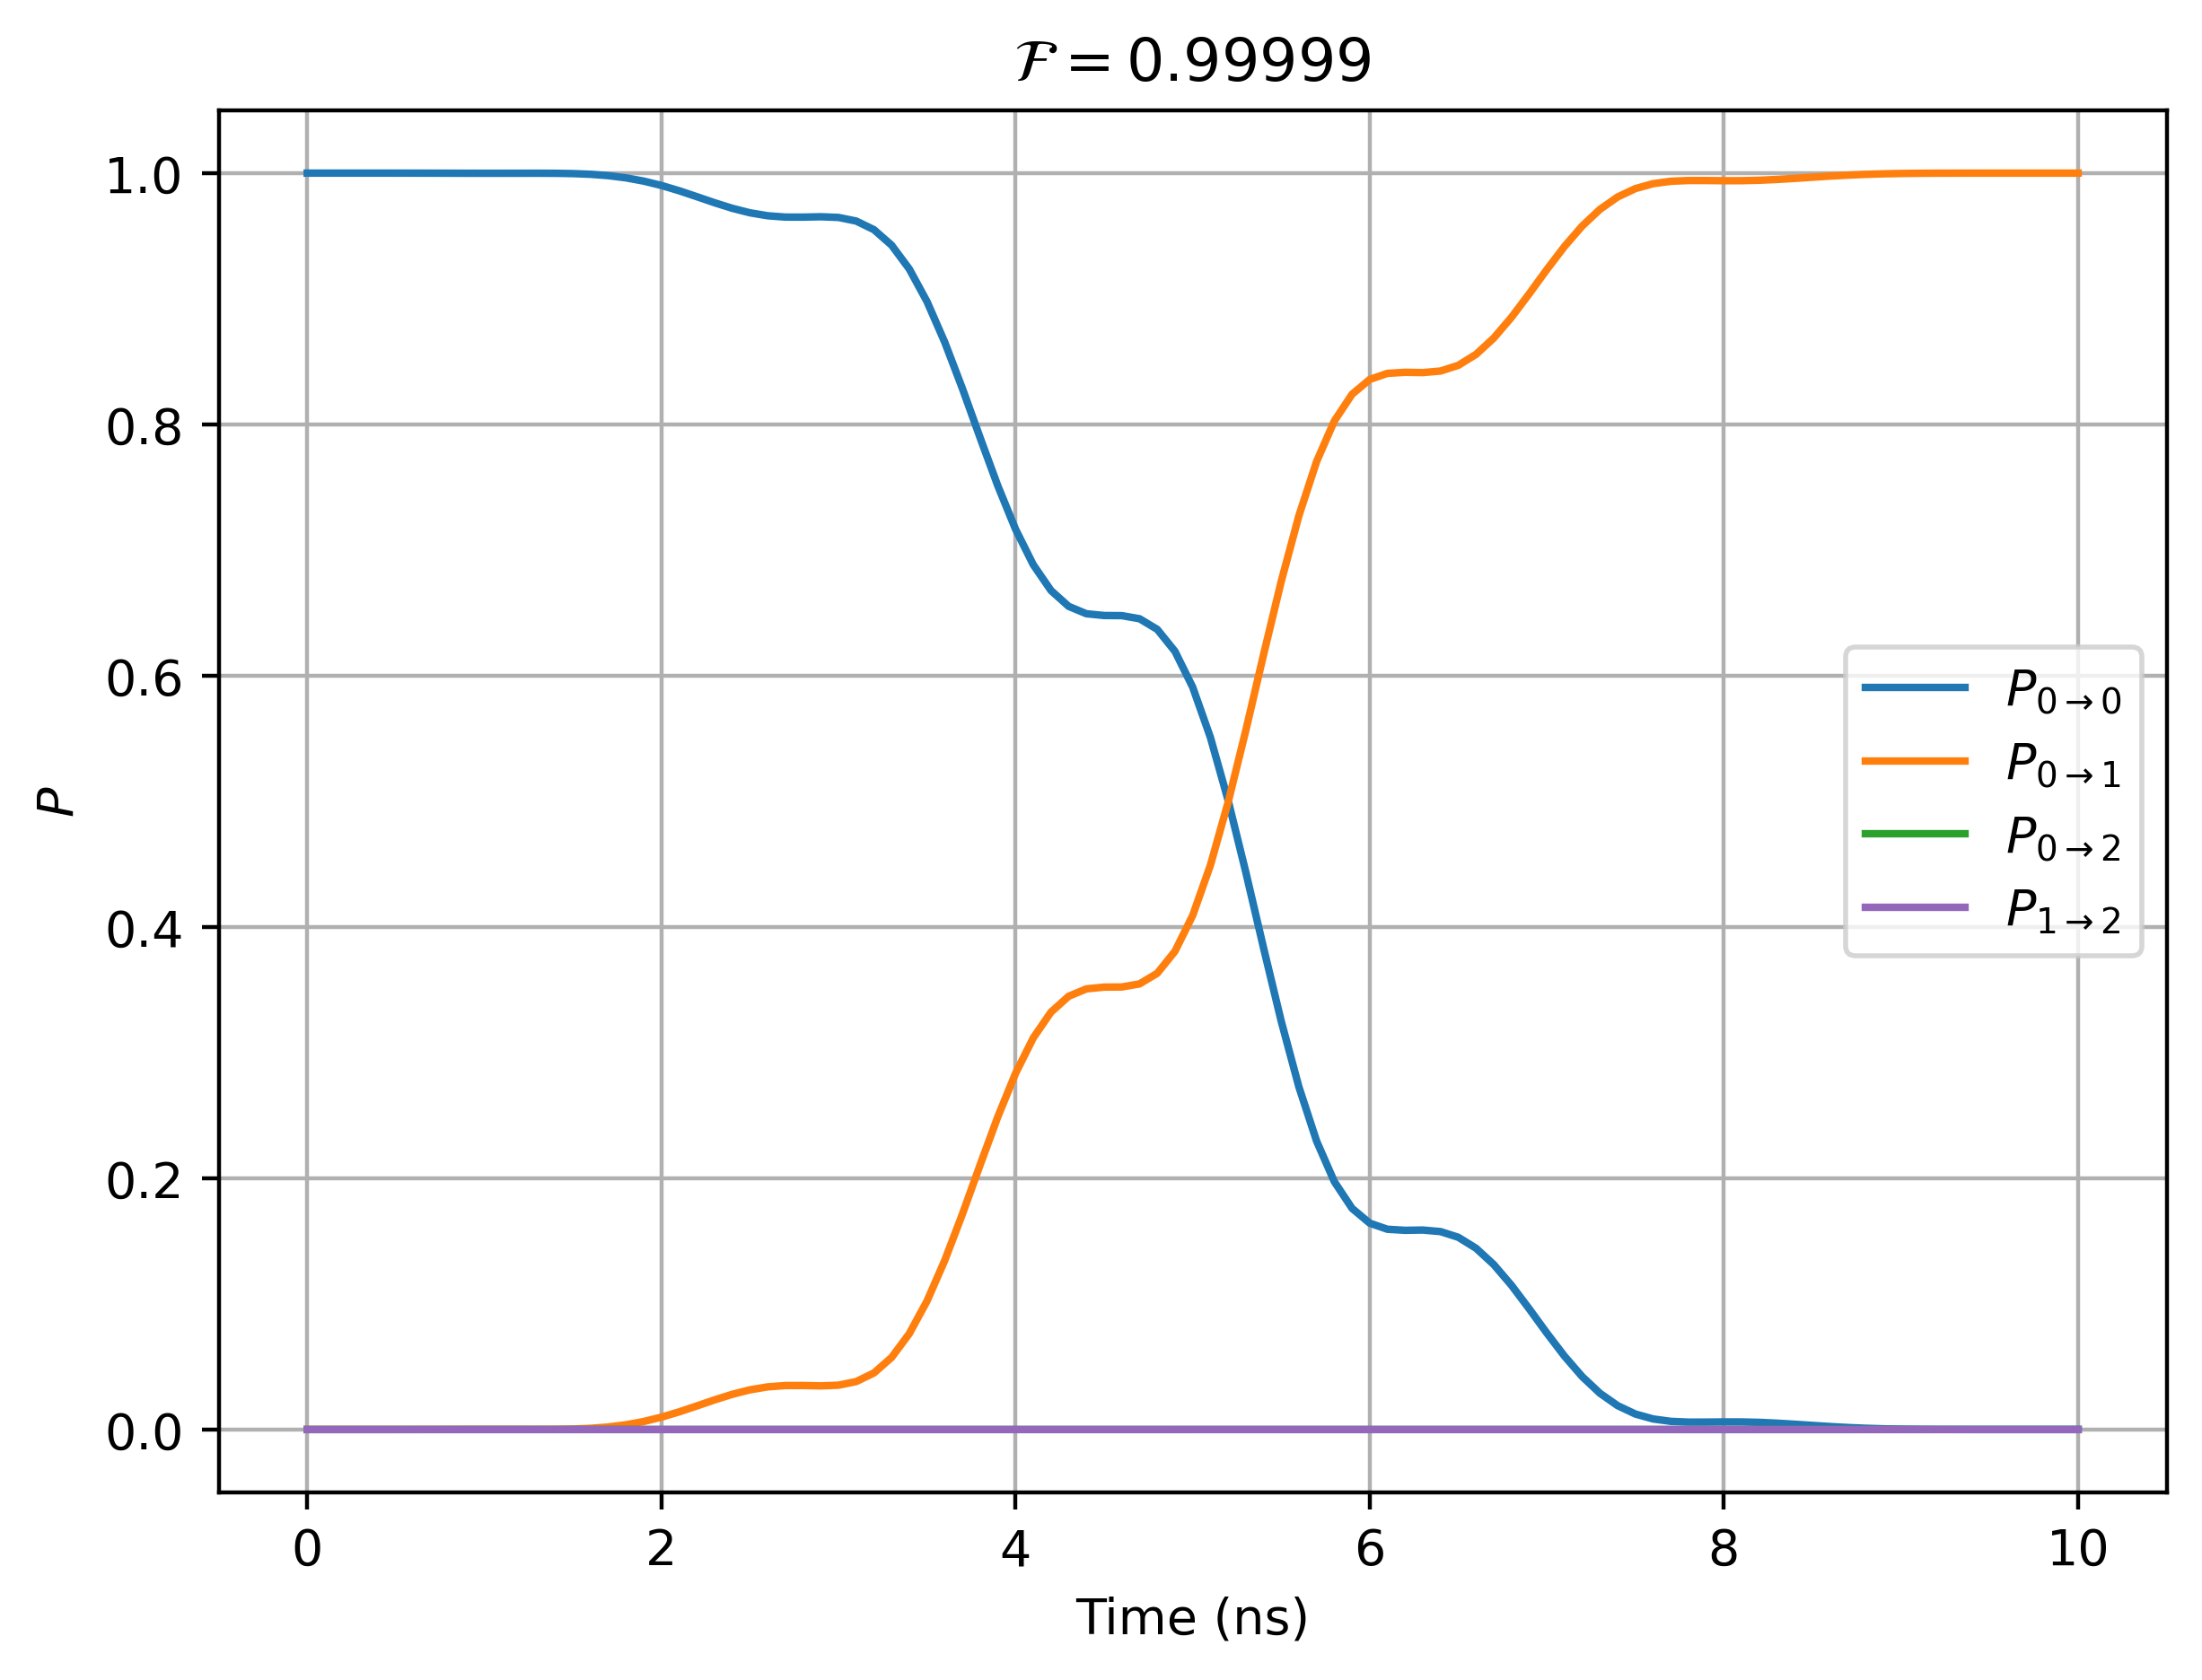

In [83]:
delta_omega_d=xopt.x[0]
drag_coeff = xopt.x[1]
omega_d = qubit.freq(0,1) + delta_omega_d
U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(1-fidel)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
leakage_flux_corr = 1 - trans_prob_0 - trans_prob_1
plt.figure(figsize = [7,5])
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

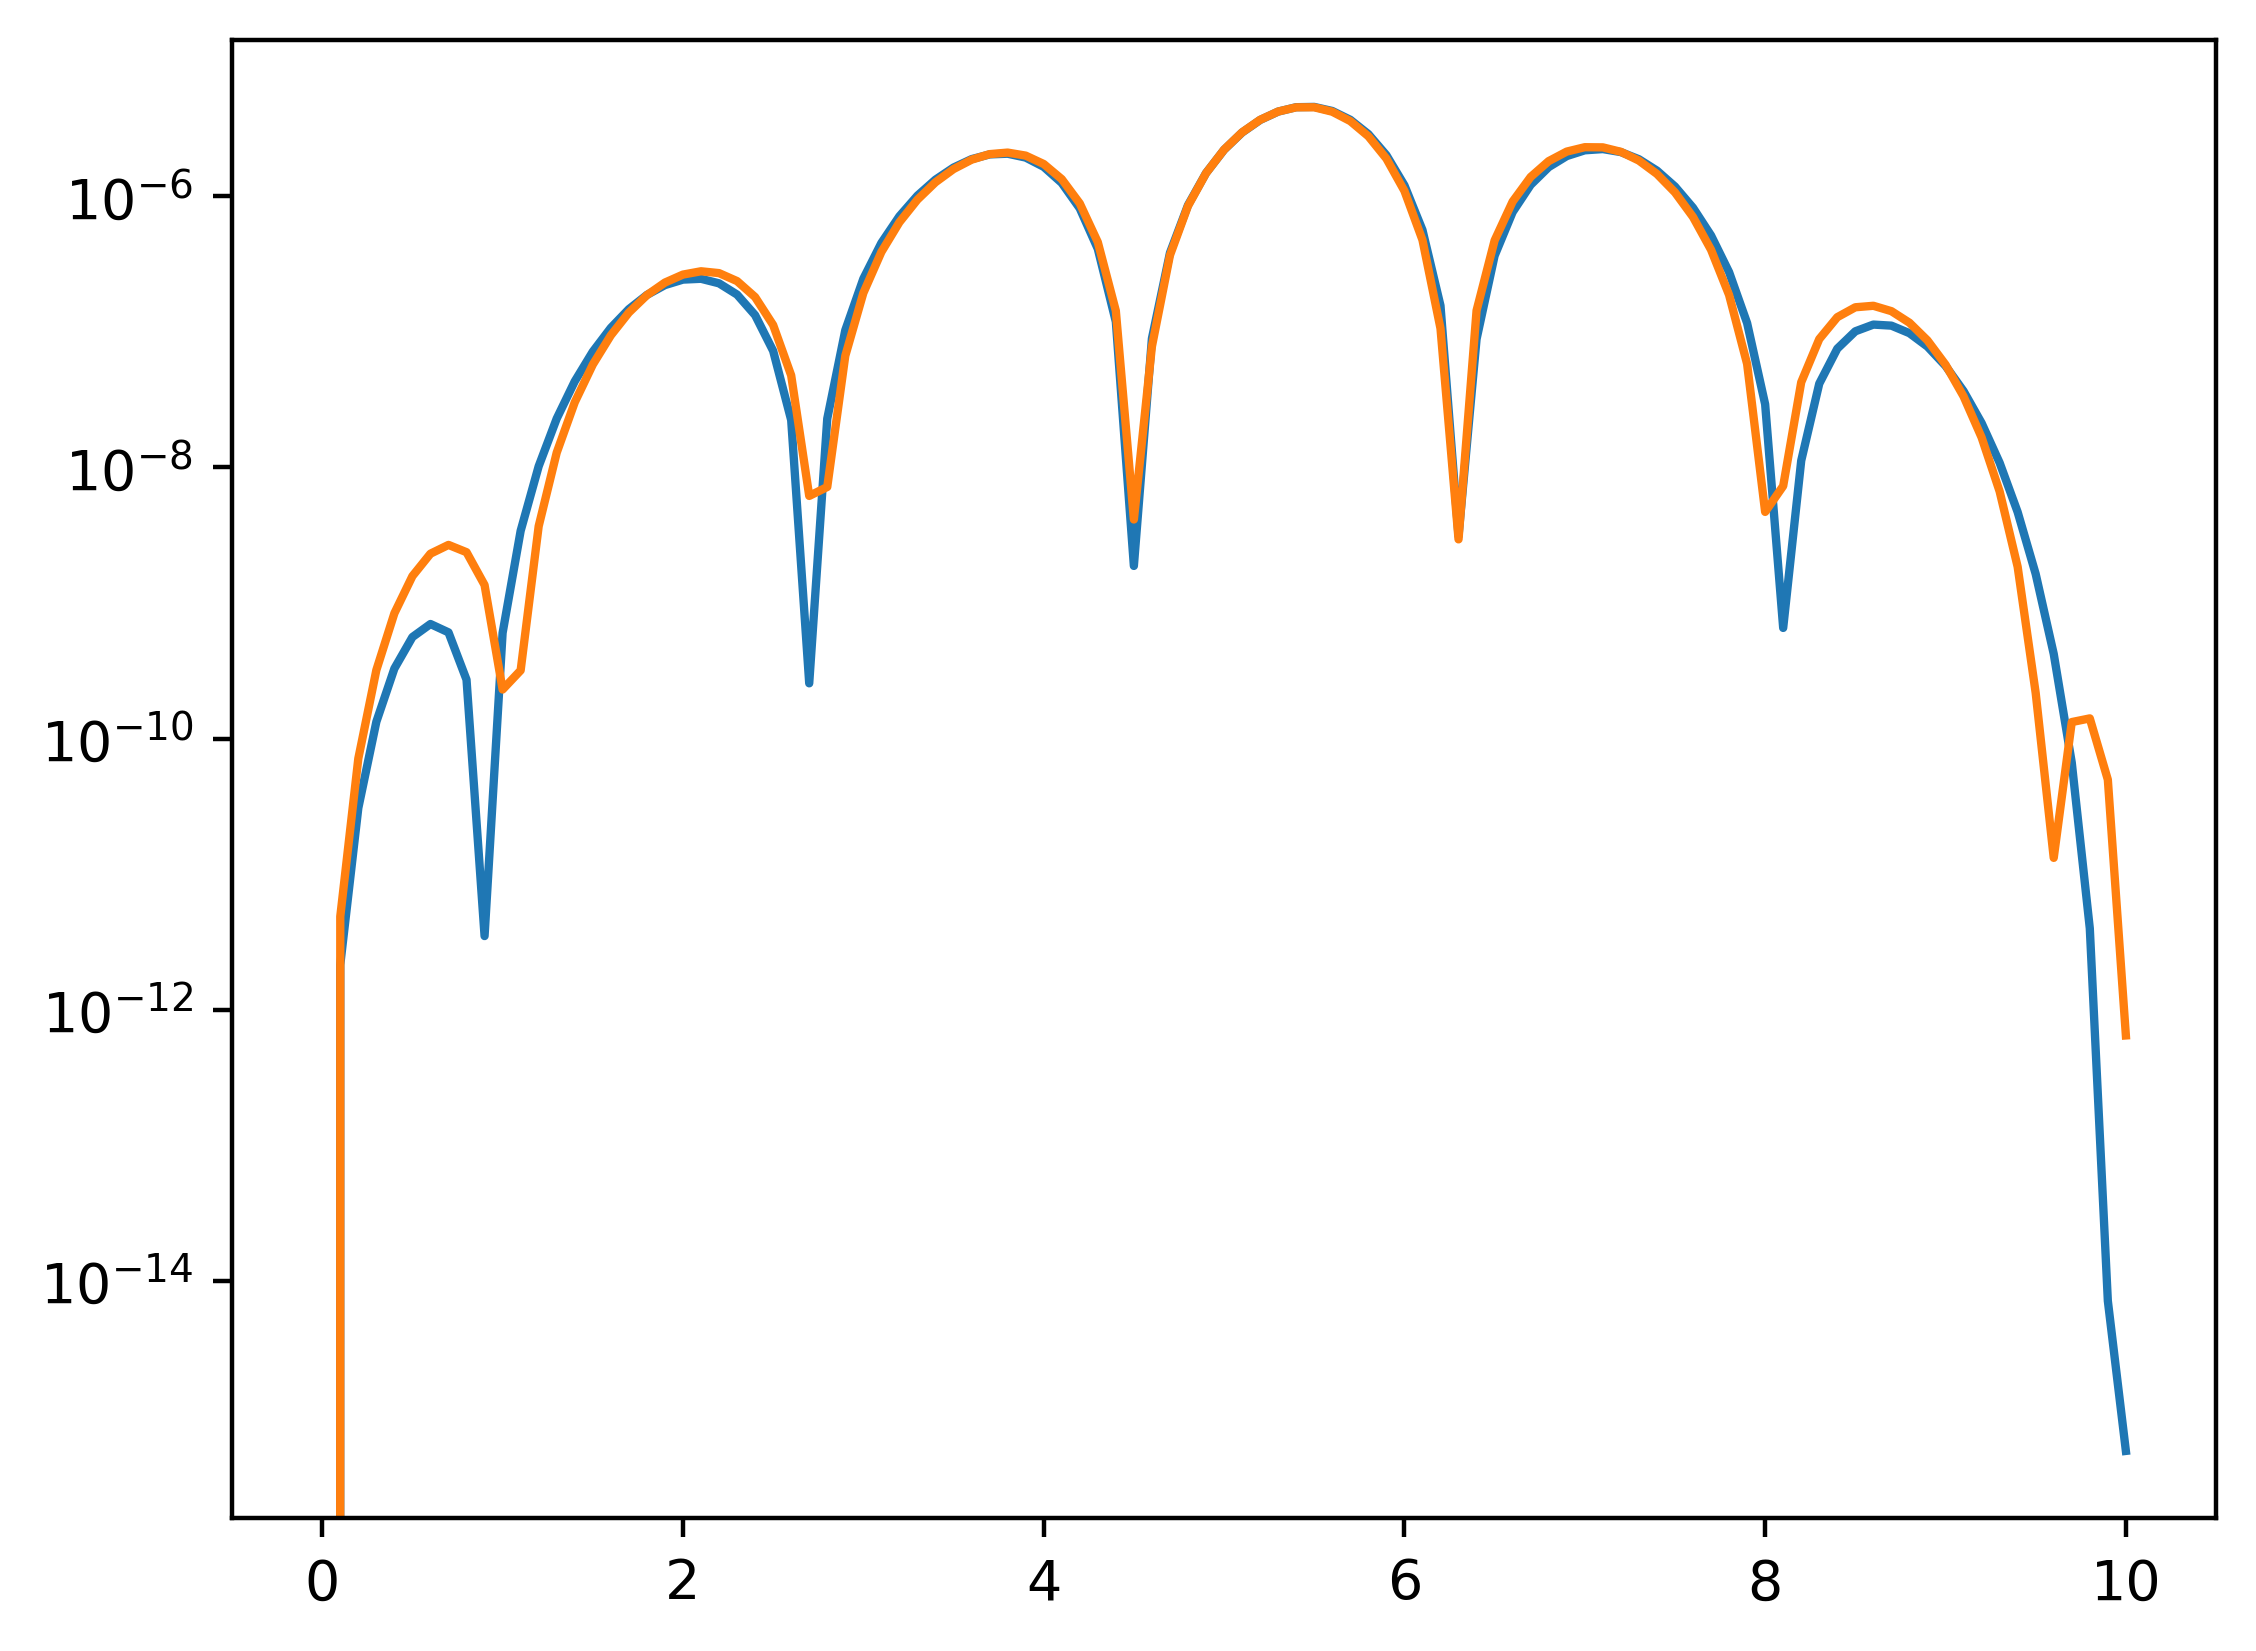

In [84]:
plt.plot(t_points, leakage_flux)
plt.plot(t_points, leakage_flux_corr)
plt.yscale('log')

In [85]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(op.sigz(N=nlev_single),state_evol))
sx = np.real(expect(op.sigx(N=nlev_single),state_evol))
sy = np.real(expect(op.sigy(N=nlev_single),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.add_vectors([sx[-1], sy[-1], sz[-1]])
b.make_sphere()

## Sweeping gate time

In [86]:
#Gate parameter
T_gate_array = np.linspace(5,25,6) #ns
error_array_flux = np.zeros_like(T_gate_array)
drag_coeff_array = np.zeros_like(T_gate_array)
delta_omega_d_array = np.zeros_like(T_gate_array)
leakage_array_flux = np.zeros_like(T_gate_array)
U_ideal = sigmax()

shape = 'cos'
sigma = 0.25
drag = True

for T_idx, T_gate in enumerate(T_gate_array):
    t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
    delta_omega_d = 0
    drag_coeff = 0
    U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    def infidelity(x):
        delta_omega_d = x[0]
        drag_coeff = x[1]
        drive_factor = x[2]
        epsilon = drive_factor/matr_el
        H_drive = epsilon*(qubit.phi())
        omega_d = qubit.freq(0,1) + delta_omega_d
        U_t = gates.evolution_operator_microwave(
                    qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
        U_real = U_nothing[-1]*U_t[-1]
        U_real = Qobj(U_real[0:2, 0:2])

        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
        return 1-fidel


    x0 = [0,0,0.5]
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-7)
    
    error_array_flux[T_idx] = infidelity(xopt.x)
    drag_coeff_array[T_idx] = xopt.x[1]
    delta_omega_d_array[T_idx] = xopt.x[0]
    
    delta_omega_d = xopt.x[0]
    drag_coeff = xopt.x[1]
    drive_factor = xopt.x[2]
    epsilon = drive_factor/matr_el
    H_drive = epsilon*(qubit.phi())
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                    qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)    
    trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
    trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
    leakage_array_flux[T_idx] = 1 - trans_prob_0[-1] - trans_prob_1[-1]

In [93]:
T_gate_array

array([ 5.,  9., 13., 17., 21., 25.])

Text(0.5, 0, '$\\tau_g$ (ns)')

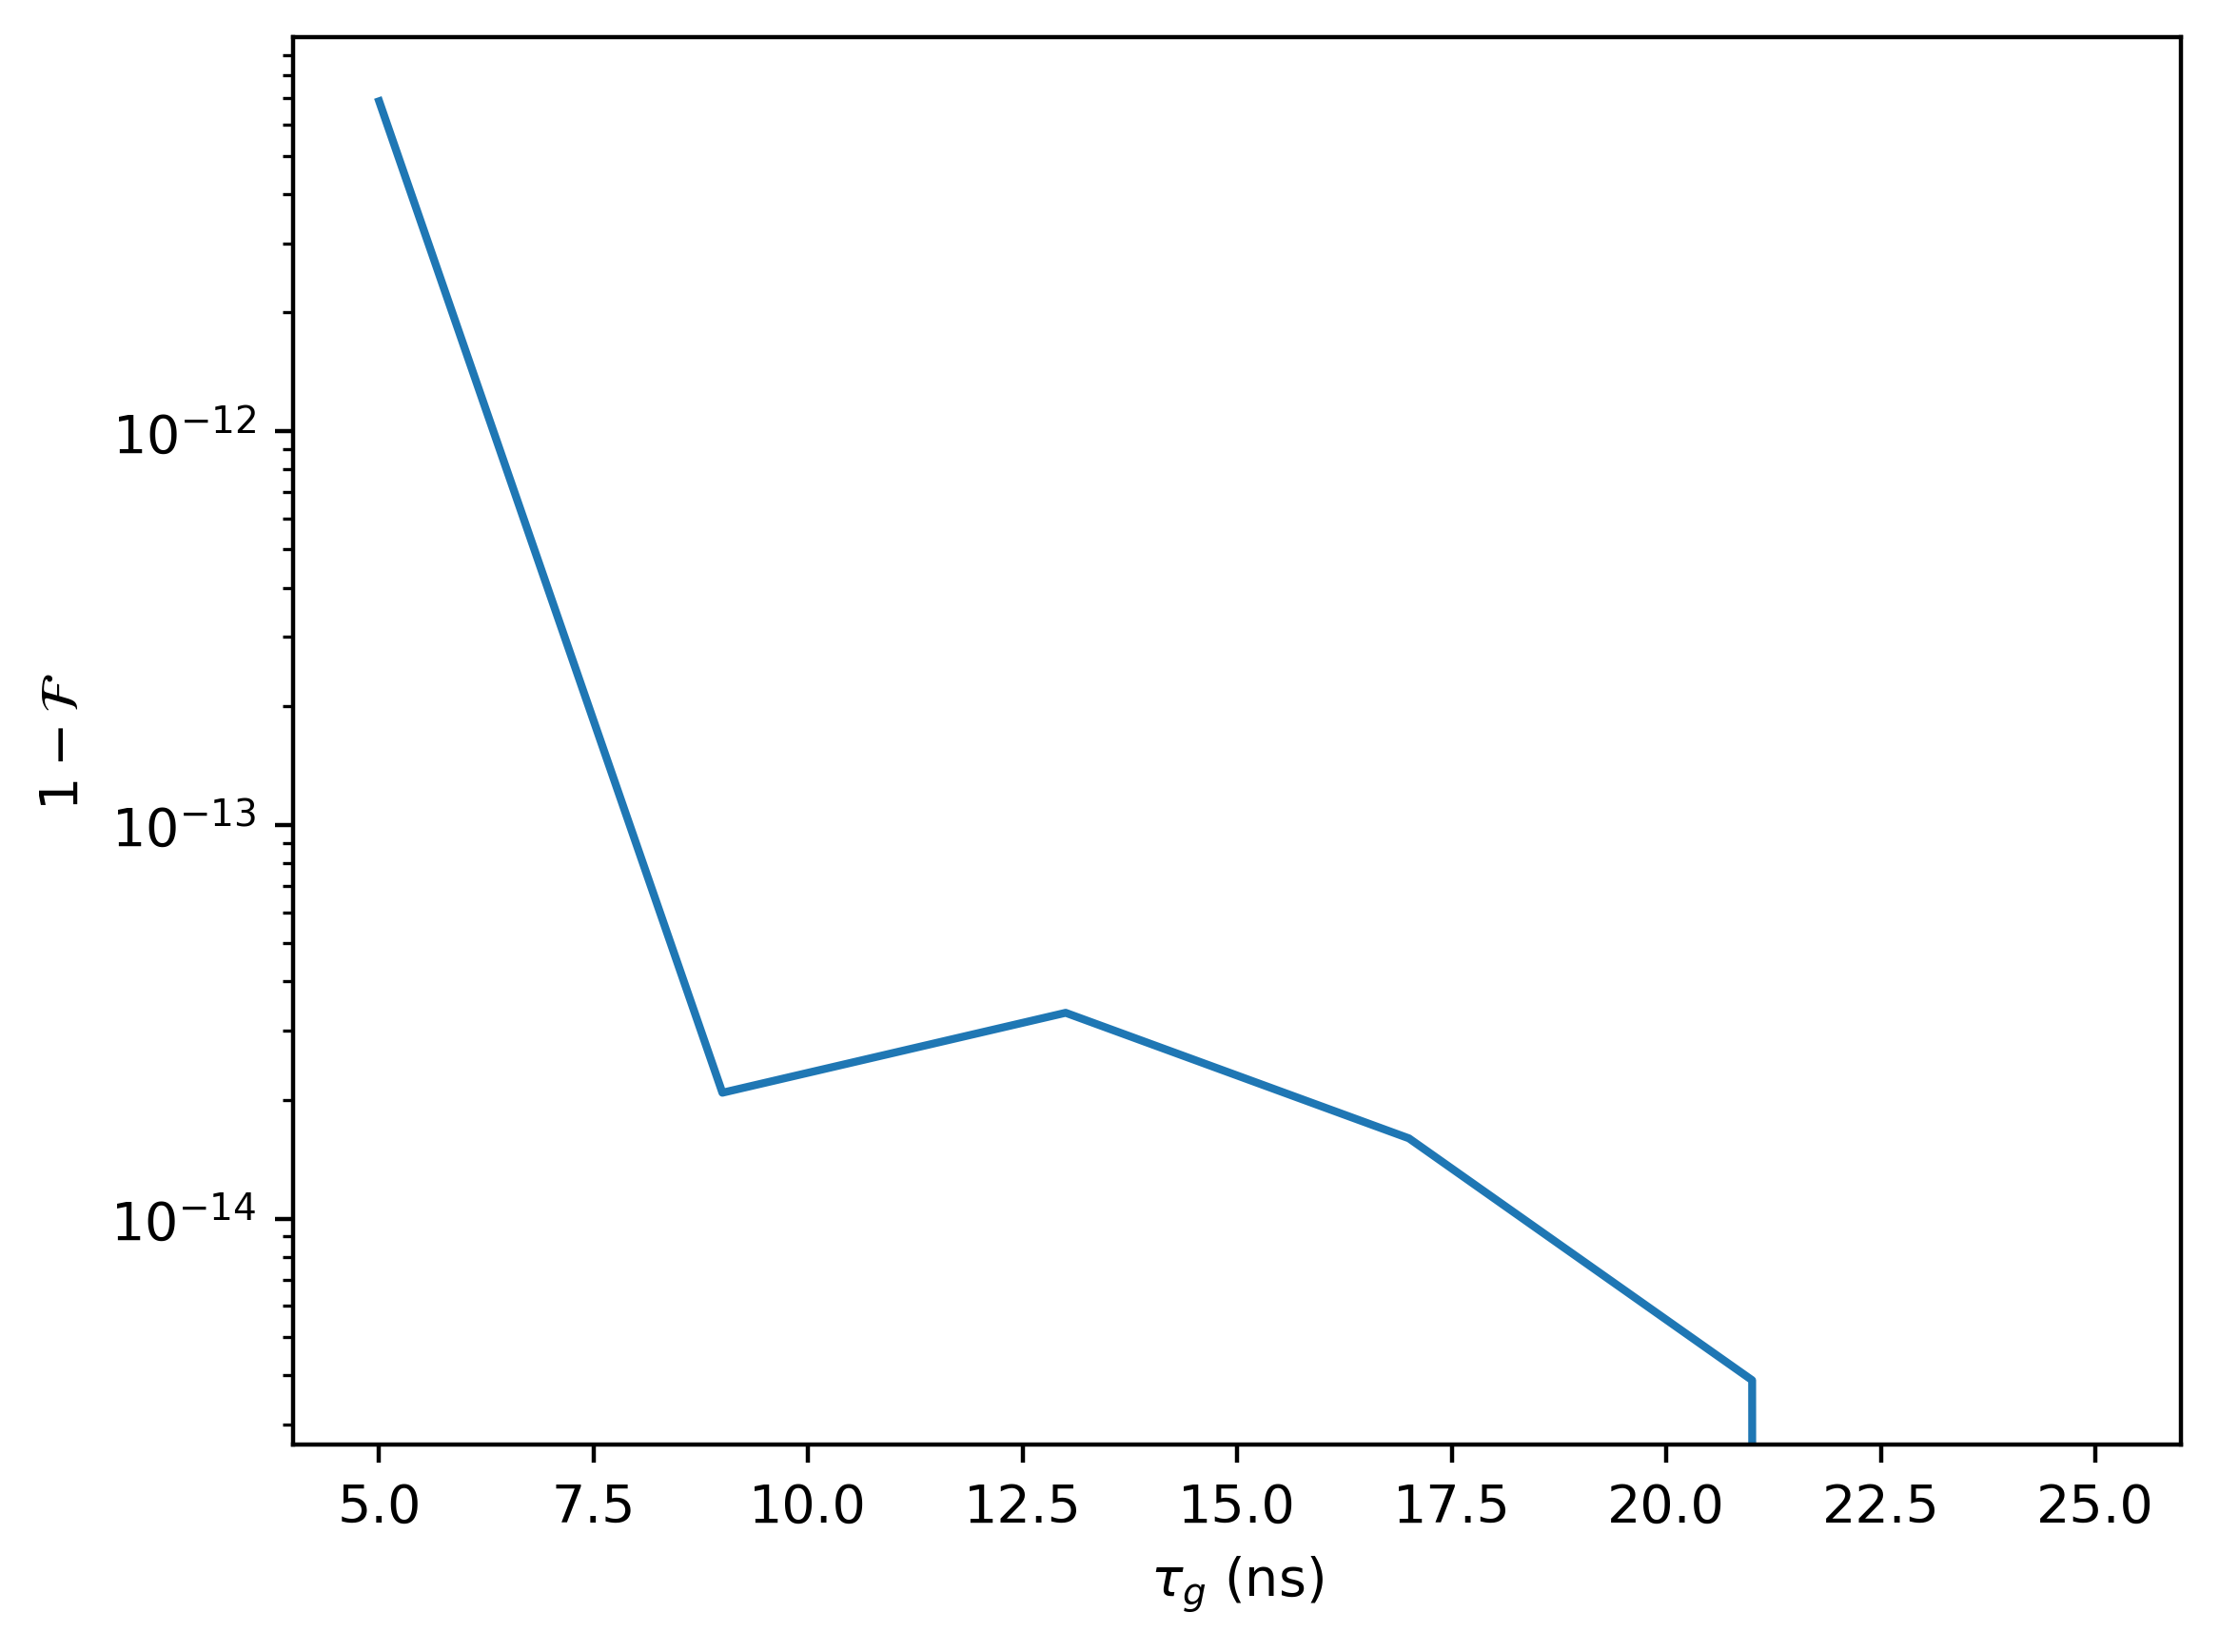

In [87]:
plt.semilogy(T_gate_array, error_array_flux)
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel(r'$\tau_g$ (ns)')

Text(0.5, 0, '$\\tau_g$ (ns)')

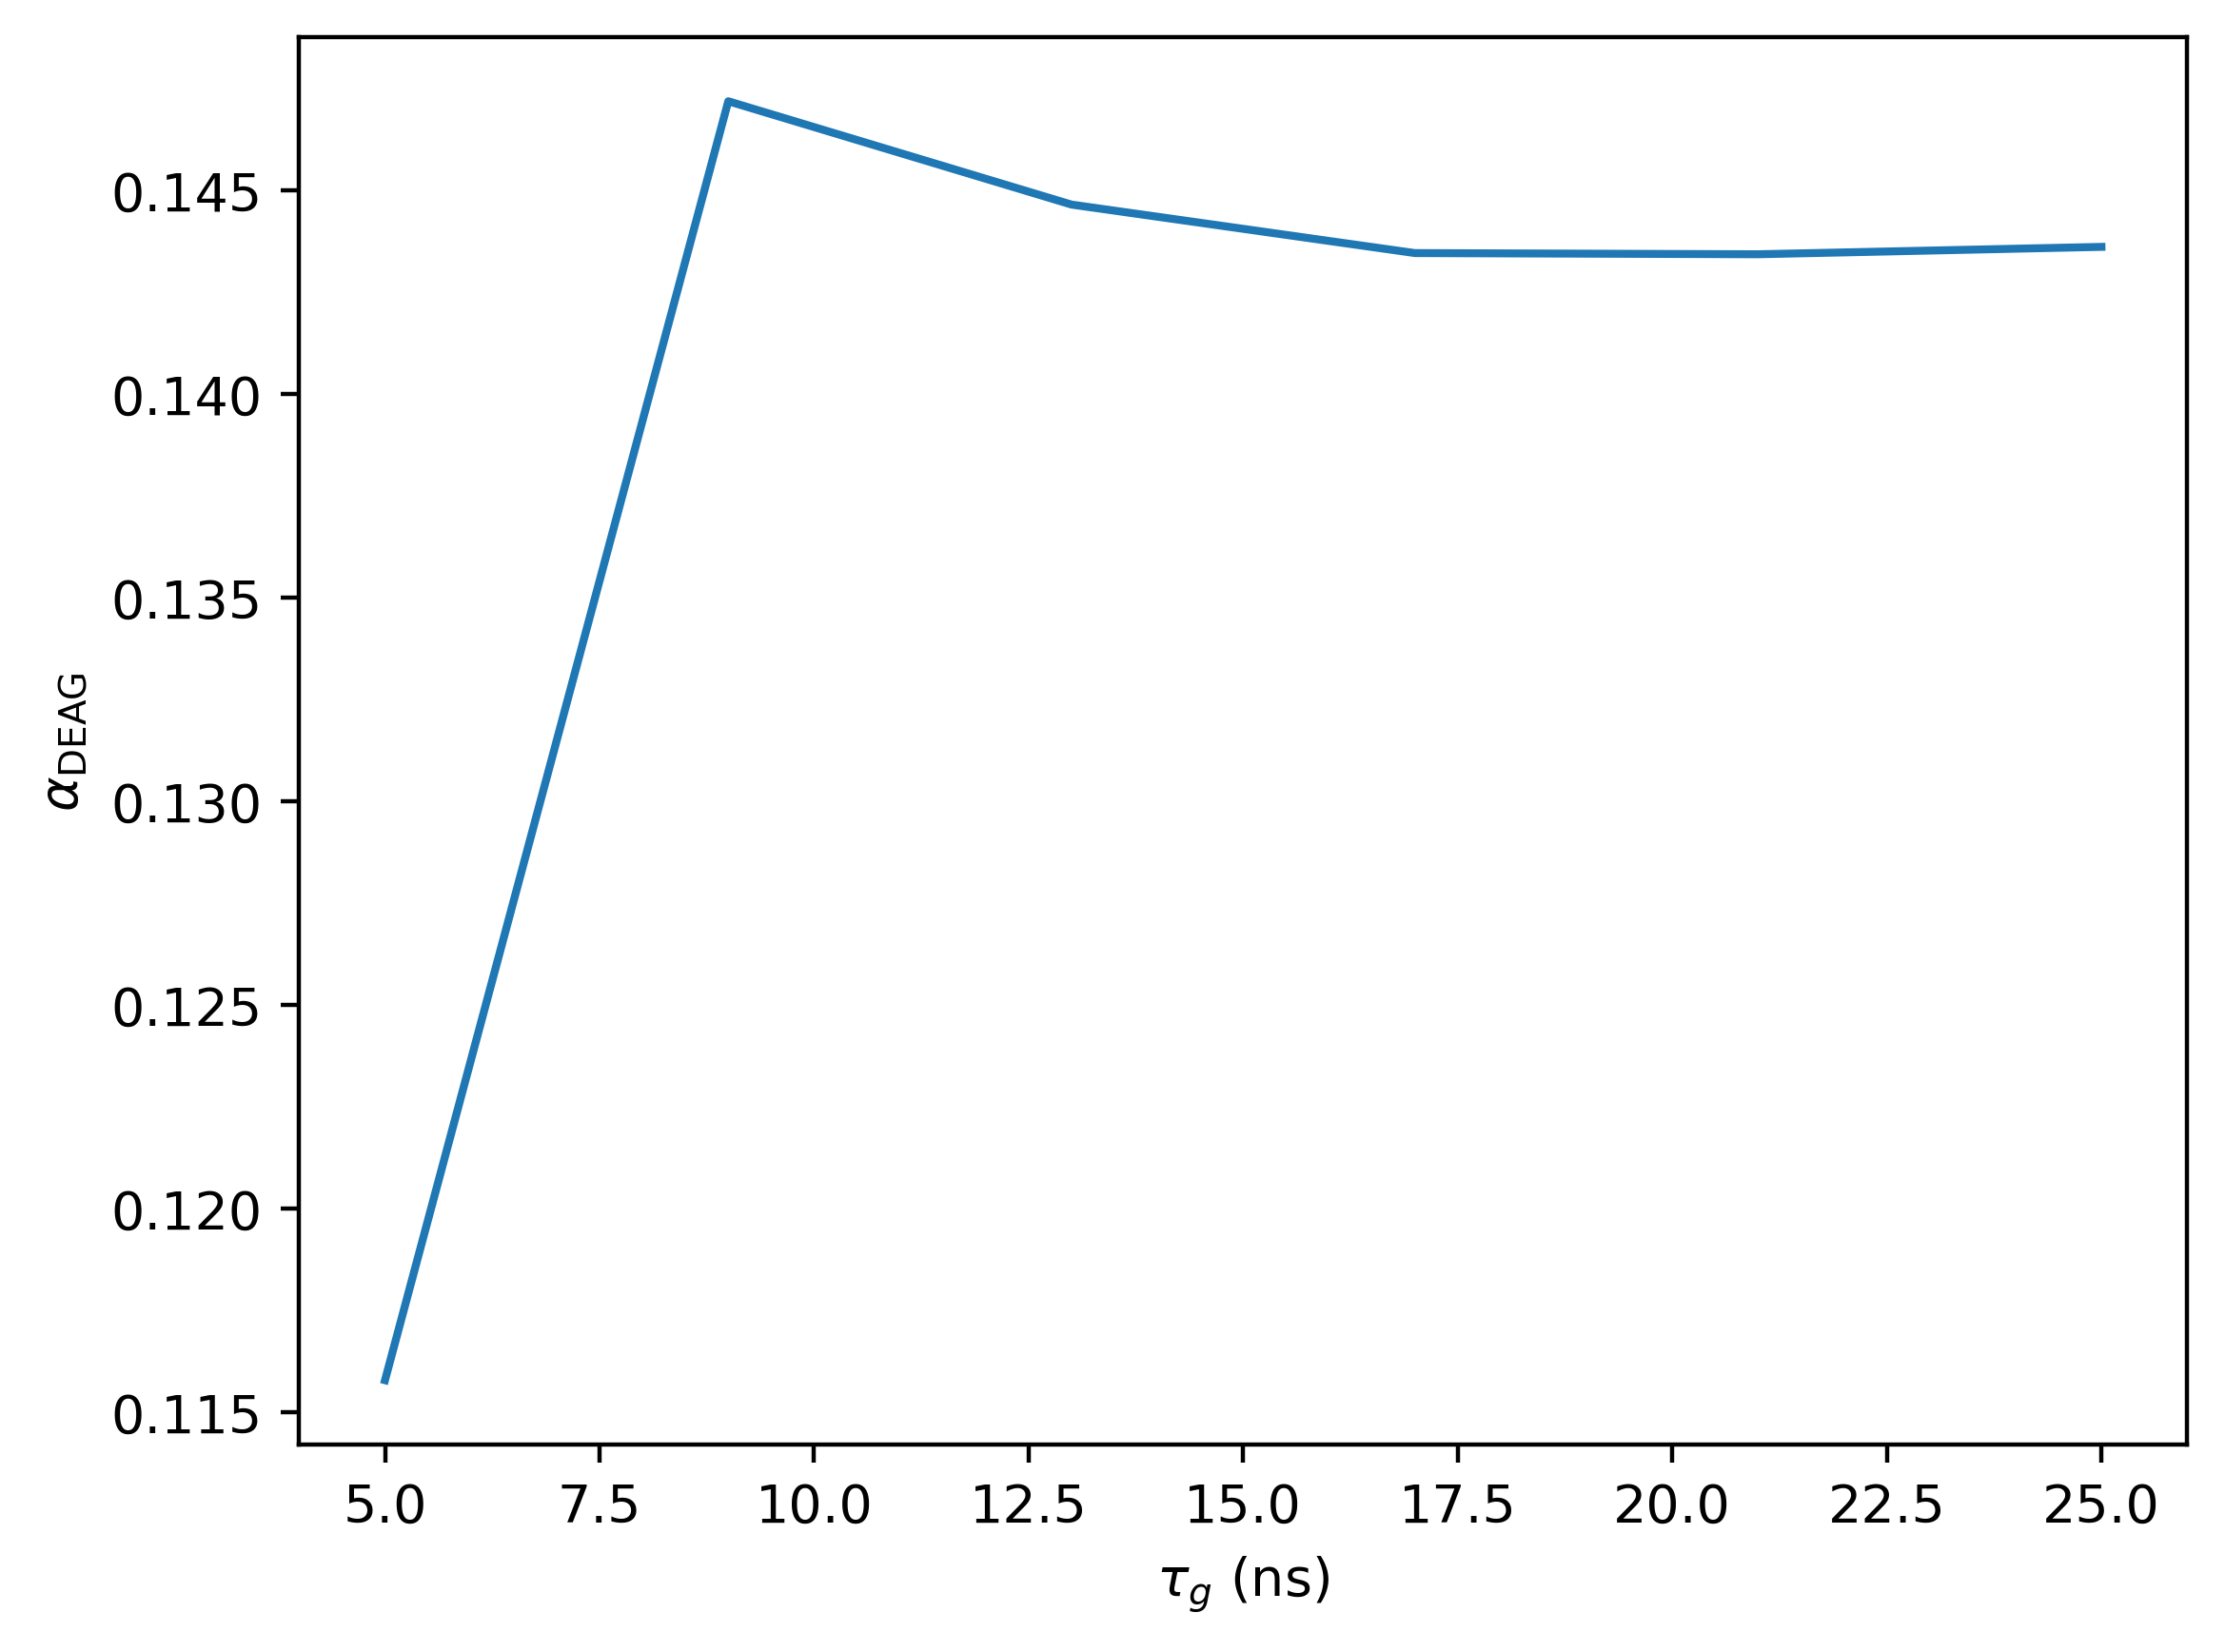

In [90]:
plt.plot(T_gate_array, drag_coeff_array)
plt.ylabel(r'$\alpha_\mathrm{DEAG}$')
plt.xlabel(r'$\tau_g$ (ns)')

Text(0.5, 0, '$\\tau_g$ (ns)')

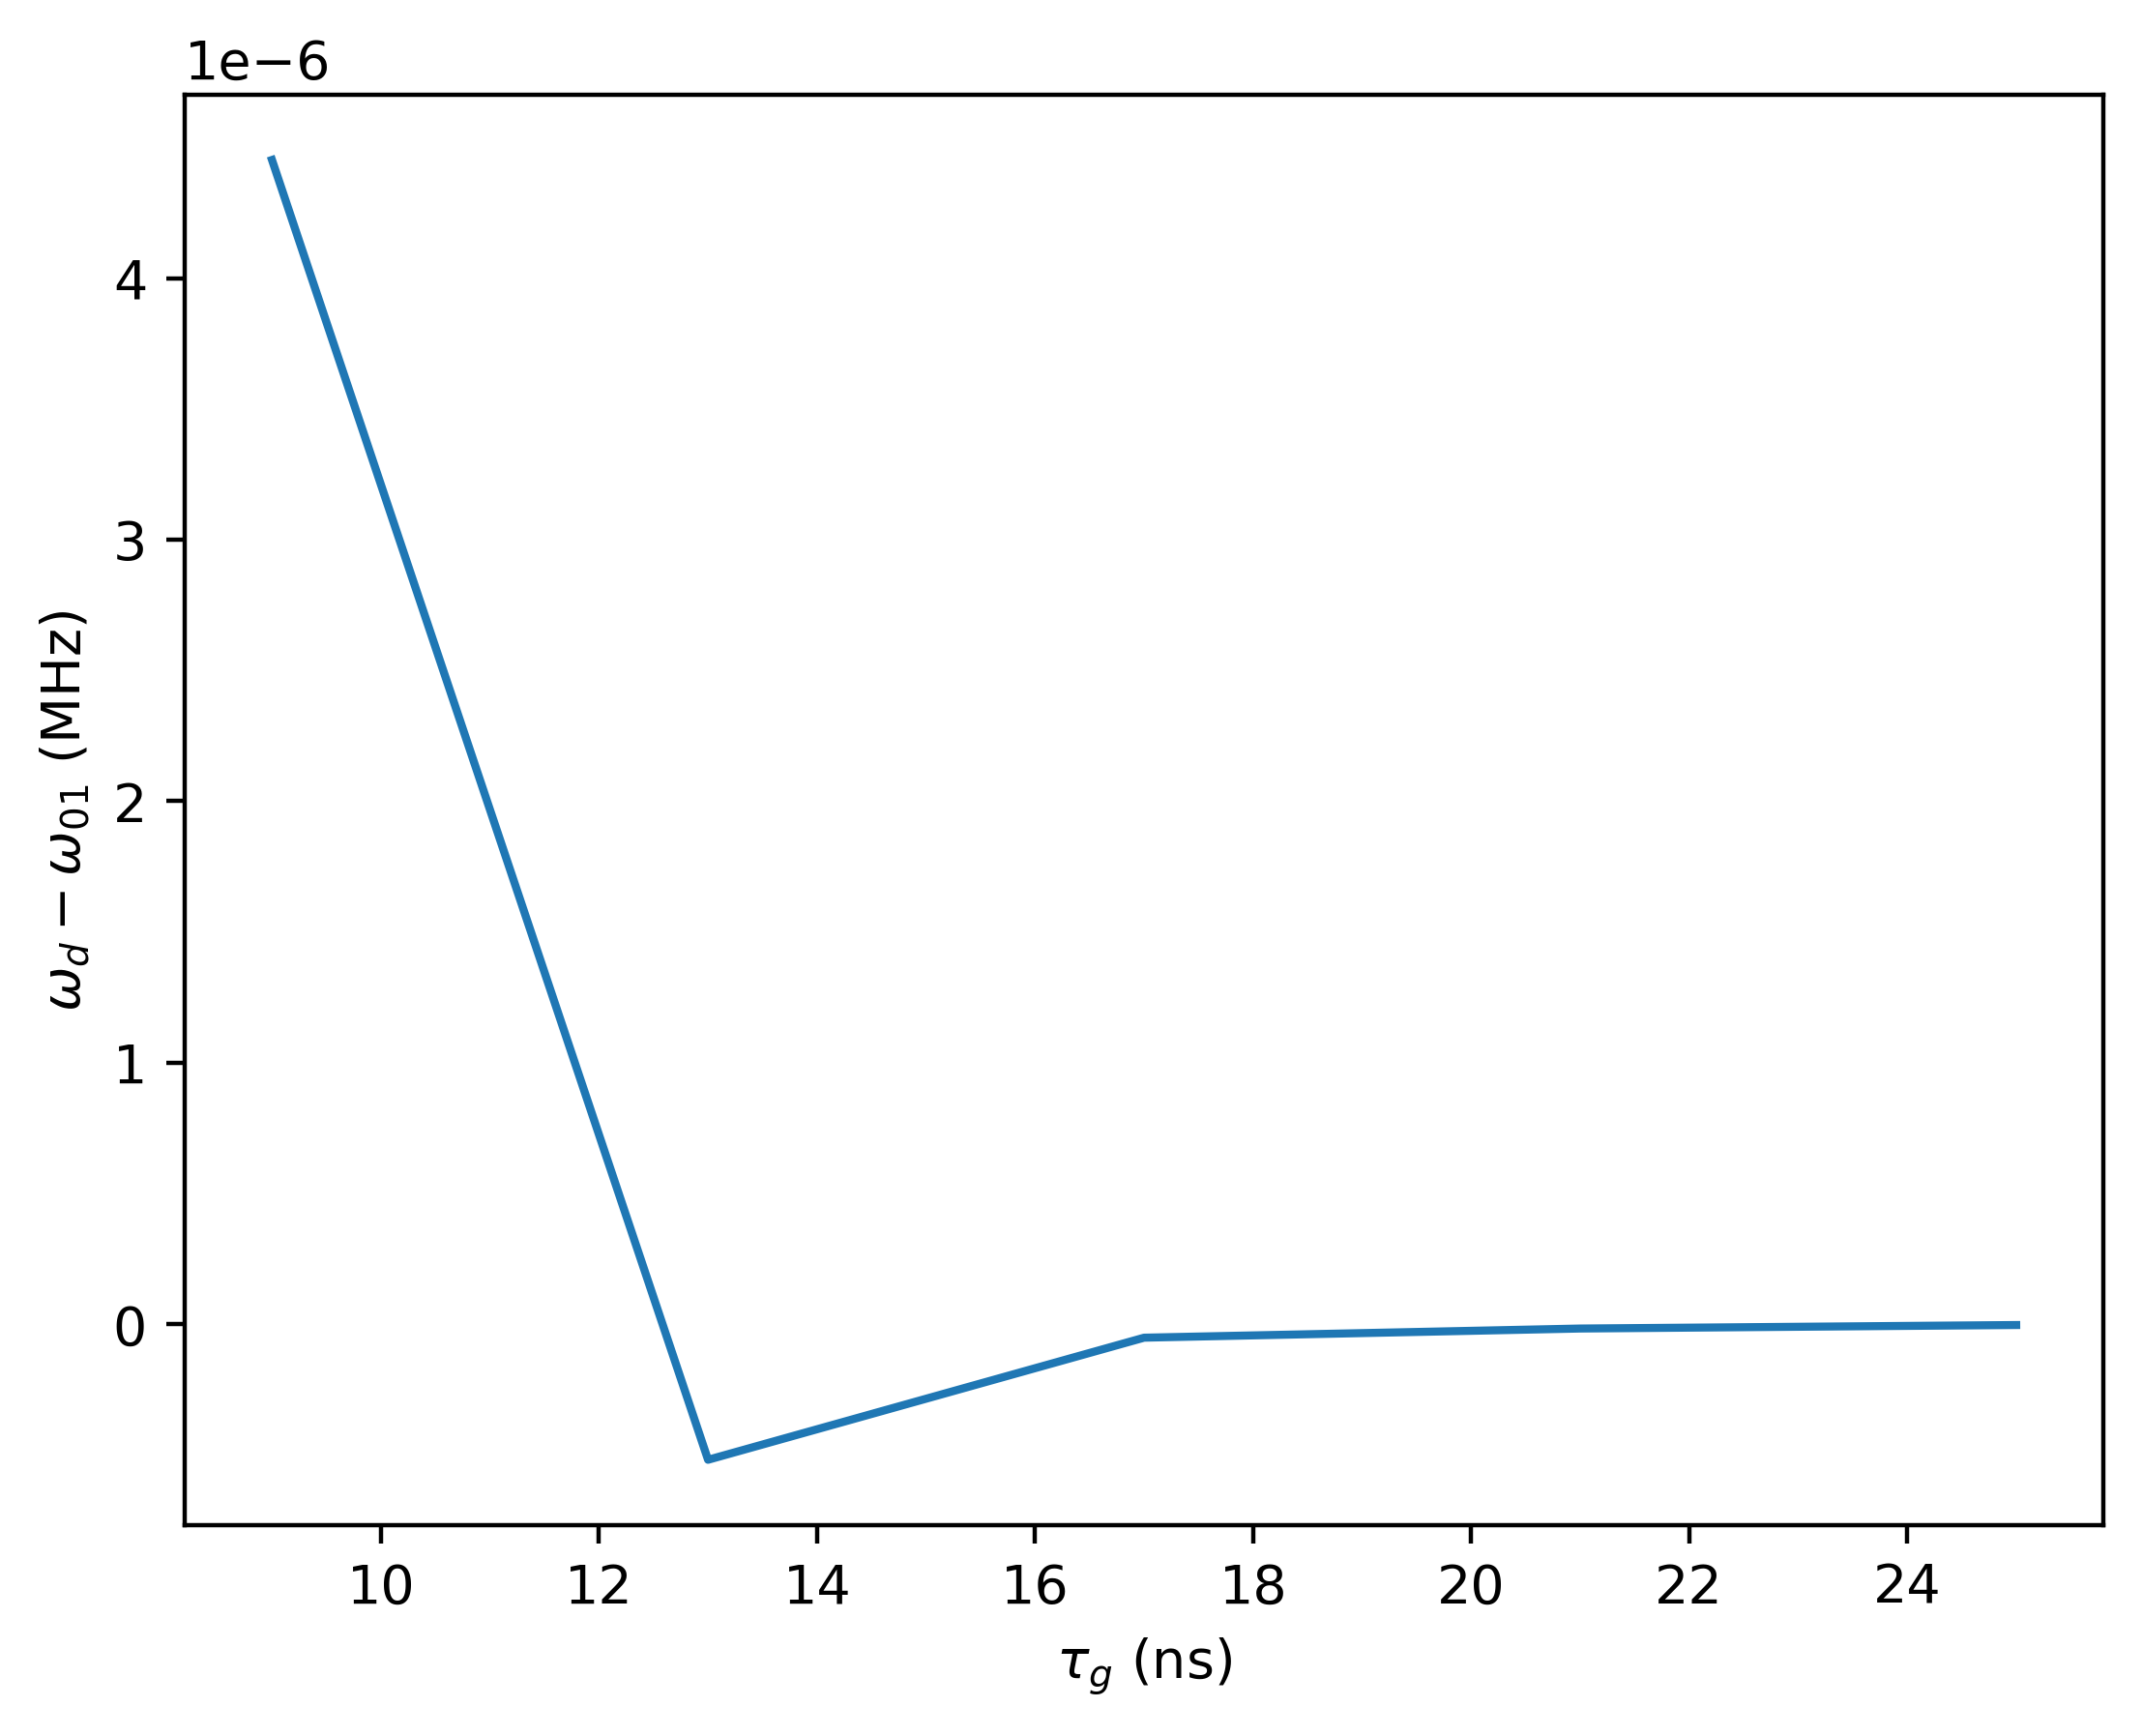

In [92]:
plt.plot(T_gate_array[1:], delta_omega_d_array[1:])
plt.ylabel(r'$\omega_d-\omega_{01}$ (MHz)')
plt.xlabel(r'$\tau_g$ (ns)')

# Sweeping qubit frequency

## Flux drive

In [94]:
E_L_array = np.linspace(0.5,1.6,11)
freq_array = np.zeros_like(E_L_array)
error_array_qubit_flux = np.zeros_like(E_L_array)
leakage_array_qubit_flux = np.zeros_like(E_L_array)
# drive_factor = 0.5

T_gate = 10
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

shape = 'cos'
drag = True
U_ideal = sigmax()

for idx, E_L in enumerate(E_L_array):
    print("E_L=", E_L)  # Liu play
    #Qubit parameters
    E_C = 3.0  # charging energy
    E_J = 15.0  # Josephson energy
    phi_ext = np.pi  # external phase shift
    qubit = fluxonium.Fluxonium(E_J=E_J, E_C=E_C, E_L=E_L, phi_ext=phi_ext, nlev = nlev_single, nlev_lc = nlev_lc)
    freq_array[idx] = qubit.freq(0,1)
    matr_el = np.abs(qubit.phi_ij(0,1))
    omega_d = qubit.freq(0,1)
    
    #Optimization here
    delta_omega_d = 0
    drag_coeff = 0
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    def infidelity(x):
        delta_omega_d = x[0]
        drag_coeff = x[1]
        drive_factor = x[2]
        epsilon = drive_factor/matr_el
        H_drive = epsilon*(qubit.phi())
        omega_d = qubit.freq(0,1) + delta_omega_d
        U_t = gates.evolution_operator_microwave(
                    qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
        U_real = U_nothing[-1]*U_t[-1]
        U_real = Qobj(U_real[0:2, 0:2])

        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
        return 1-fidel

    x0 = [0,0,0.5]
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-7)
    error_array_qubit_flux[idx] = infidelity(xopt.x)
    
    delta_omega_d = xopt.x[0]
    drag_coeff = xopt.x[1]
    drive_factor = xopt.x[2]
    epsilon = drive_factor/matr_el
    H_drive = epsilon*(qubit.phi())
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                    qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)    
    trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
    trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
    leakage_array_qubit_flux[idx] = 1 - trans_prob_0[-1] - trans_prob_1[-1]

## Charge drive

In [48]:
E_L_array = np.linspace(0.5,1.6,11)
freq_array = np.zeros_like(E_L_array)
error_array_qubit_charge = np.zeros_like(E_L_array)
leakage_array_qubit_charge = np.zeros_like(E_L_array)
# drive_factor = 0.5

T_gate = 10
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

shape = 'cos'
drag = True
U_ideal = sigmay()

for idx, E_L in enumerate(E_L_array):
    #Qubit parameters
    E_C = 1.0  # charging energy
    E_J = 4  # Josephson energy
    phi_ext = np.pi  # external phase shift
    qubit = fluxonium.Fluxonium(E_J=E_J, E_C=E_C, E_L=E_L, phi_ext=phi_ext, nlev = nlev_single, nlev_lc = nlev_lc)
    freq_array[idx] = qubit.freq(0,1)
    matr_el = np.abs(qubit.n_ij(0,1))
    omega_d = qubit.freq(0,1)
    
    #Optimization here
    delta_omega_d = 0
    drag_coeff = 0
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    def infidelity(x):
        delta_omega_d = x[0]
        drag_coeff = x[1]
        drive_factor = x[2]
        epsilon = drive_factor/matr_el
        H_drive = epsilon*(qubit.n())
        omega_d = qubit.freq(0,1) + delta_omega_d
        U_t = gates.evolution_operator_microwave(
                    qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
        U_real = U_nothing[-1]*U_t[-1]
        U_real = Qobj(U_real[0:2, 0:2])

        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
        return 1-fidel

    x0 = [0,0,0.5]
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-7)
    error_array_qubit_charge[idx] = infidelity(xopt.x)
    
    delta_omega_d = xopt.x[0]
    drag_coeff = xopt.x[1]
    drive_factor = xopt.x[2]
    epsilon = drive_factor/matr_el
    H_drive = epsilon*(qubit.n())
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                    qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)    
    trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
    trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
    leakage_array_qubit_charge[idx] = 1 - trans_prob_0[-1] - trans_prob_1[-1]

In [49]:
print (freq_array[0])
print (freq_array[-1])

0.2372135277965456
1.1631655123721956


0.43280021286396697


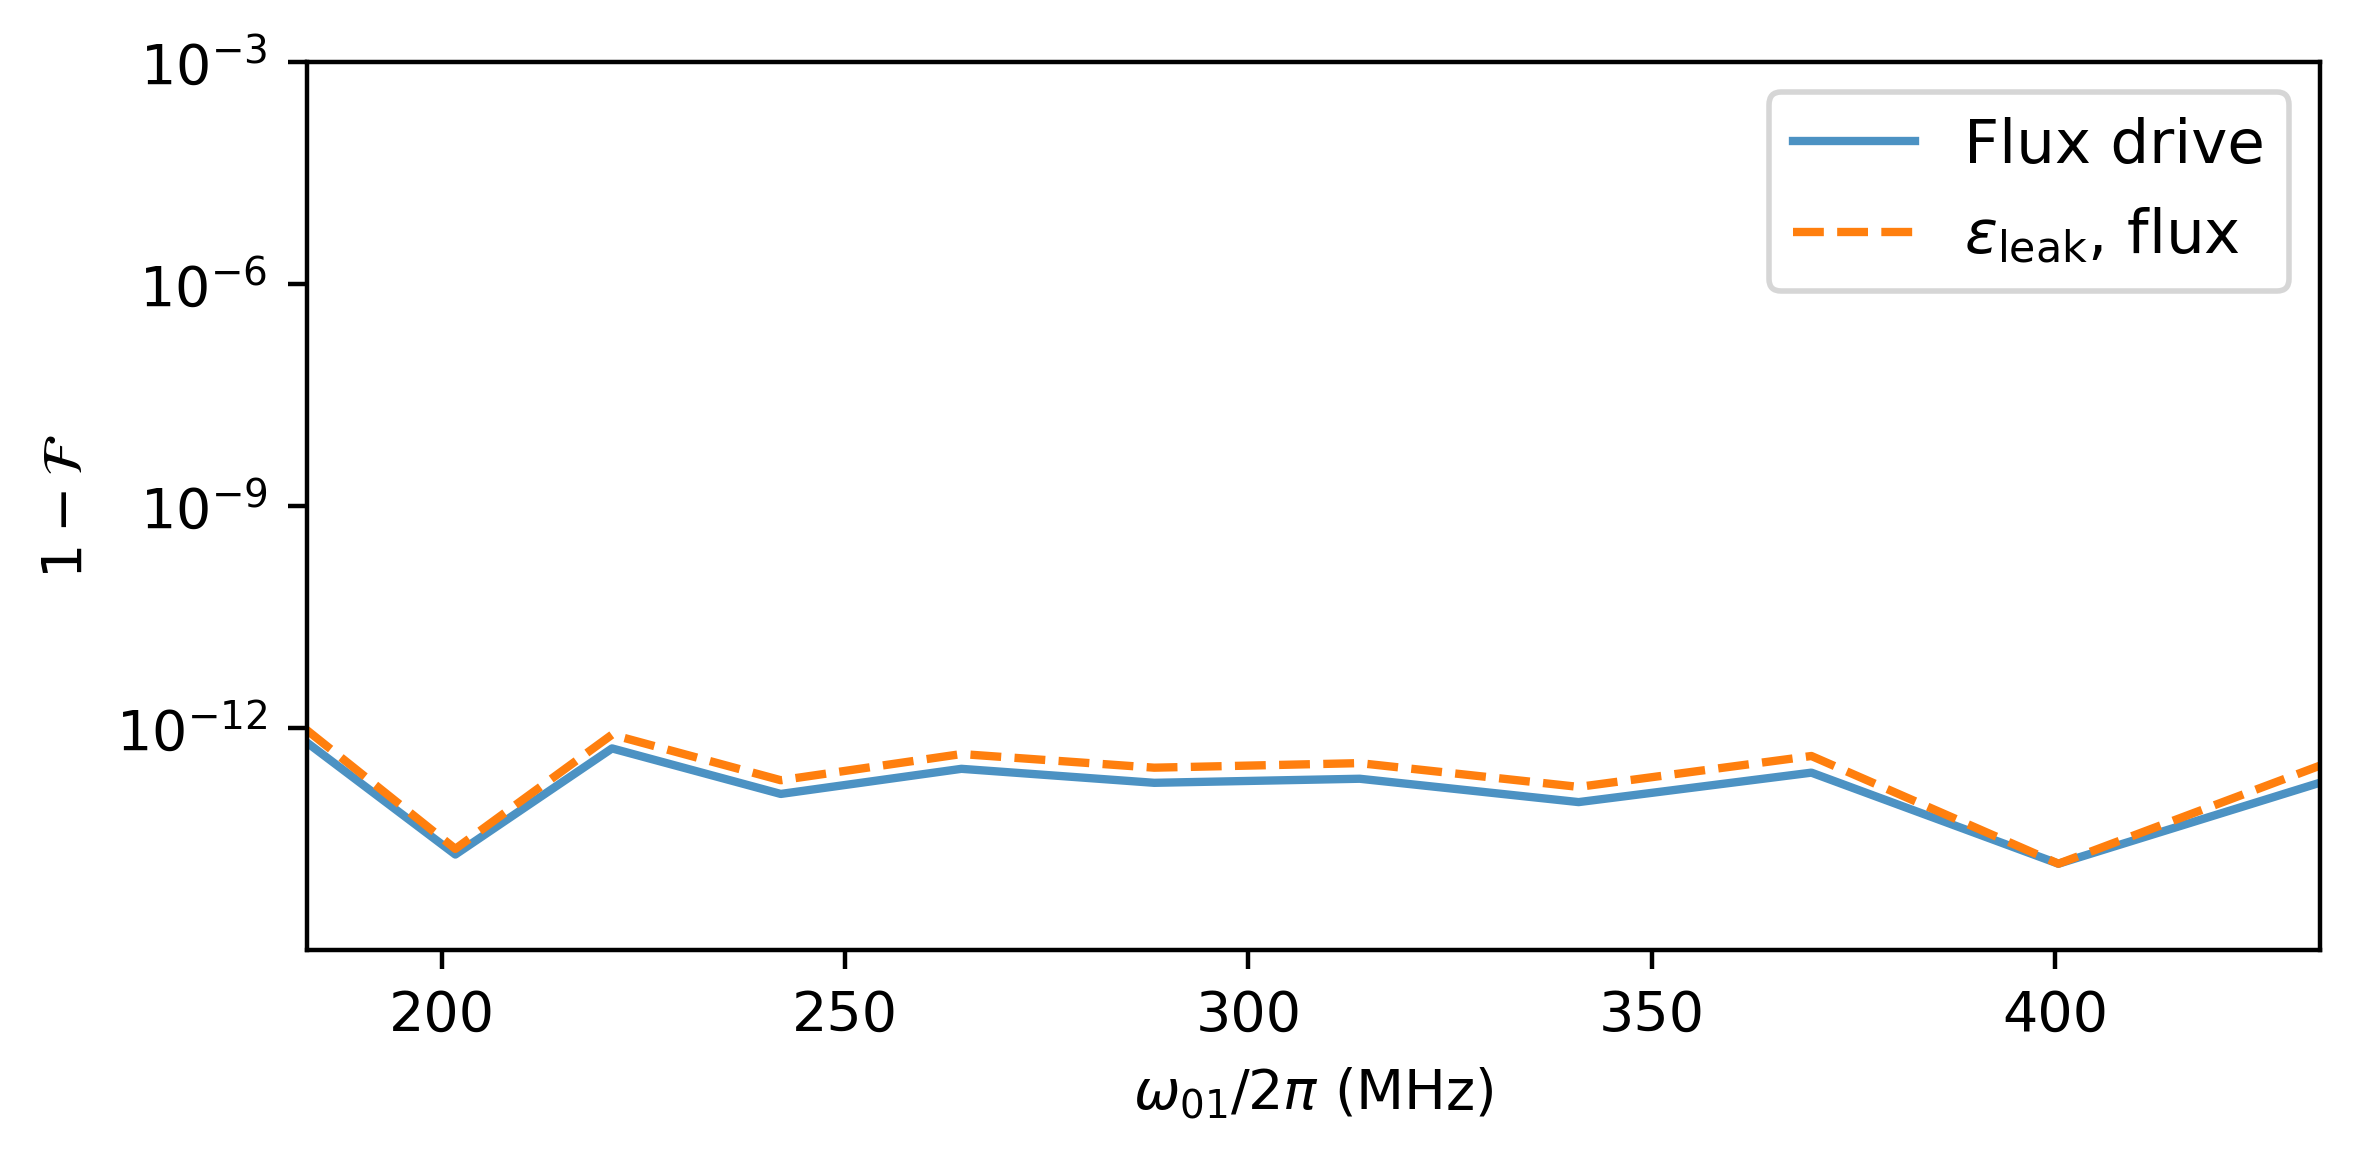

In [97]:
plt.figure(figsize = [6,3])
print (freq_array[-1])
# plt.semilogy(freq_array*1e3, error_array_qubit_charge,'-', label = 'Charge drive', alpha = 0.8)
plt.semilogy(freq_array*1e3, error_array_qubit_flux,'-', label = 'Flux drive', alpha = 0.8)
# plt.semilogy(freq_array*1e3, leakage_array_qubit_charge,'--',linewidth = 1.5, label = r'$\epsilon_\mathrm{leak}$, charge', color = 'C4')
plt.semilogy(freq_array*1e3, leakage_array_qubit_flux,'--',linewidth = 1.5, label = r'$\epsilon_\mathrm{leak}$, flux')
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel(r'$\omega_{01}/2\pi~(\mathrm{MHz})$')
plt.ylim([1e-15,1e-3])
plt.yticks([1e-12,1e-9,1e-6,1e-3])
plt.legend(fontsize = 11.0, loc = 1)
plt.xlim([freq_array[0]*1e3,freq_array[-1]*1e3])
plt.tight_layout()

In [96]:
error_array_qubit_flux

array([6.45705711e-13, 1.96509475e-14, 5.33240119e-13, 1.29340982e-13,
       2.82551760e-13, 1.82853732e-13, 2.07500683e-13, 1.00364161e-13,
       2.50799381e-13, 1.47659662e-14, 1.83519866e-13])